In [2]:
# Python packages and utilities
import os
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

try:
    import mlxtend
except ModuleNotFoundError:
     !pip install mlxtend

#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors

try:
    import py3Dmol
except ModuleNotFoundError:
    !pip install py3Dmol
    import py3Dmol

from rdkit.Chem.Draw import rdMolDraw2D
try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO

# Mordred
try:
    import mordred
    from mordred import Calculator, descriptors
except ModuleNotFoundError:
    !pip install 'mordred[full]'
    import mordred
    from mordred import Calculator, descriptors
    

# scikit-learn
try:
    import sklearn
except ModuleNotFoundError:
    !pip install -U scikit-learn
    import sklearn
    
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # This is sklearns auto-scaling function
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn import linear_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

try:
    import smogn
except ModuleNotFoundError:
    !pip install smogn
    import smogn

#imbalenced learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
except ModuleNotFoundError:
    !pip install -U imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN

try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt

# scikitplot library
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip install scikit-plot
    import scikitplot as skplt

#!pip install pip install -U imbalanced-learn

# own module
from pythia import classification_metrics as cmetrics
try:
    from pythia import finger_prints as fp
except ModuleNotFoundError:
    !python -m pip install "dask[complete]"
from pythia import molecules_and_images as mi
from pythia import plotting_sklearn as pltsk
from pythia import workflow_functions as cwf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Load target data

In [3]:
import rdkit
rdkit.__version__

'2023.03.1'

In [4]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

In [5]:
data = pd.read_csv("../dataset_initial_look/df_all_substructure_onehot.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [6]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['unnamed:_0', 'entry_in_paper', 'smiles', 'anion',
       'binding_mode\n(transporter)', 'binding_mode\n(anion)',
       'stochiometry\n(#_of_anion_\nper_transporter)', 'nmr_solvent',
       'ka_(_m-1)', 'unnamed:_8', 'log(ka)', 'assay', 'lipid', 'measured_by',
       'cl_source_inside', 'cl_conc_(mm)', 'assay_ph',
       'time_between_transporter_added_and_lysis_(s)', 'ec50_(nm)',
       'unnamed:_18', 'backup_ec50_/_mol%', 'ec50_/_mol%', 'unnamed:_21',
       'target', 'hill_parameter_n', 'unnamed:_24', 'paperid', 'year', 'ref',
       'unnamed:_27', 'logec50', 'mol', 'thiourea', 'urea', 'squaramide',
       'indole', 'tambjamine', 'carbazole', 'acridinone', 'perenosin',
       'bisbzimpy', 'isophthalamides_dipicolineamides'],
      dtype='object')


In [7]:
data['logec50'] = data['logec50'].fillna('N')

In [8]:
data

unnamed:_0 entry_in_paper   
0             0              1  \
1             1              2   
2             2              3   
3             3              4   
4             4              5   
..          ...            ...   
299         299              4   
300         300              5   
301         301              6   
302         302              7   
303         303              8   

                                                smiles anion   
0                         S=C(NCCCCCC)NC1=CC=C(Br)C=C1    Cl  \
1                   S=C(NCCCCCC)NC1=CC=C(C(F)(F)F)C=C1    Cl   
2                         S=C(NCCCCCC)NC1=CC=C(Cl)C=C1    Cl   
3                        S=C(NCCCCCC)NC1=CC=C(C#N)C=C1    Cl   
4              S=C(NCCCCCC)NC1=CC=C(C(C(F)(F)F)=O)C=C1    Cl   
..                                                 ...   ...   
299  O=C1C(NC2=CC(C(C)(C)C)=CC(C(C)(C)C)=C2)=C(NC3=...    Cl   
300            S=C1C(NC2=CC=CC=C2)=C(NC3=CC=CC=C3)C1=S    Cl   
301  S=C1C(NC2=CC=C(C(F)(F)F)C=C2)=C(NC3=CC=C(C(F)(...    Cl   
302  S=C1C(NC2=CC(C(F)(F)F)=CC(C(F)(F)F)=C2)=C(NC3=...    Cl   
303  S=C1C(NC2=CC(C(C)(C)C)=CC(C(C)(C)C)=C2)=C(NC3=...    Cl   

     binding_mode\n(transporter)  ...  carbazole  acridinone perenosin   
0                            1.0  ...          0           0         0  \
1                            1.0  ...          0           0         0   
2                            1.0  ...          0           0         0   
3                            1.0  ...          0           0         0   
4                            1.0  ...          0           0         0   
..                           ...  ...        ...         ...       ...   
299                          1.0  ...          0           0         0   
300                          1.0  ...          0           0         0   
301                          1.0  ...          0           0         0   
302                          1.0  ...          0           0         0   
303                          1.0  ...          0           0         0   

    bisbzimpy  isophthalamides_dipicolineamides  
0           0                                 0  
1           0                                 0  
2           0                                 0  
3           0                                 0  
4           0                                 0  
..        ...                               ...  
299         0                                 0  
300         0                                 0  
301         0                                 0  
302         0                                 0  
303         0                                 0  

[304 rows x 42 columns]

# Set Target Properties

In [9]:
substratesmiles = data["smiles"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

targets = data["logec50"]
log.info("logEC50: {}".format(targets.head()))

Substrate SMILES: 0               S=C(NCCCCCC)NC1=CC=C(Br)C=C1
1         S=C(NCCCCCC)NC1=CC=C(C(F)(F)F)C=C1
2               S=C(NCCCCCC)NC1=CC=C(Cl)C=C1
3              S=C(NCCCCCC)NC1=CC=C(C#N)C=C1
4    S=C(NCCCCCC)NC1=CC=C(C(C(F)(F)F)=O)C=C1
Name: smiles, dtype: object
logEC50: 0   -0.031517
1   -0.356547
2      0.0086
3   -0.086186
4   -0.031517
Name: logec50, dtype: object


# Classify Molecules
Use these next cells to classify the ec50 values into 'good' and 'bad' in terms of transport activity. To visualize all of these structure set show to True.

(array([126., 178.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

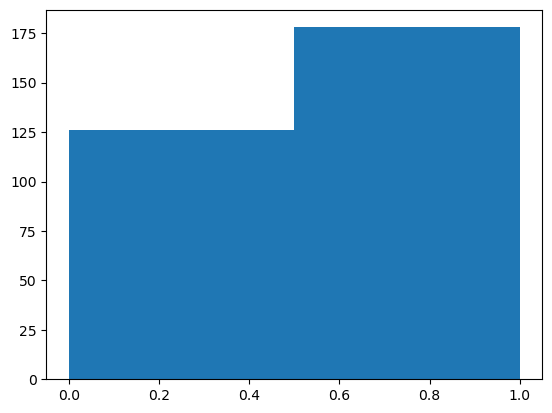

In [10]:
classes=[]
for index, value in targets.items():
    if value == 'N' or value > 0:
        classes.append(0)
    else:
        classes.append(1)
plt.hist(classes, bins = 2)

# Make Mordred Features

In [11]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list = [mi.smiles_to_molcule(s) for s in substratesmiles]
subfeatures_df = calc.pandas(submolecule_list)

[18:25:47] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[18:25:47] UFFTYPER: Unrecognized atom type: S_6+6 (30)
[18:25:47] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[18:25:47] UFFTYPER: Unrecognized atom type: S_6+6 (32)
[18:25:48] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[18:25:48] UFFTYPER: Unrecognized atom type: S_6+6 (33)
[18:25:48] UFFTYPER: Unrecognized atom type: S_6+6 (1)
[18:25:48] UFFTYPER: Unrecognized atom type: S_6+6 (31)
[18:25:48] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[18:25:48] UFFTYPER: Unrecognized atom type: S_6+6 (36)
[18:25:49] UFFTYPER: Unrecognized atom type: S_6+6 (15)
[18:25:49] UFFTYPER: Unrecognized atom type: S_6+6 (35)
[18:25:54] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[18:25:54] UFFTYPER: Unrecognized atom type: S_6+6 (27)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [01:19<00:00,  3.80it/s]


In [29]:
subfeatures_df.shape

(304, 1826)

In [30]:
subfeatures_df.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df.index)))
threshold = 0.5
subfeatures_df.drop(subfeatures_df.std()[subfeatures_df.std() < threshold].index.values, axis=1)
subfeatures_df.columns = [ent.strip() for ent in subfeatures_df.columns]
subfeatures_df.head()

ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  Zagreb2  \
0  12.239595  10.328049      0      0  21.058346  ...    18     74.0     78.0   
1  14.666672  12.145219      0      0  23.725036  ...    24     92.0     99.0   
2  12.239595  10.328049      0      0  21.058346  ...    18     74.0     78.0   
3  12.837312  10.747326      0      0  22.380237  ...    20     78.0     83.0   
4  16.149835  13.345719      0      0  26.171815  ...    28    102.0    111.0   

   mZagreb1  mZagreb2  
0  6.083333  4.083333  
1  8.145833  4.583333  
2  6.083333  4.083333  
3  6.333333  4.416667  
4  9.256944  5.027778  

[5 rows x 1826 columns]

In [31]:
feats_to_add = ['cl_conc_(mm)', 'time_between_transporter_added_and_lysis_(s)']

for f in feats_to_add:
    subfeatures_df[f] = data[f]

subfeatures_df

ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  Zagreb2   mZagreb1  \
0    12.239595  10.328049      0      0  21.058346  ...     78.0   6.083333   
1    14.666672  12.145219      0      0  23.725036  ...     99.0   8.145833   
2    12.239595  10.328049      0      0  21.058346  ...     78.0   6.083333   
3    12.837312  10.747326      0      0  22.380237  ...     83.0   6.333333   
4    16.149835  13.345719      0      0  26.171815  ...    111.0   9.256944   
..         ...        ...    ...    ...        ...  ...      ...        ...   
299  28.587662  23.540835      0      0  41.758959  ...    234.0  17.361111   
300  15.613368  12.800227      0      0  26.608945  ...    122.0   5.666667   
301  22.100515  17.213143      0      0  34.199068  ...    178.0  11.513889   
302  28.587662  23.540835      0      0  41.758959  ...    234.0  17.361111   
303  28.587662  23.540835      0      0  41.758959  ...    234.0  17.361111   

     mZagreb2  cl_conc_(mm)  time_between_transporter_added_and_lysis_(s)  
0    4.083333           489                                           270  
1    4.583333           489                                           270  
2    4.083333           489                                           270  
3    4.416667           489                                           270  
4    5.027778           489                                           270  
..        ...           ...                                           ...  
299  7.111111           489                                           270  
300  4.444444           489                                           270  
301  5.777778           489                                           270  
302  7.111111           489                                           270  
303  7.111111           489                                           270  

[304 rows x 1828 columns]

In [32]:
log.info(subfeatures_df)
subfeature_types = "some_categorical" # other options 'some_catagorical', 'no_catagorical'

           ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  Zagreb2   mZagreb1  \
0    12.239595  10.328049      0      0  21.058346  ...     78.0   6.083333   
1    14.666672  12.145219      0      0  23.725036  ...     99.0   8.145833   
2    12.239595  10.328049      0      0  21.058346  ...     78.0   6.083333   
3    12.837312  10.747326      0      0  22.380237  ...     83.0   6.333333   
4    16.149835  13.345719      0      0  26.171815  ...    111.0   9.256944   
..         ...        ...    ...    ...        ...  ...      ...        ...   
299  28.587662  23.540835      0      0  41.758959  ...    234.0  17.361111   
300  15.613368  12.800227      0      0  26.608945  ...    122.0   5.666667   
301  22.100515  17.213143      0      0  34.199068  ...    178.0  11.513889   
302  28.587662  23.540835      0      0  41.758959  ...    234.0  17.361111   
303  28.587662  23.540835      0      0  41.758959  ...    234.0  17.361111   

     mZagreb2  cl_conc_(mm)  time_between_transport

In [33]:
class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
features_and_classes_df = subfeatures_df.copy()
features_and_classes_df["classes"] = classes

In [34]:
subfeatures_df.to_csv("features.csv")

# Pearson correlation coefficent and Spearman's rank correlation coefficient
In the next cells we can investigate how well each bit correlates against our property of interest and checks for signficance using a one tail permutation test: how many times out of the n_sample do I obtain a correlation coefficient that is greater than the observed value.

In the next block the feature with a reasonable correlation and statistically significant are chosen. The sig_metric is the significance testing metric correlation coefficent names are two tail p tests. to do one tail enter replacing option with gt for greater than and lt for less than and the correction coefficent name one of pearsron, spearman or kendalltau, onetail_$option_$correlation_coefficent.

In [35]:
subreasonable_predicted_properties, subsignificant_fearures = cwf.find_correlating_features(subfeatures_df, classes, thresh=0.3, 
                                                                                      plot=False, corr_method="spearman", 
                                                                                      sig_metric="spearman", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0]
Significance will be calculated for the correlations
nBase: 0.3215 P: 0.0002 Significan

In [36]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_fearures, len(subsignificant_fearures)))
use_significant = True
use_reasonable = False

['nBase', 'ATSC4c', 'AATSC0c', 'AATSC3c', 'AATSC4c', 'MATS1c', 'MATS2c', 'MATS3c', 'GATS3c', 'BCUTc-1h', 'NdsCH', 'SdsCH', 'PEOE_VSA12', 'n5ARing', 'n5AHRing', 'time_between_transporter_added_and_lysis_(s)'] 16
['nBase', 'ATSC4c', 'AATSC0c', 'AATSC3c', 'AATSC4c', 'MATS1c', 'MATS2c', 'MATS3c', 'GATS3c', 'BCUTc-1h', 'NdsCH', 'SdsCH', 'PEOE_VSA12', 'n5ARing', 'n5AHRing', 'time_between_transporter_added_and_lysis_(s)'] 16


In [37]:
subfeats_df = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_fearures:
        subfeats_df[k] = subfeatures_df[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df[k] = subfeatures_df[k]

# Feature exploration
In the section I explore the features and their relationships. 
Use these two next cells to classify the amines into 'good' and 'bad' in terms of capacity. To visualize all of these structure set show to True.

In [38]:
pd.set_option('display.max_columns', len(subfeats_df.columns))
subfeats_df.describe()

nBase      ATSC4c     AATSC0c     AATSC3c     AATSC4c      MATS1c  \
count  304.000000  304.000000  304.000000  304.000000  304.000000  304.000000   
mean     0.200658   -0.252761    0.021283   -0.000129   -0.002163   -0.624065   
std      0.401153    0.293735    0.007770    0.003140    0.002883    0.170683   
min      0.000000   -1.331565    0.005597   -0.008674   -0.011622   -0.911620   
25%      0.000000   -0.470309    0.015278   -0.001976   -0.003543   -0.760267   
50%      0.000000   -0.147054    0.021279   -0.000805   -0.001404   -0.668762   
75%      0.000000   -0.015350    0.027411    0.002231   -0.000161   -0.492632   
max      1.000000    0.362557    0.039696    0.007949    0.005493   -0.311713   

           MATS2c      MATS3c      GATS3c    BCUTc-1h       NdsCH       SdsCH  \
count  304.000000  304.000000  304.000000  304.000000  304.000000  304.000000   
mean     0.176566   -0.023859    1.054503    0.465680    0.378289    0.745456   
std      0.192914    0.141482    0.155410    0.067088    0.815479    1.634254   
min     -0.295231   -0.461376    0.741176    0.329469    0.000000    0.000000   
25%     -0.026012   -0.143503    0.937691    0.417441    0.000000    0.000000   
50%      0.233066   -0.034646    1.041329    0.469828    0.000000    0.000000   
75%      0.307819    0.131902    1.181575    0.519809    0.000000    0.000000   
max      0.592815    0.286270    1.465162    0.630706    5.000000   10.856105   

       PEOE_VSA12     n5ARing    n5AHRing  \
count  304.000000  304.000000  304.000000   
mean     1.188796    0.154605    0.154605   
std      2.848595    0.362124    0.362124   
min      0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000   
max     17.451663    1.000000    1.000000   

       time_between_transporter_added_and_lysis_(s)  
count                                    304.000000  
mean                                     277.105263  
std                                       12.775367  
min                                      270.000000  
25%                                      270.000000  
50%                                      270.000000  
75%                                      270.000000  
max                                      300.000000

The next cell shows counts of for each sub-structure bit how many with and how many without that sub-structure are in each class

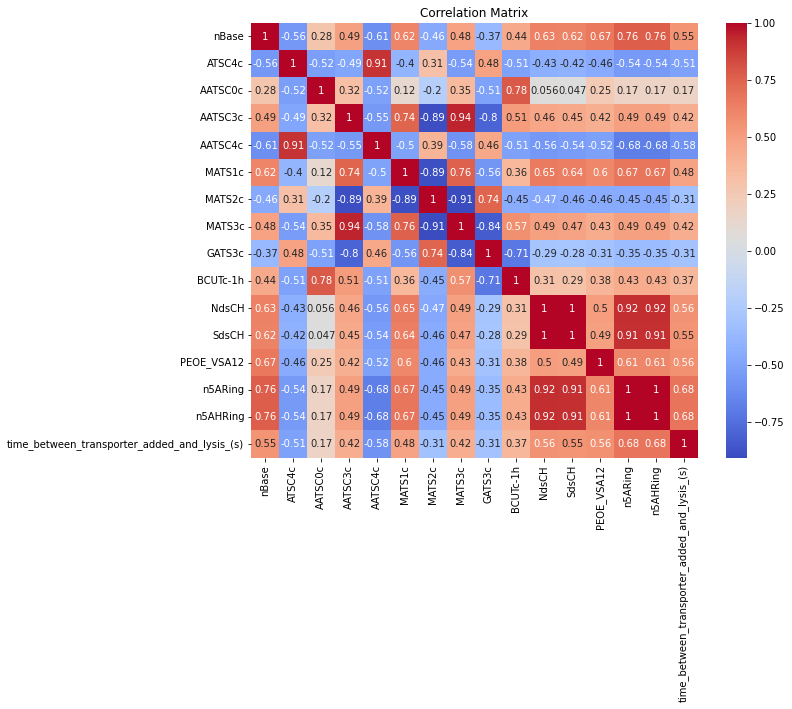

In [40]:
corr_matrix = subfeats_df.corr()

# Create a heatmap visualization of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
plt.title("Correlation Matrix")
plt.show()


Performing Variance Inflation Factor (VIF) test. It has been commented out here as for our dataset there is high multicolliniarity and actually all features should be removed

In [66]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Calculate VIF for each predictor variable
# vif_df = pd.DataFrame()
# vif_df["feature"] = features_df.columns
# vif_df["VIF"] = [variance_inflation_factor(features_df.values, i) for i in range(features_df.shape[1])]

# # Print the VIF values
# print(vif_df)

# # Remove any predictor variables with high VIF values
# # Change threshold approprietly
# vif_threshold = 10
# high_vif_features = vif_df[vif_df["VIF"] > vif_threshold]["feature"].values
# if len(high_vif_features) > 0:
#     print("Removing high VIF features:", high_vif_features)
#     features_df.drop(high_vif_features, axis=1, inplace=True)

The code generates histograms of the features in the "features_df" dataframe, and separates the histograms based on the class labels in the "classes" column of the "features_and_classes_df" dataframe.

Over all classes


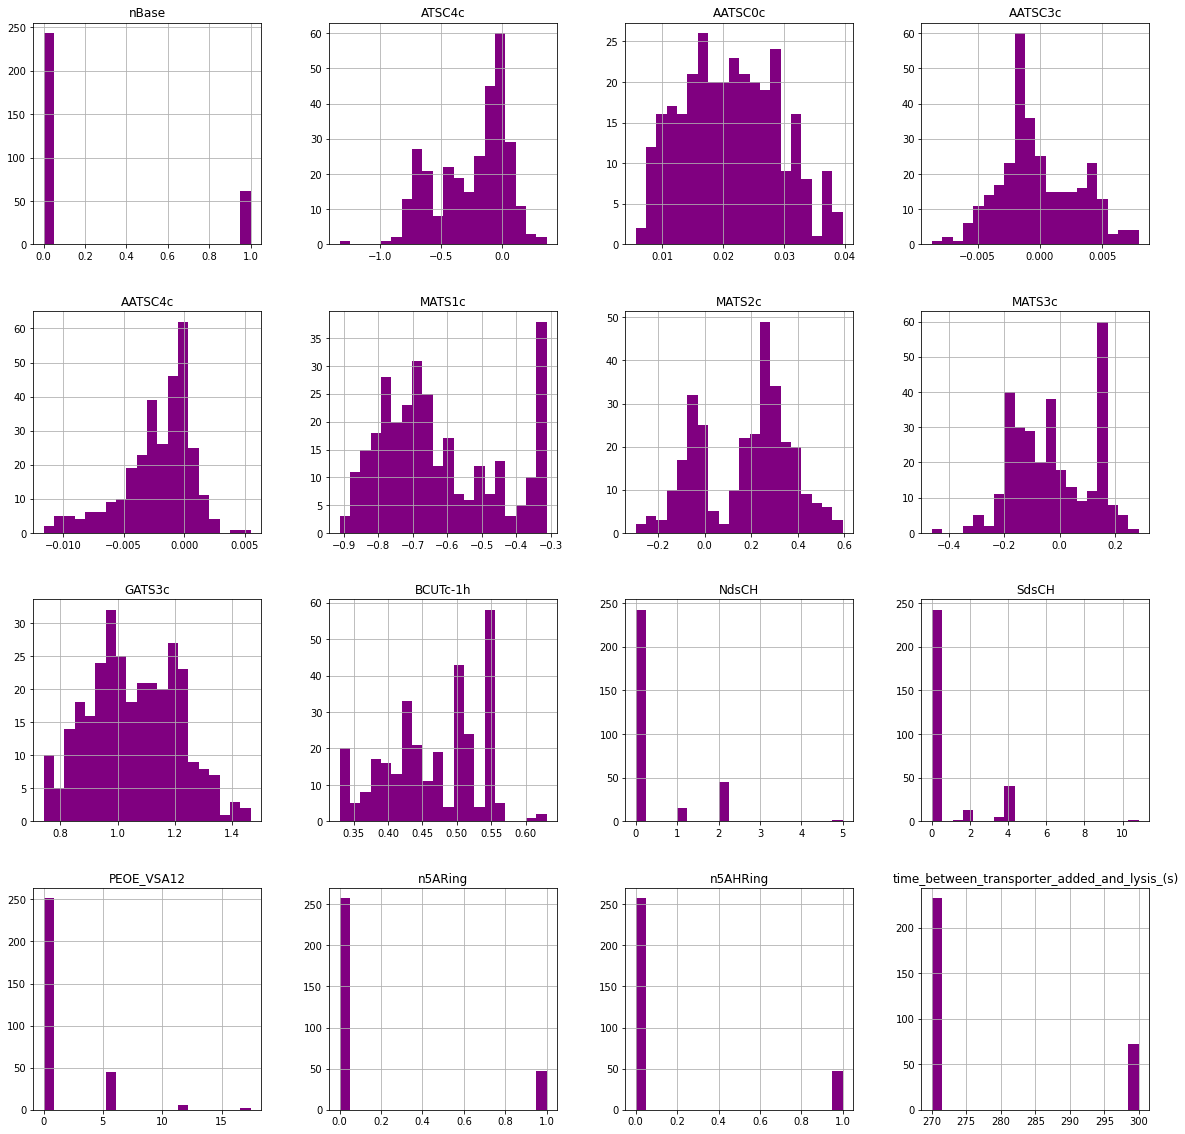

Class 0 only


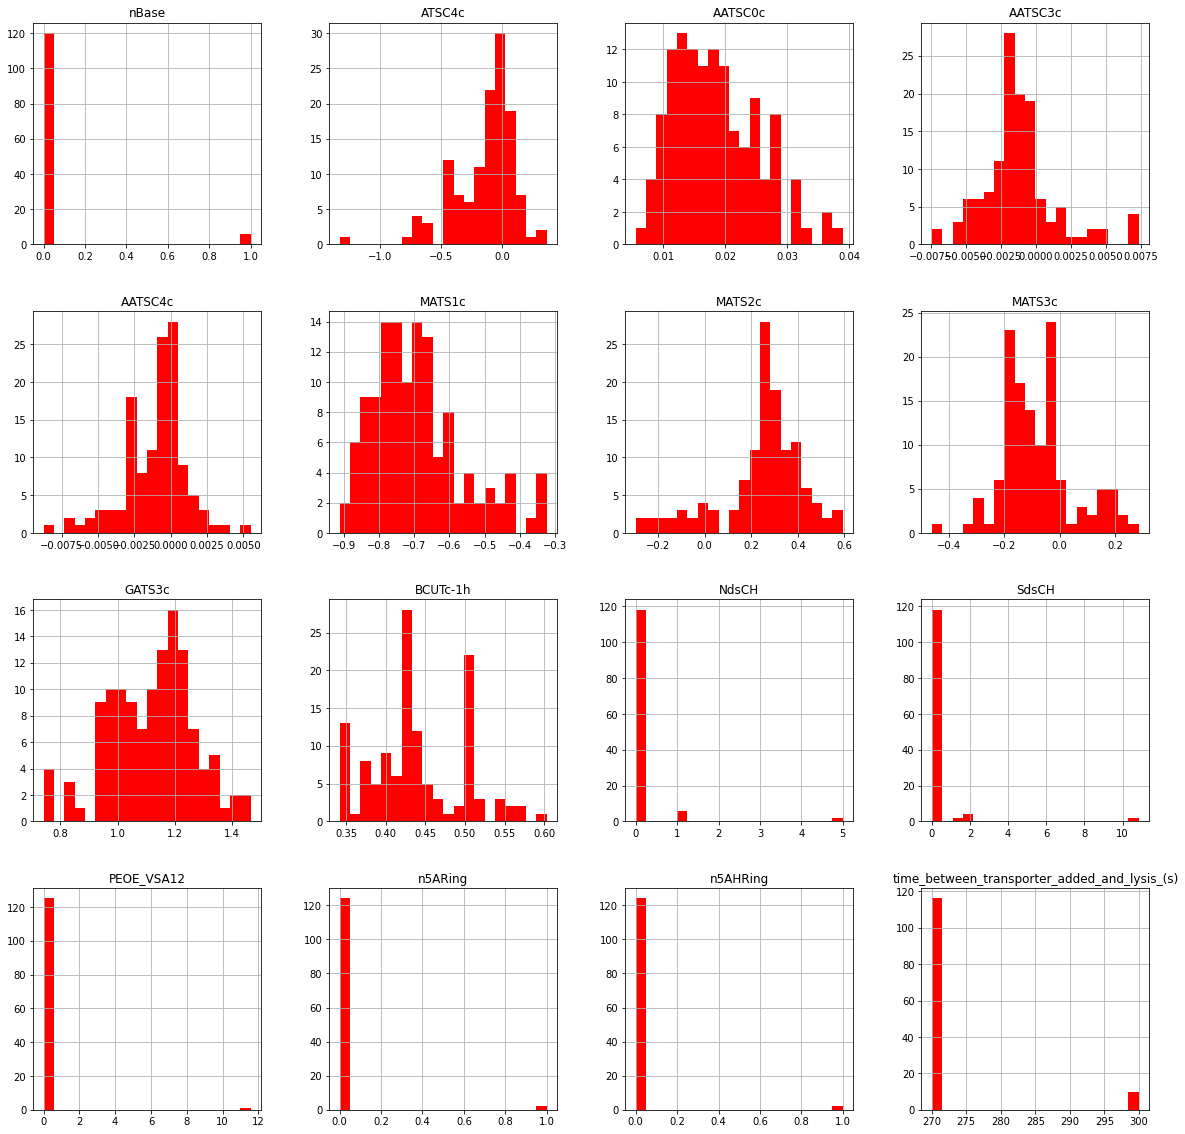

Class 1 only


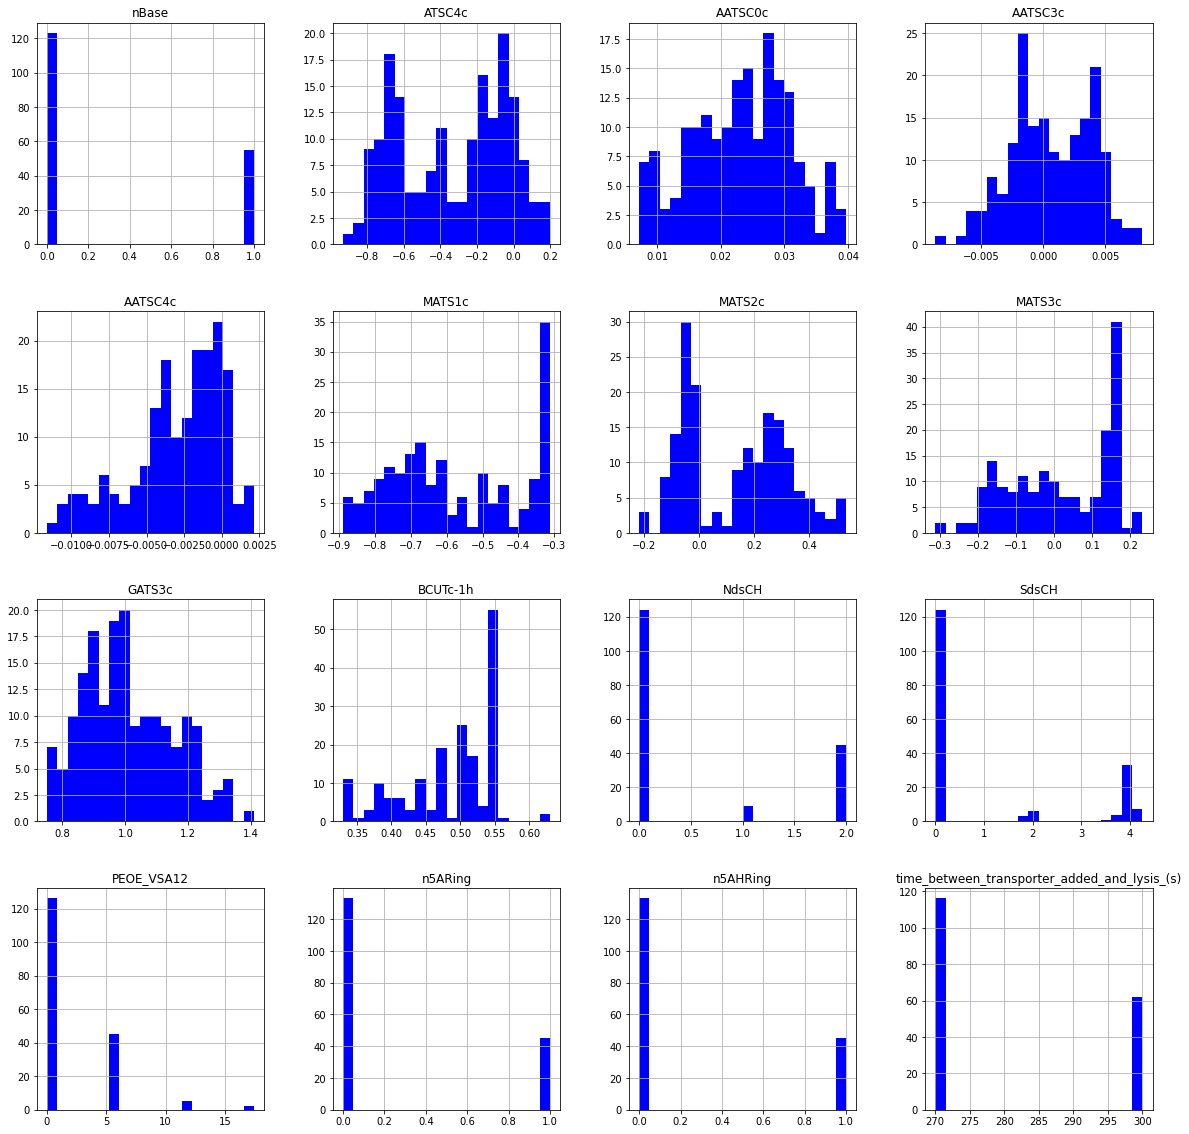

In [41]:
log.info("Over all classes")
subfeats_df.hist(bins=20, figsize=(20,20), color="purple")
plt.savefig("features_all_classes.png")
plt.show()

log.info("Class 0 only")
subfeats_df[features_and_classes_df["classes"]==0].hist(bins=20, figsize=(20,20), color="red")
plt.savefig("features_class_0.png")
plt.show()

log.info("Class 1 only")
subfeats_df[features_and_classes_df["classes"]==1].hist(bins=20, figsize=(20,20), color="blue")
plt.savefig("features_class_1.png")
plt.show()

In [42]:
subfeats_df["classes"] = features_and_classes_df["classes"]

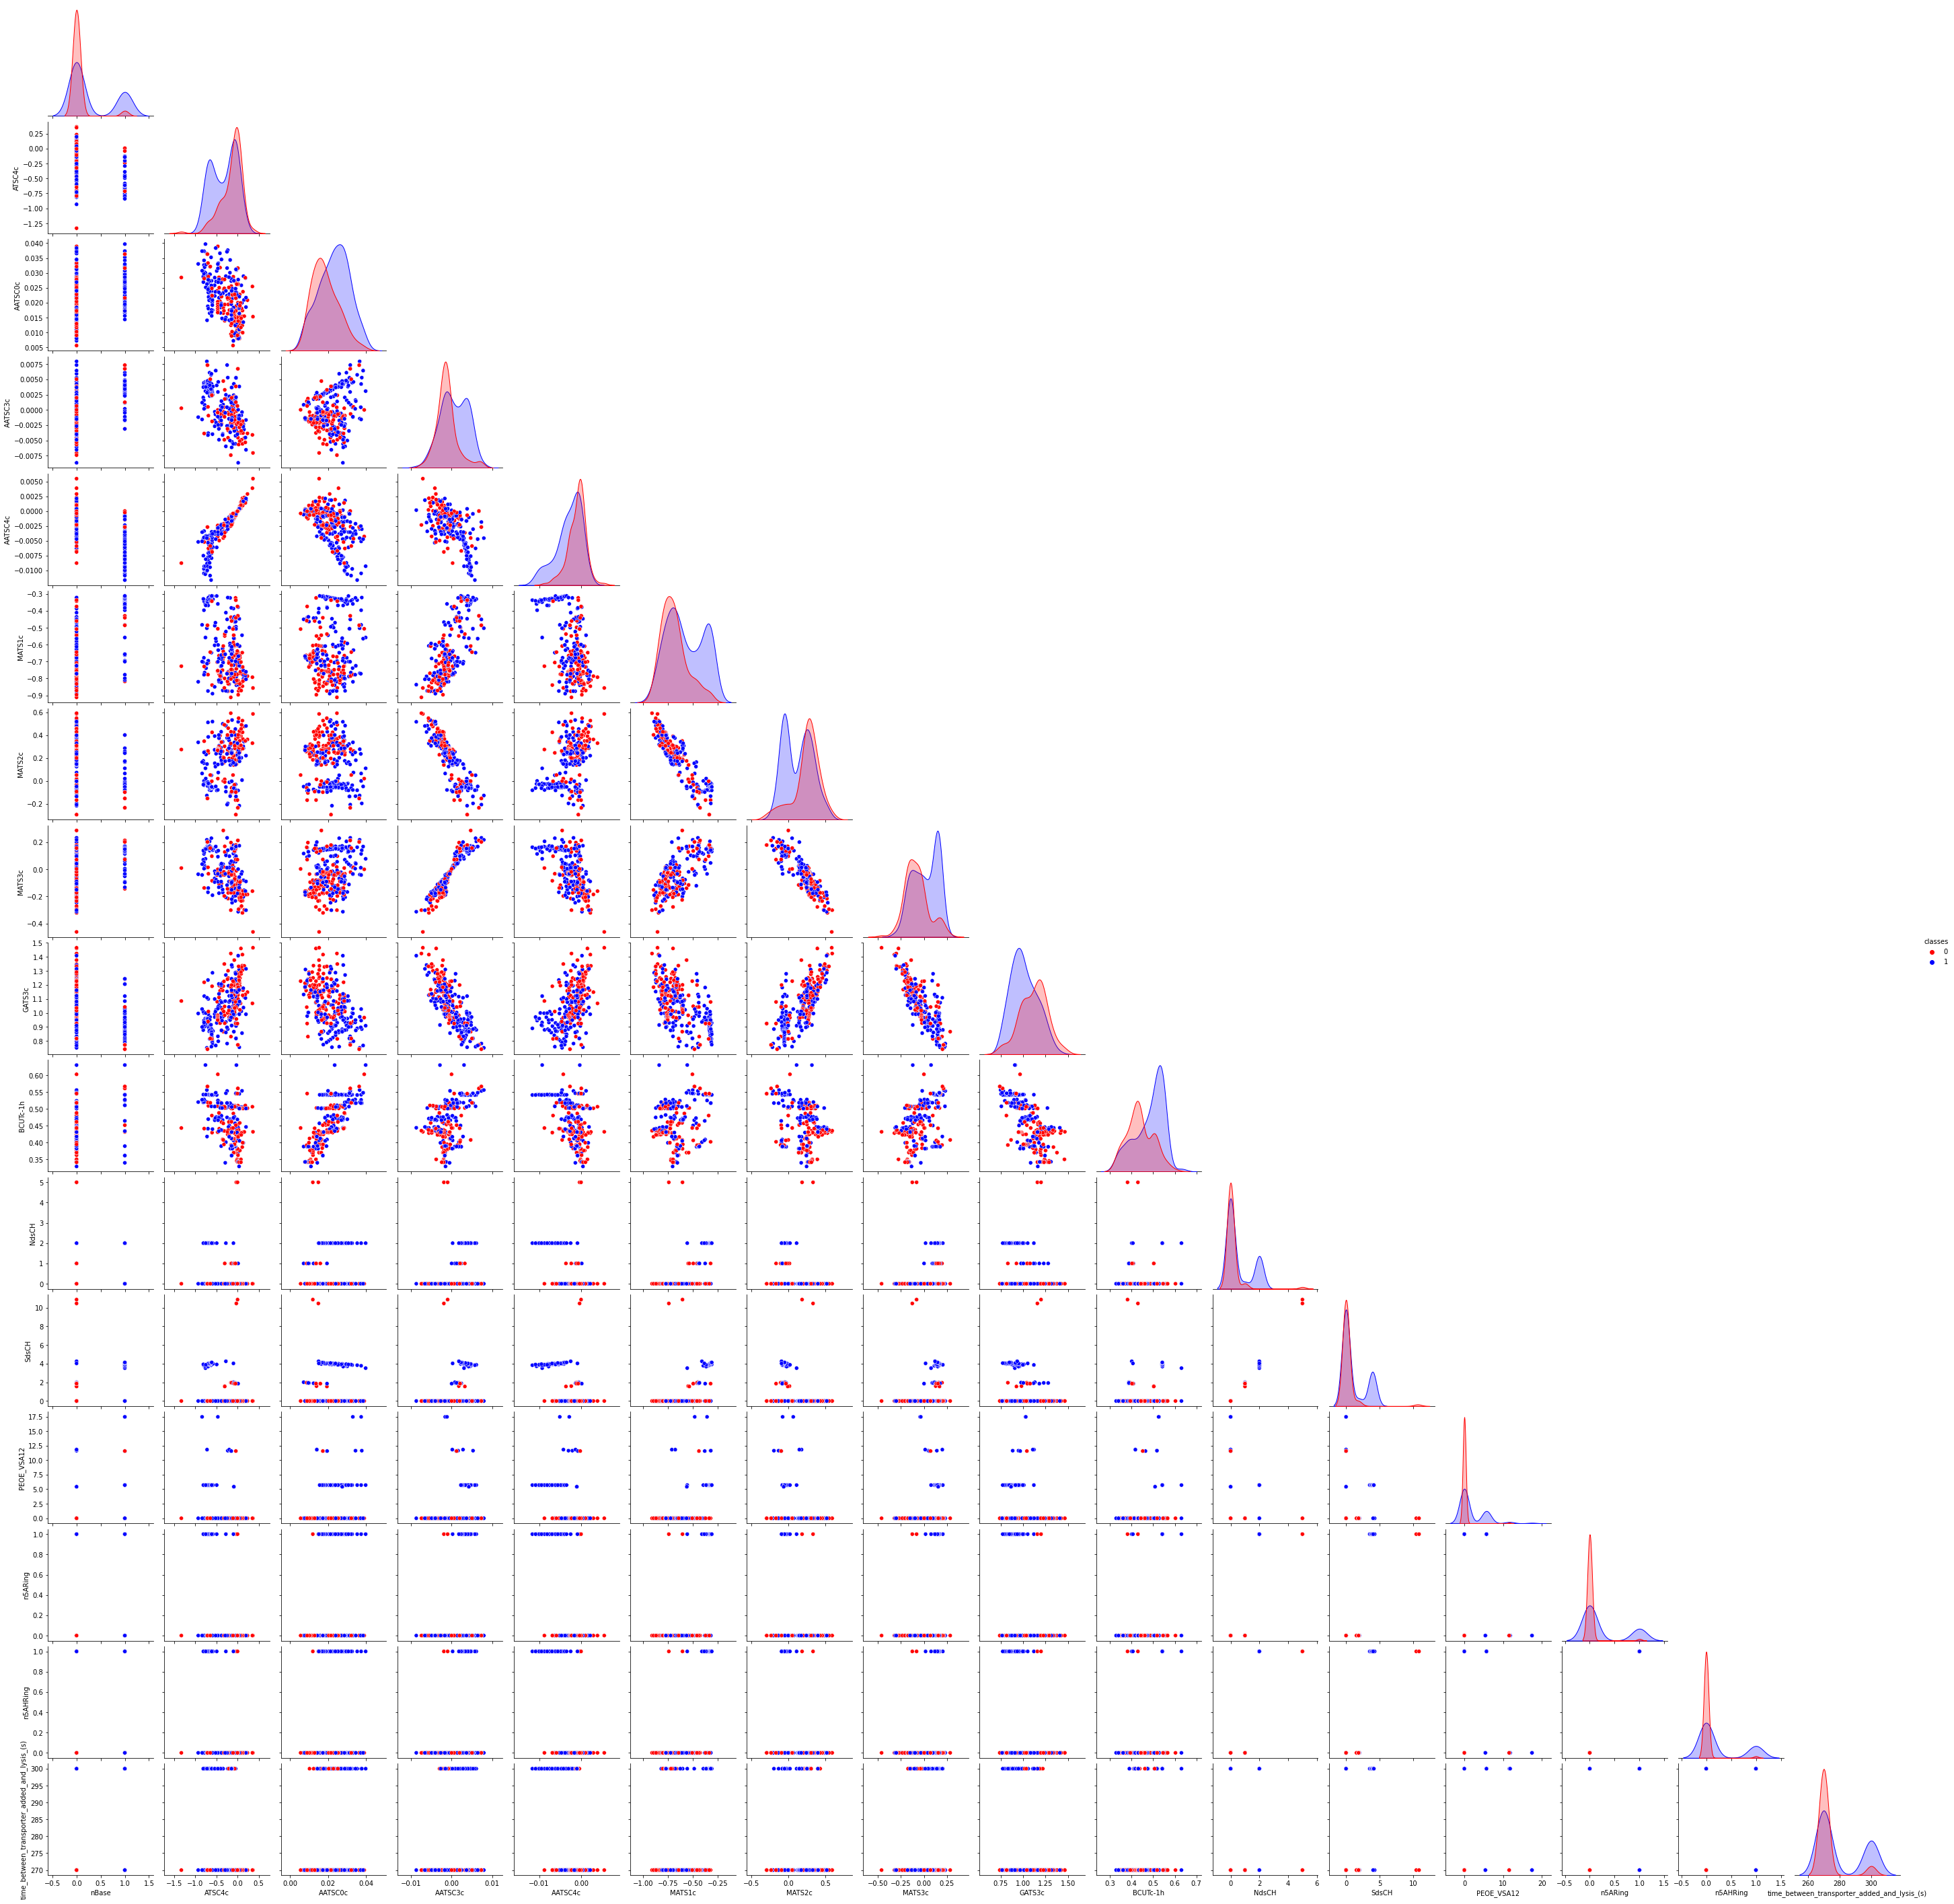

In [43]:
features_plot = sns.pairplot(subfeats_df, hue="classes", diag_kind="kde", kind="scatter", palette = ["red", "blue"], corner=True)
features_plot.savefig("var_features_plot.png")
features_plot

In [44]:
# Remove features with "drop" as you see fit according to your model.

In [45]:
features_df = subfeats_df.drop(["classes"], axis=1)

In [46]:
features_df.to_csv("features.csv")

The next cell is more geared for continuous data but shows the break down of the molecules in each class into bins of not haveing a sub-structure (0 x-axis) and having a sub-structure (1 x-axis).

# Classification
In this section we test out a range of classification models.

## Data scaling

In [47]:
features_df = pd.read_csv("features.csv", index_col=0)

In [48]:
features_df

nBase    ATSC4c   AATSC0c   AATSC3c   AATSC4c    MATS1c    MATS2c  \
0        0 -0.000857  0.010621 -0.001944 -0.000011 -0.720237  0.321308   
1        0  0.039533  0.016376 -0.000942  0.000449 -0.724106  0.201324   
2        0 -0.011080  0.010764 -0.001949 -0.000146 -0.721145  0.322786   
3        0  0.005489  0.011579 -0.001574  0.000069 -0.679236  0.261859   
4        0  0.104085  0.019958 -0.000374  0.001156 -0.544208  0.006901   
..     ...       ...       ...       ...       ...       ...       ...   
299      0 -0.004497  0.009023  0.000642 -0.000016 -0.374062 -0.168378   
300      0 -0.141809  0.012962  0.001986 -0.002287 -0.460129 -0.093471   
301      0 -0.140996  0.023998  0.003672 -0.001639 -0.612386 -0.003040   
302      0 -0.646998  0.032146  0.005031 -0.005882 -0.644153  0.051534   
303      0 -0.109099  0.005597  0.000016 -0.000376 -0.507871  0.051337   

       MATS3c    GATS3c  BCUTc-1h  NdsCH  SdsCH  PEOE_VSA12  n5ARing  \
0   -0.183077  1.244654  0.347354      0    0.0         0.0        0   
1   -0.057529  0.990848  0.501528      0    0.0         0.0        0   
2   -0.181091  1.239292  0.350434      0    0.0         0.0        0   
3   -0.135908  1.143339  0.370634      0    0.0         0.0        0   
4   -0.018758  0.855693  0.554058      0    0.0         0.0        0   
..        ...       ...       ...    ...    ...         ...      ...   
299  0.071210  0.924178  0.545958      0    0.0         0.0        0   
300  0.153242  1.199153  0.442873      0    0.0         0.0        0   
301  0.153016  0.910003  0.506277      0    0.0         0.0        0   
302  0.156500  0.817241  0.518616      0    0.0         0.0        0   
303  0.002809  1.226809  0.443729      0    0.0         0.0        0   

     n5AHRing  time_between_transporter_added_and_lysis_(s)  
0           0                                           270  
1           0                                           270  
2           0                                           270  
3           0                                           270  
4           0                                           270  
..        ...                                           ...  
299         0                                           270  
300         0                                           270  
301         0                                           270  
302         0                                           270  
303         0                                           270  

[304 rows x 16 columns]

In [49]:
features_df_scaled = cwf.feature_categorization(features_df, feature_types = "some_categorical")

Numerical features:
['ATSC4c', 'AATSC0c', 'AATSC3c', 'AATSC4c', 'MATS1c', 'MATS2c', 'MATS3c', 'GATS3c', 'BCUTc-1h', 'SdsCH', 'PEOE_VSA12'] 11
categorical features:
['nBase', 'NdsCH', 'n5ARing', 'n5AHRing', 'time_between_transporter_added_and_lysis_(s)'] 5

-----
Getting feature names from column transformer
-----

Transformer index: 0
Tranformer name: numerical
Transformer: MinMaxScaler()
Original feature names: ['ATSC4c', 'AATSC0c', 'AATSC3c', 'AATSC4c', 'MATS1c', 'MATS2c', 'MATS3c', 'GATS3c', 'BCUTc-1h', 'SdsCH', 'PEOE_VSA12']

Transformer index: 1
Tranformer name: categorical
Transformer: OneHotEncoder(handle_unknown='ignore')
Original feature names: ['nBase', 'NdsCH', 'n5ARing', 'n5AHRing', 'time_between_transporter_added_and_lysis_(s)']

/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature

In [50]:
feature_types = "categorical"

In [51]:
substructure_name_list = ['thiourea',
                     'urea', 
                     'squaramide', 
                     'indole', 
                     'tambjamine', 
                     'carbazole', 
                     'acridinone', 
                     'perenosin',
                     'bisbzimpy', 
                     'isophthalamides_dipicolineamides']

In [52]:
for f in substructure_name_list:
    features_df_scaled[f] = data[f]

In [53]:
features_df = features_df_scaled.copy()

## Using synthetic data sampling

In this section I investigate the use of synthetic sampling methods, i.e. generate additional sampling points for the minority class or undersample the majority class. Both of these techniques look to provide a better balence between the classes and hence improve the learning of a decision boundary. SMOTE https://arxiv.org/pdf/1106.1813.pdf.


In [54]:
nneighbours = min(5, len(class_targets_df[class_targets_df["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=catagorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


Check that there are only features in the feature dataframe and classes in the classes dataframe.

In [55]:
log.info("Feature decriptions:\n{}".format(features_df.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df.columns.values))

Feature decriptions:
['ATSC4c' 'AATSC0c' 'AATSC3c' 'AATSC4c' 'MATS1c' 'MATS2c' 'MATS3c'
 'GATS3c' 'BCUTc-1h' 'SdsCH' 'PEOE_VSA12' 'nBase_0' 'nBase_1' 'NdsCH_0'
 'NdsCH_1' 'NdsCH_2' 'NdsCH_5' 'n5ARing_0' 'n5ARing_1' 'n5AHRing_0'
 'n5AHRing_1' 'time_between_transporter_added_and_lysis_(s)_270'
 'time_between_transporter_added_and_lysis_(s)_300' 'thiourea' 'urea'
 'squaramide' 'indole' 'tambjamine' 'carbazole' 'acridinone' 'perenosin'
 'bisbzimpy' 'isophthalamides_dipicolineamides']
Classes/Targets descriptions:
['classes']


In [56]:
features_df.columns.values

array(['ATSC4c', 'AATSC0c', 'AATSC3c', 'AATSC4c', 'MATS1c', 'MATS2c',
       'MATS3c', 'GATS3c', 'BCUTc-1h', 'SdsCH', 'PEOE_VSA12', 'nBase_0',
       'nBase_1', 'NdsCH_0', 'NdsCH_1', 'NdsCH_2', 'NdsCH_5', 'n5ARing_0',
       'n5ARing_1', 'n5AHRing_0', 'n5AHRing_1',
       'time_between_transporter_added_and_lysis_(s)_270',
       'time_between_transporter_added_and_lysis_(s)_300', 'thiourea',
       'urea', 'squaramide', 'indole', 'tambjamine', 'carbazole',
       'acridinone', 'perenosin', 'bisbzimpy',
       'isophthalamides_dipicolineamides'], dtype=object)

Sample using smote to balence the dataset using synthetic samples for the under represented class.

In [57]:
features_smote, classes_smote = sm.fit_resample(features_df.to_numpy(), class_targets_df.to_numpy())
n_sythetic_points = features_smote.shape[0] - len(features_df.index)
log.info("SMOTE has added {} sythetic features to balence the classes".format(n_sythetic_points))

/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.7/site-packages/imblearn/over_sampling/_smote/base.py:862: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  FutureWarning,
SMOTE has added 52 sythetic features to balence the classes


In [58]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote, features_smote.shape, classes_smote, classes_smote.shape))

Resampled X
[[0.78548541 0.14733174 0.4048235  ... 0.         0.         0.        ]
 [0.80932645 0.31609775 0.46512352 ... 0.         0.         0.        ]
 [0.77945072 0.15152385 0.40453475 ... 0.         0.         0.        ]
 ...
 [0.37777939 0.422405   0.24673012 ... 0.         0.         0.        ]
 [0.59486613 0.14339987 0.40453475 ... 0.         0.         0.        ]
 [0.66322542 0.13665299 0.34494921 ... 0.         0.         0.        ]]
(356, 33)
Resampled y:
[1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0
 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1
 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1
 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1
 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

In [59]:
features_smote_df = pd.DataFrame(data=features_smote, columns=features_df.columns.values)
classes_smote_df = pd.DataFrame(data=classes_smote, columns=["classes"])

comb_df_res = features_smote_df.copy()
comb_df_res["classes"] = classes_smote
comb_df_res.to_csv("resampled_synthetic_data_set.csv")
comb_df_res

ATSC4c   AATSC0c   AATSC3c   AATSC4c    MATS1c    MATS2c    MATS3c  \
0    0.785485  0.147332  0.404824  0.678380  0.319020  0.694265  0.372235   
1    0.809326  0.316098  0.465124  0.705286  0.312571  0.559155  0.540159   
2    0.779451  0.151524  0.404535  0.670520  0.317507  0.695929  0.374890   
3    0.789231  0.175428  0.427128  0.683048  0.387367  0.627320  0.435324   
4    0.847430  0.421150  0.499274  0.746610  0.612447  0.340221  0.592015   
..        ...       ...       ...       ...       ...       ...       ...   
351  0.377779  0.422405  0.246730  0.311707  0.060051  0.355396  0.328468   
352  0.377779  0.422405  0.246730  0.311707  0.060051  0.355396  0.328468   
353  0.377779  0.422405  0.246730  0.311707  0.060051  0.355396  0.328468   
354  0.594866  0.143400  0.404535  0.540949  0.317507  0.558295  0.374890   
355  0.663225  0.136653  0.344949  0.606706  0.201933  0.580777  0.385204   

       GATS3c  ...  indole  tambjamine  carbazole  acridinone  perenosin  \
0    0.695426  ...     0.0         0.0        0.0         0.0        0.0   
1    0.344859  ...     0.0         0.0        0.0         0.0        0.0   
2    0.688019  ...     0.0         0.0        0.0         0.0        0.0   
3    0.555485  ...     0.0         0.0        0.0         0.0        0.0   
4    0.158177  ...     0.0         0.0        0.0         0.0        0.0   
..        ...  ...     ...         ...        ...         ...        ...   
351  0.311321  ...     0.0         0.0        0.0         0.0        0.0   
352  0.311321  ...     0.0         0.0        0.0         0.0        0.0   
353  0.311321  ...     0.0         0.0        0.0         0.0        0.0   
354  0.552023  ...     0.0         0.0        0.0         0.0        0.0   
355  0.380753  ...     0.0         0.0        0.0         0.0        0.0   

     bisbzimpy  isophthalamides_dipicolineamides  classes  
0          0.0                               0.0        1  
1          0.0                               0.0        1  
2          0.0                               0.0        0  
3          0.0                               0.0        1  
4          0.0                               0.0        1  
..         ...                               ...      ...  
351        0.0                               0.0        0  
352        0.0                               0.0        0  
353        0.0                               0.0        0  
354        0.0                               0.0        0  
355        0.0                               0.0        0  

[356 rows x 34 columns]

## Using balenced classes Kfold
This section tests the relience of the model on the training set

In [60]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "Decision Tree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

Features: Index(['ATSC4c', 'AATSC0c', 'AATSC3c', 'AATSC4c', 'MATS1c', 'MATS2c', 'MATS3c',
       'GATS3c', 'BCUTc-1h', 'SdsCH', 'PEOE_VSA12', 'nBase_0', 'nBase_1',
       'NdsCH_0', 'NdsCH_1', 'NdsCH_2', 'NdsCH_5', 'n5ARing_0', 'n5ARing_1',
       'n5AHRing_0', 'n5AHRing_1',
       'time_between_transporter_added_and_lysis_(s)_270',
       'time_between_transporter_added_and_lysis_(s)_300', 'thiourea', 'urea',
       'squaramide', 'indole', 'tambjamine', 'carbazole', 'acridinone',
       'perenosin', 'bisbzimpy', 'isophthalamides_dipicolineamides'],
      dtype='object')
Features:        ATSC4c   AATSC0c   AATSC3c   AATSC4c    MATS1c    MATS2c    MATS3c  \
0    0.785485  0.147332  0.404824  0.678380  0.319020  0.694265  0.372235   
1    0.809326  0.316098  0.465124  0.705286  0.312571  0.559155  0.540159   
2    0.779451  0.151524  0.404535  0.670520  0.317507  0.695929  0.374890   
3    0.789231  0.175428  0.427128  0.683048  0.387367  0.627320  0.435324   
4    0.847430  0.421150  0.

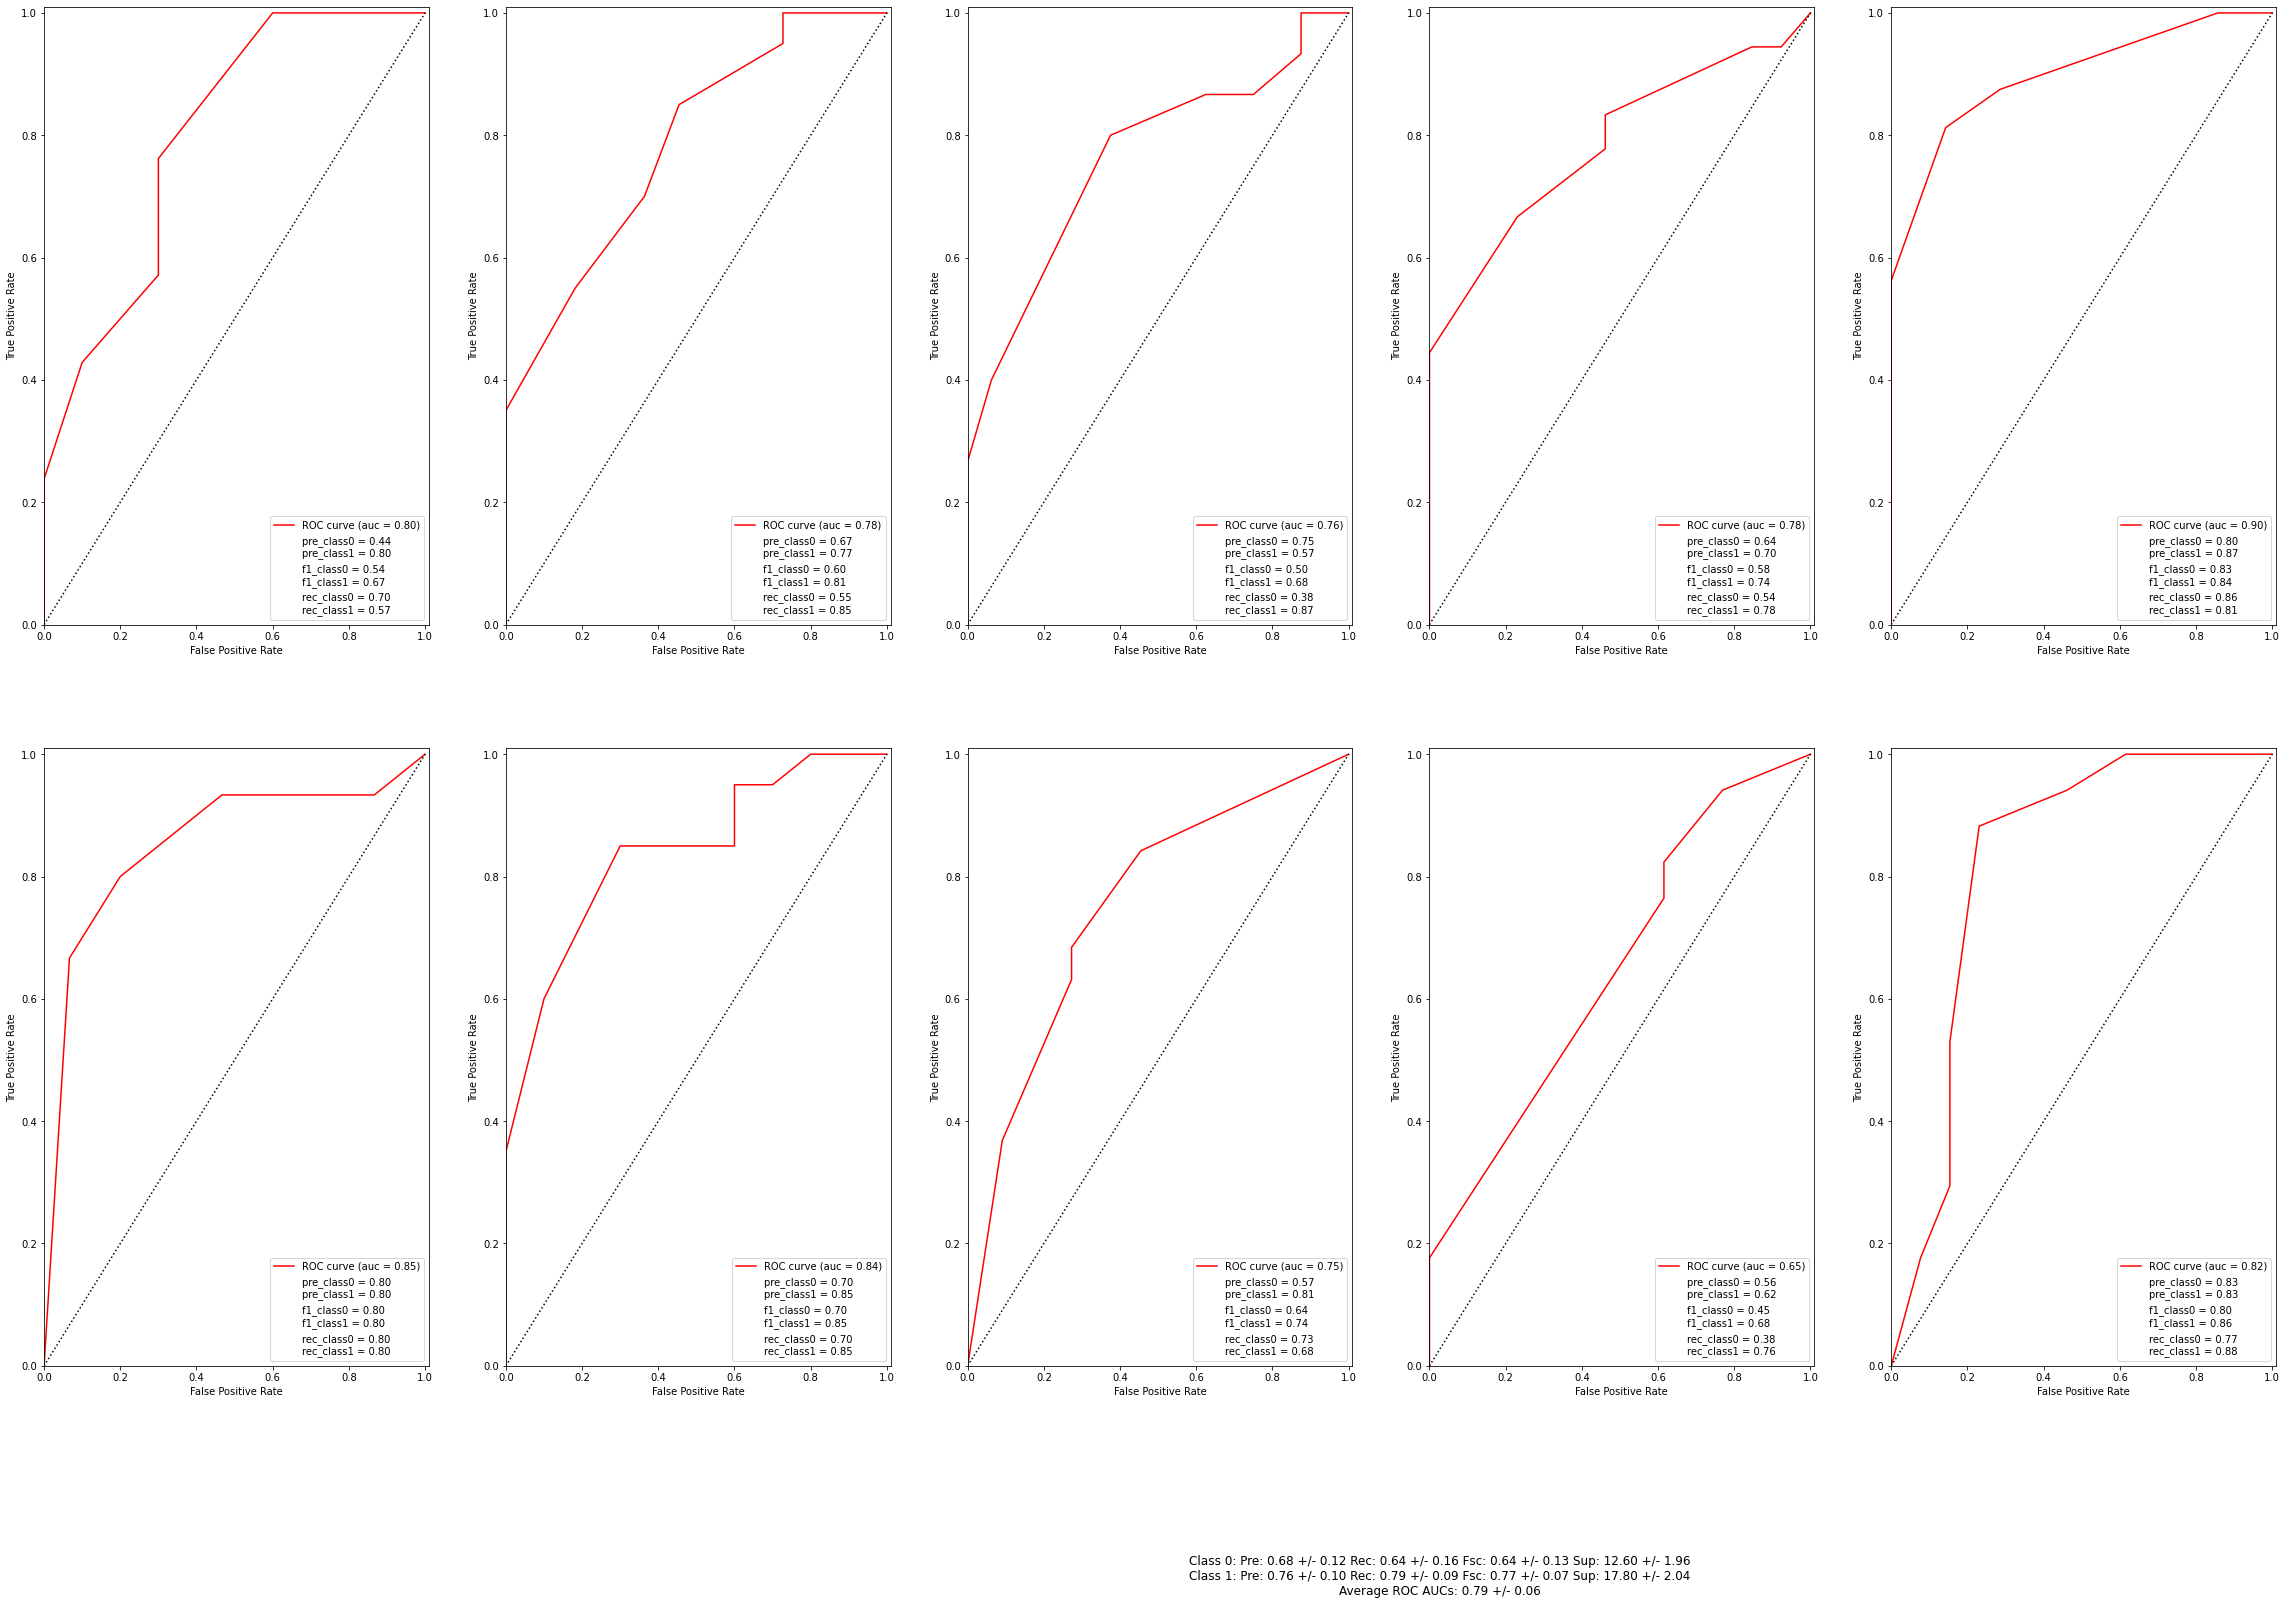


-----
Begin Gaussian Process
-----

Directory Gaussian_Process already exists will be overwritten
----- Gaussian_Process: Fold 0 -----
[18, 19, 26, 34, 48, 57, 72, 84, 93, 100, 106, 114, 116, 138, 142, 163, 171, 178, 179, 201, 211, 213, 220, 224, 244, 252, 264, 272, 286, 298, 303]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  20  21  22  23  24  25  27  28  29  30  31  32  33  35  36  37  38  39
  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78
  79  80  81  82  83  85  86  87  88  89  90  91  92  94  95  96  97  98
  99 101 102 103 104 105 107 108 109 110 111 112 113 115 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 139
 140 141 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 164 165 166 167 168 169 170 172 173 174 175 176 177 180
 181 182 183 184 185 186 187 188 189 190 191 192

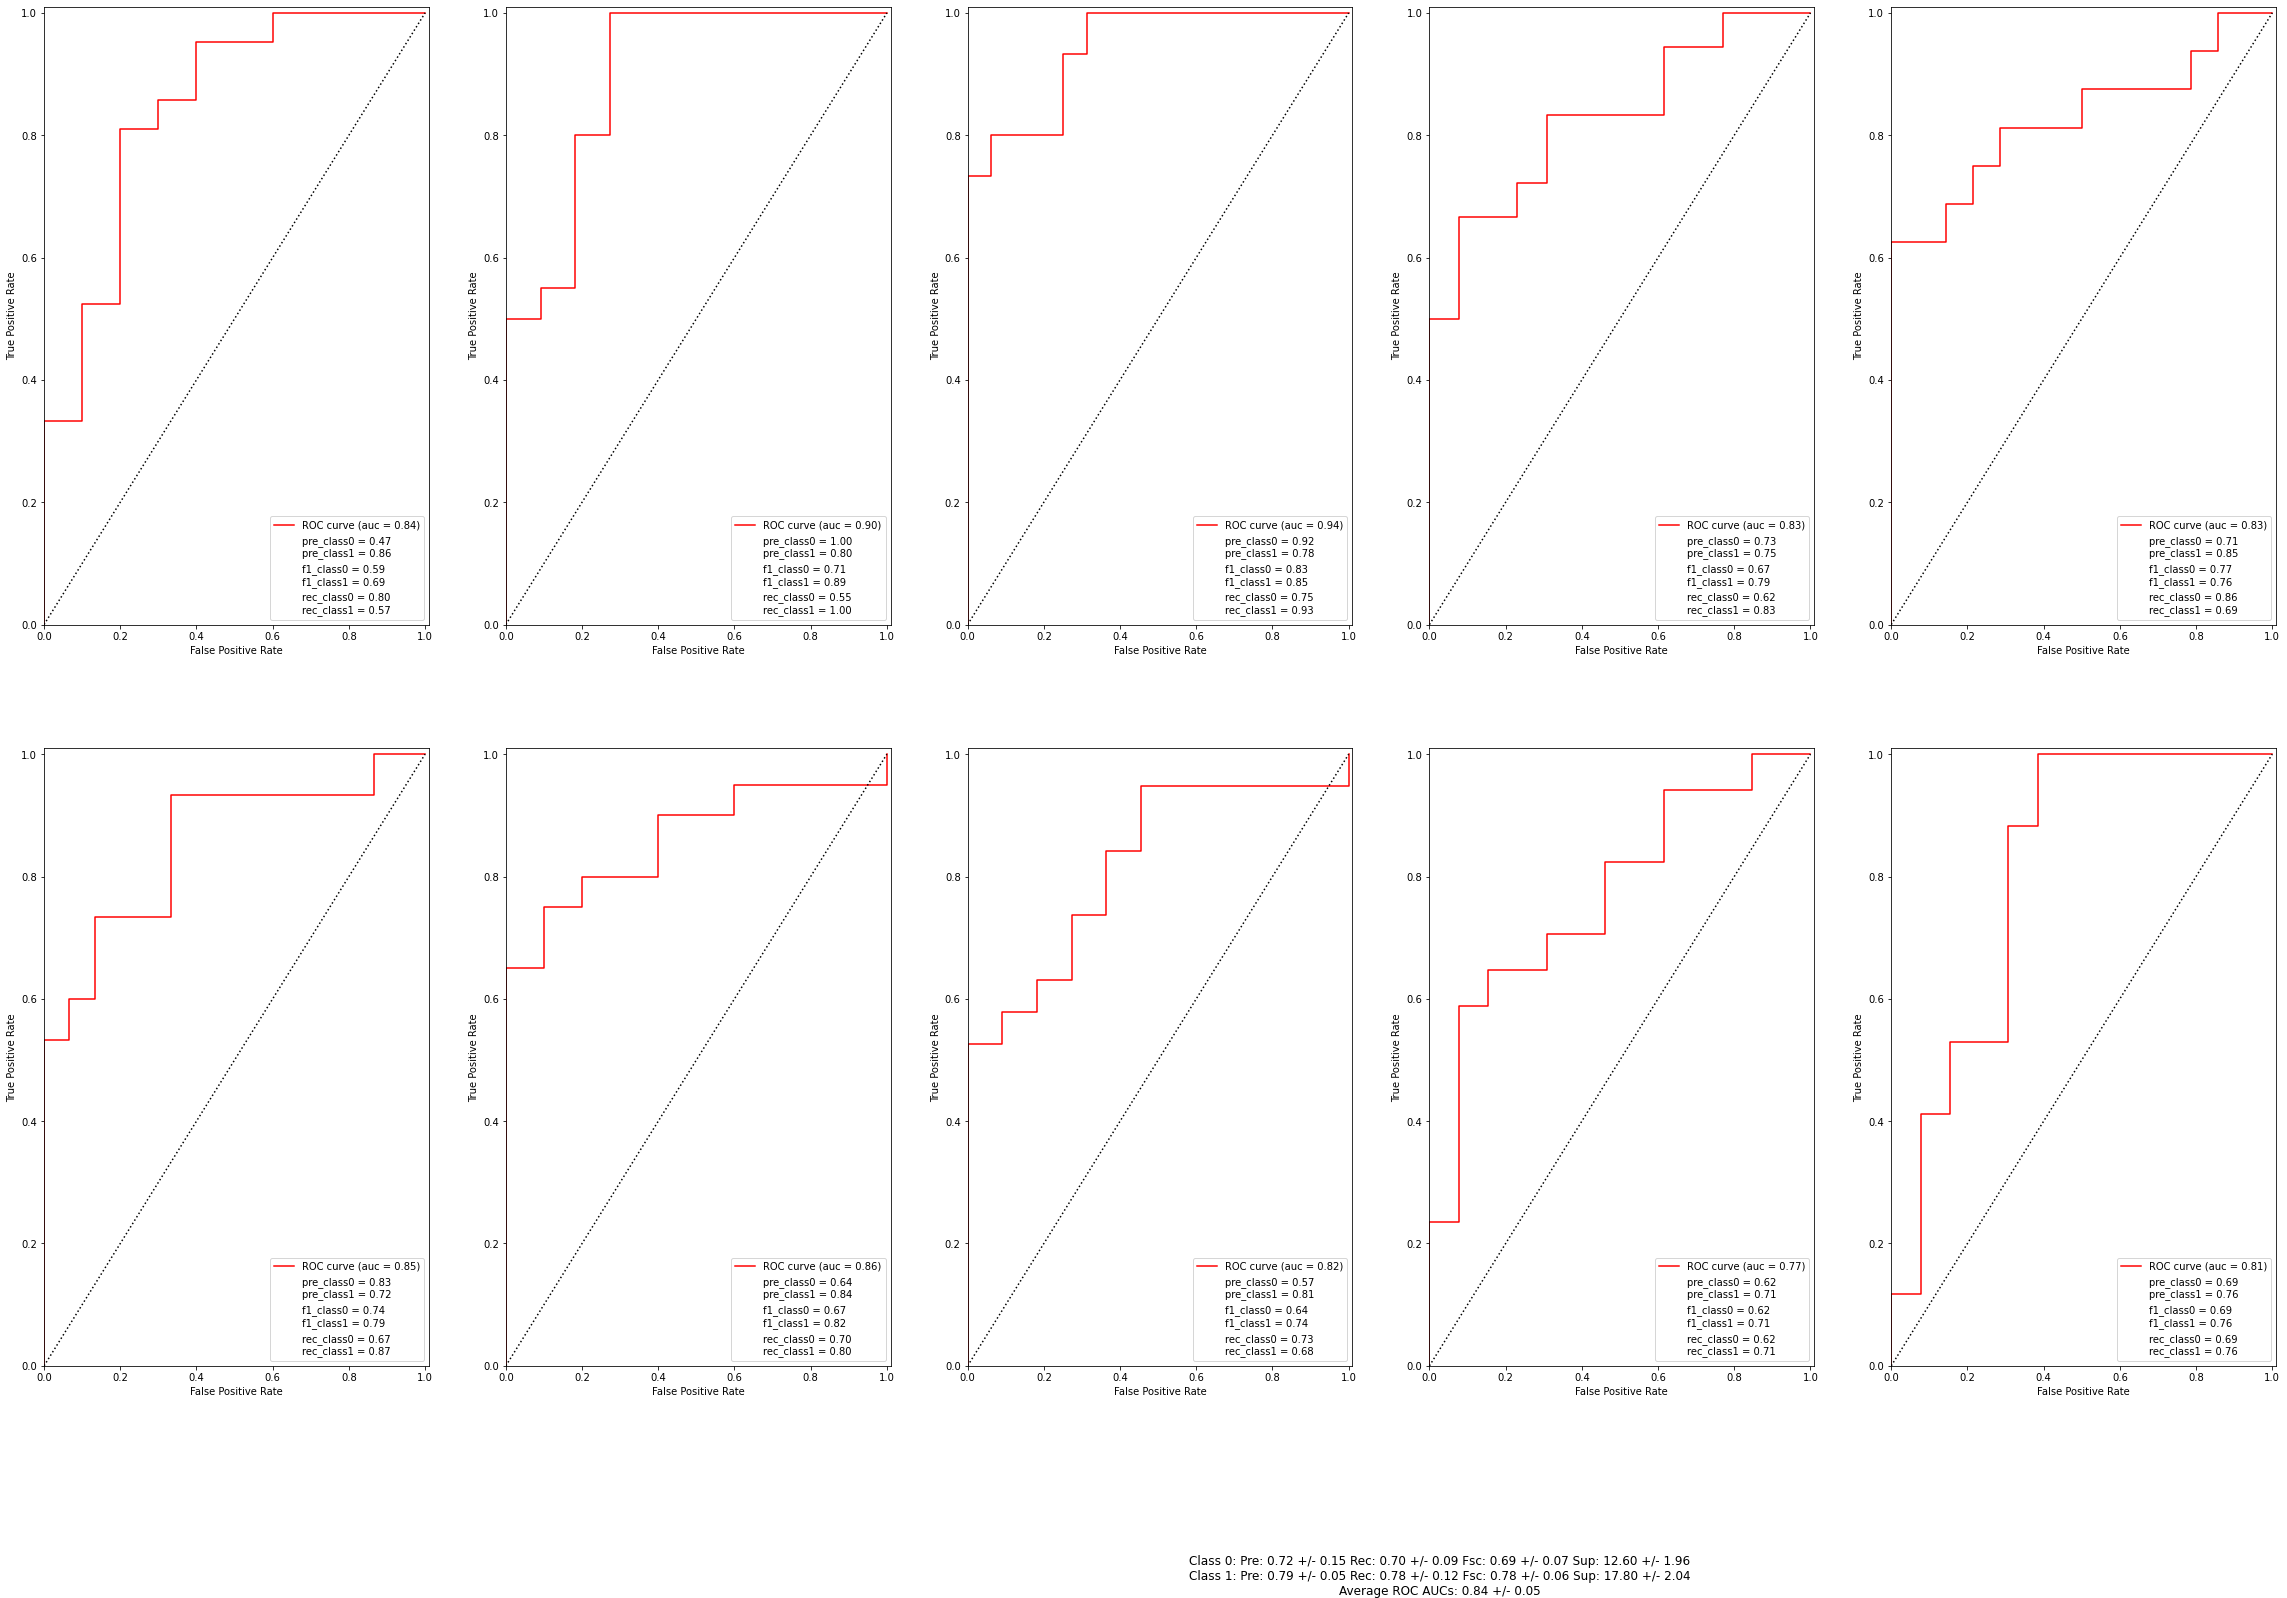


-----
Begin Decision Tree
-----

Directory Decision_Tree already exists will be overwritten
----- Decision_Tree: Fold 0 -----
[18, 19, 26, 34, 48, 57, 72, 84, 93, 100, 106, 114, 116, 138, 142, 163, 171, 178, 179, 201, 211, 213, 220, 224, 244, 252, 264, 272, 286, 298, 303]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  20  21  22  23  24  25  27  28  29  30  31  32  33  35  36  37  38  39
  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78
  79  80  81  82  83  85  86  87  88  89  90  91  92  94  95  96  97  98
  99 101 102 103 104 105 107 108 109 110 111 112 113 115 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 139
 140 141 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 164 165 166 167 168 169 170 172 173 174 175 176 177 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 

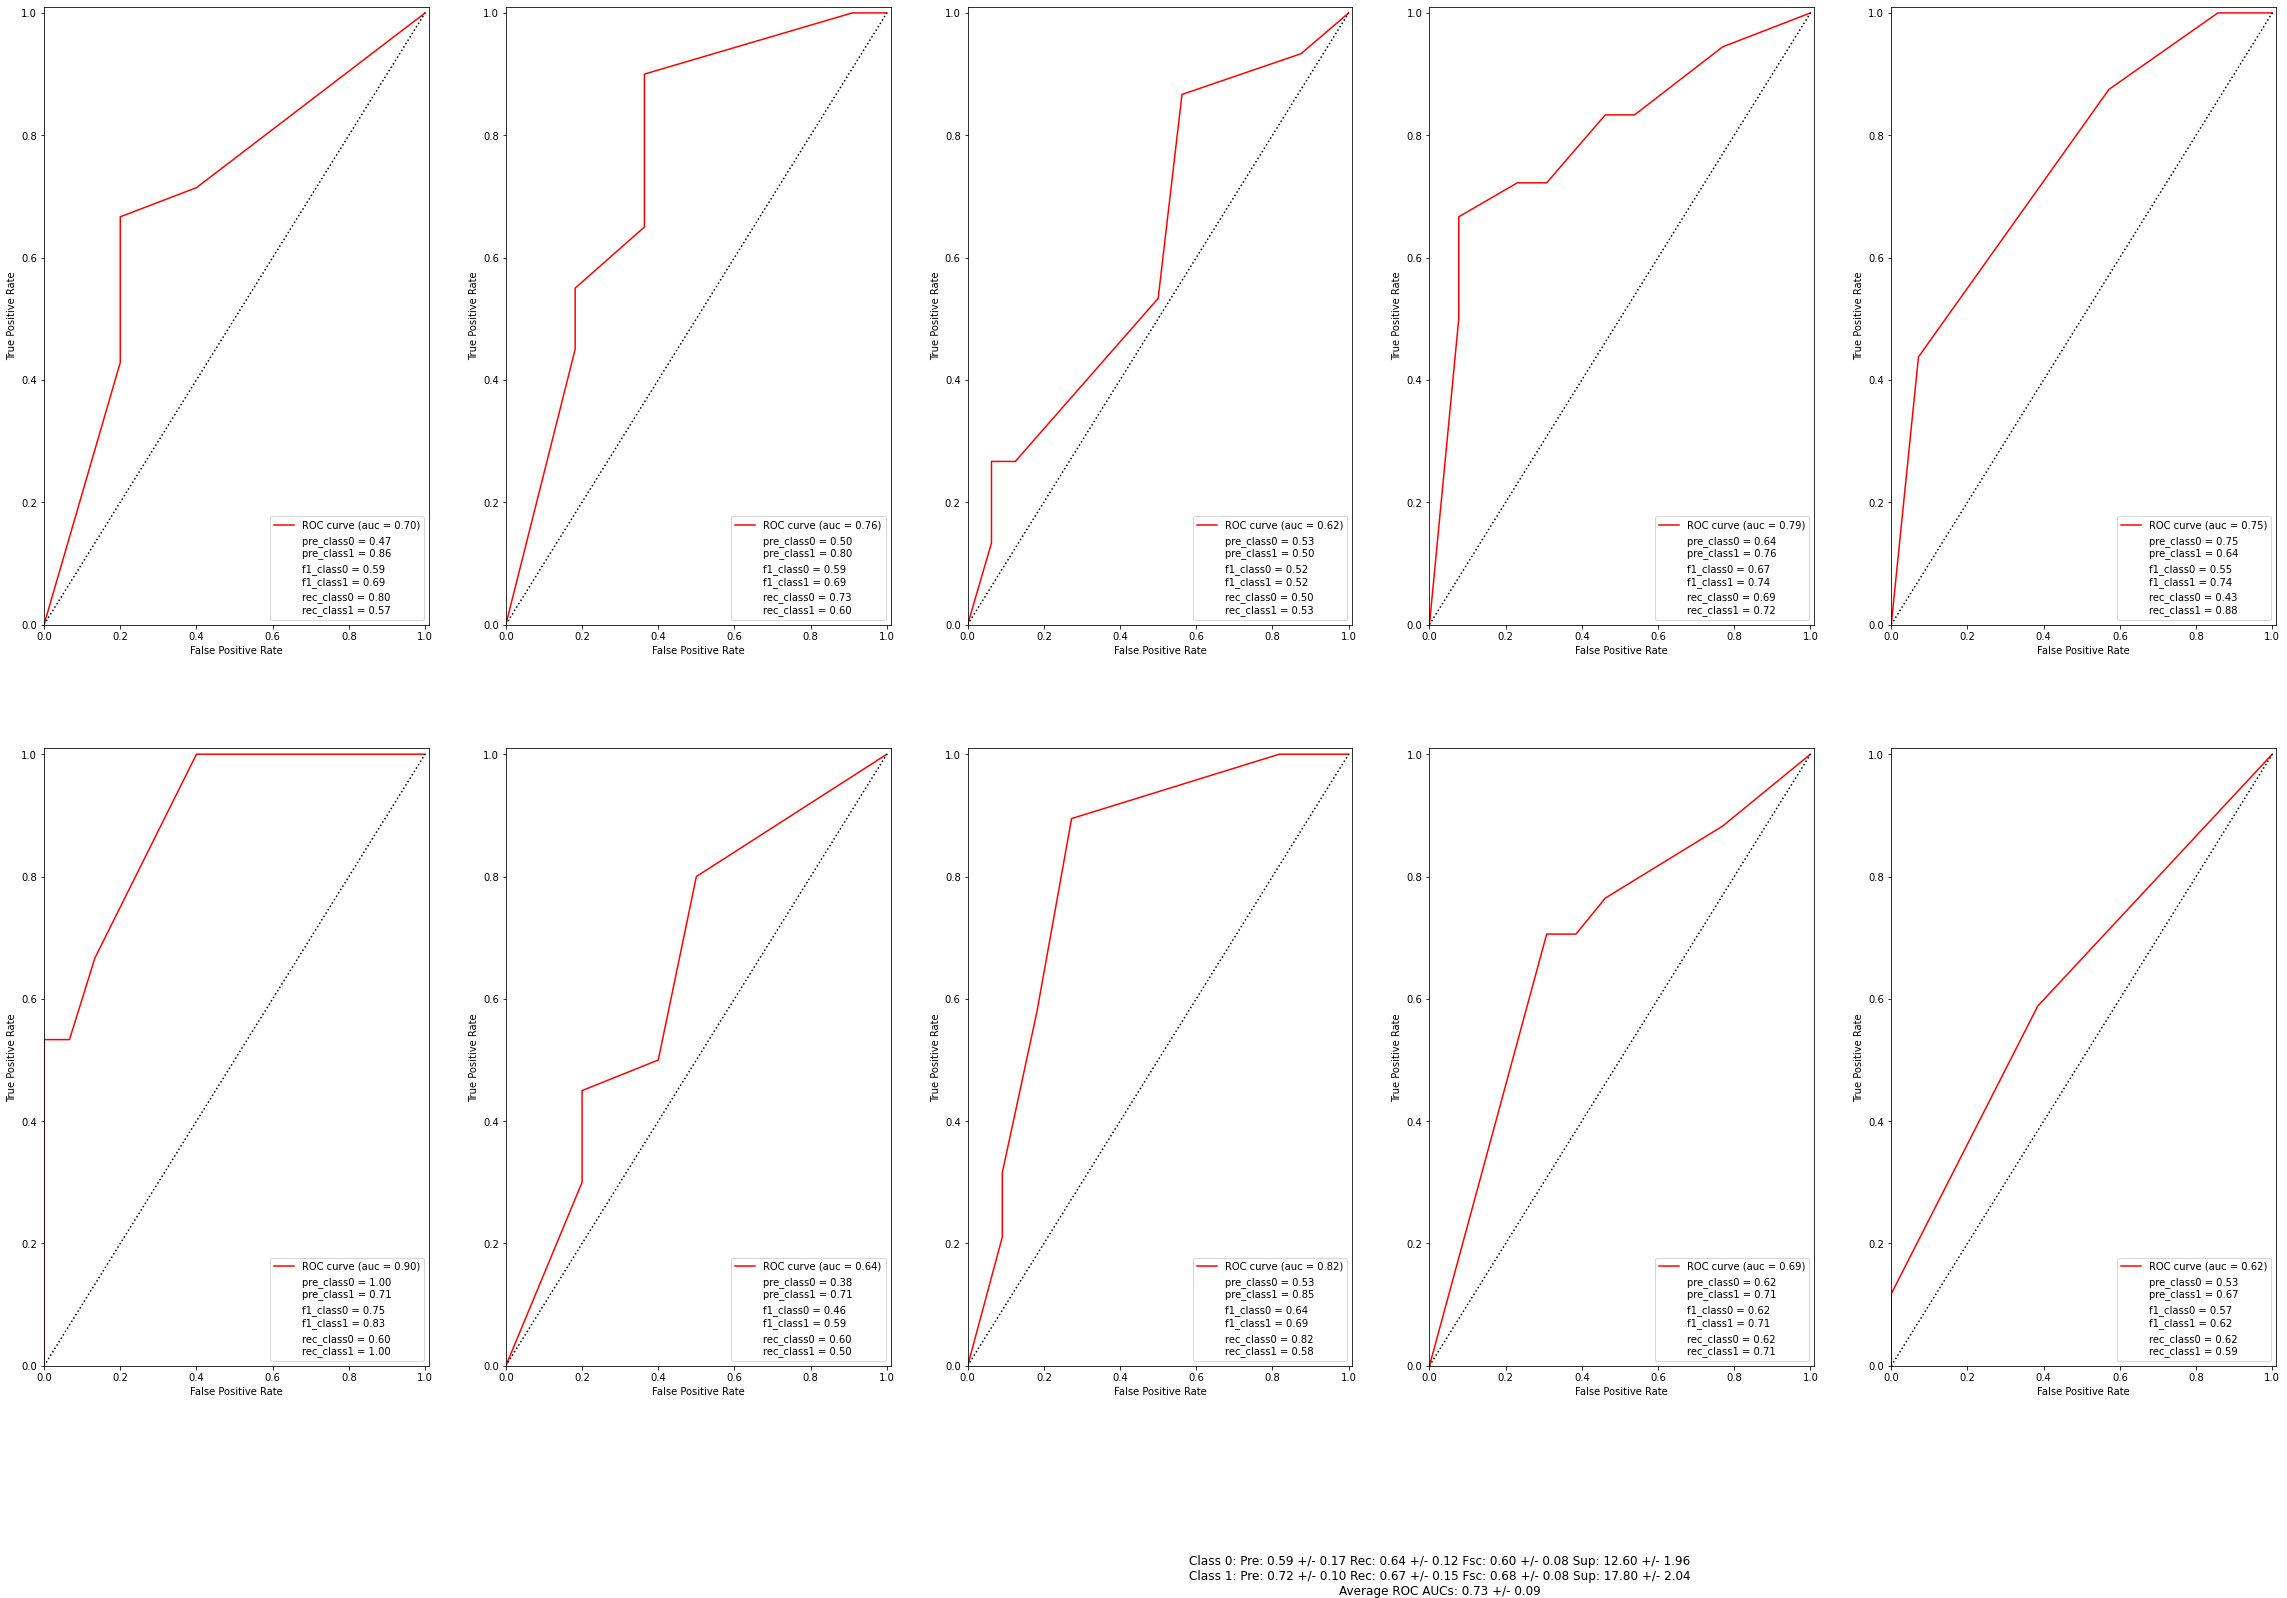


-----
Begin ExtraTreesClassifier
-----

Directory ExtraTreesClassifier already exists will be overwritten
----- ExtraTreesClassifier: Fold 0 -----
[18, 19, 26, 34, 48, 57, 72, 84, 93, 100, 106, 114, 116, 138, 142, 163, 171, 178, 179, 201, 211, 213, 220, 224, 244, 252, 264, 272, 286, 298, 303]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  20  21  22  23  24  25  27  28  29  30  31  32  33  35  36  37  38  39
  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78
  79  80  81  82  83  85  86  87  88  89  90  91  92  94  95  96  97  98
  99 101 102 103 104 105 107 108 109 110 111 112 113 115 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 139
 140 141 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 164 165 166 167 168 169 170 172 173 174 175 176 177 180
 181 182 183 184 185 186 187 188 189

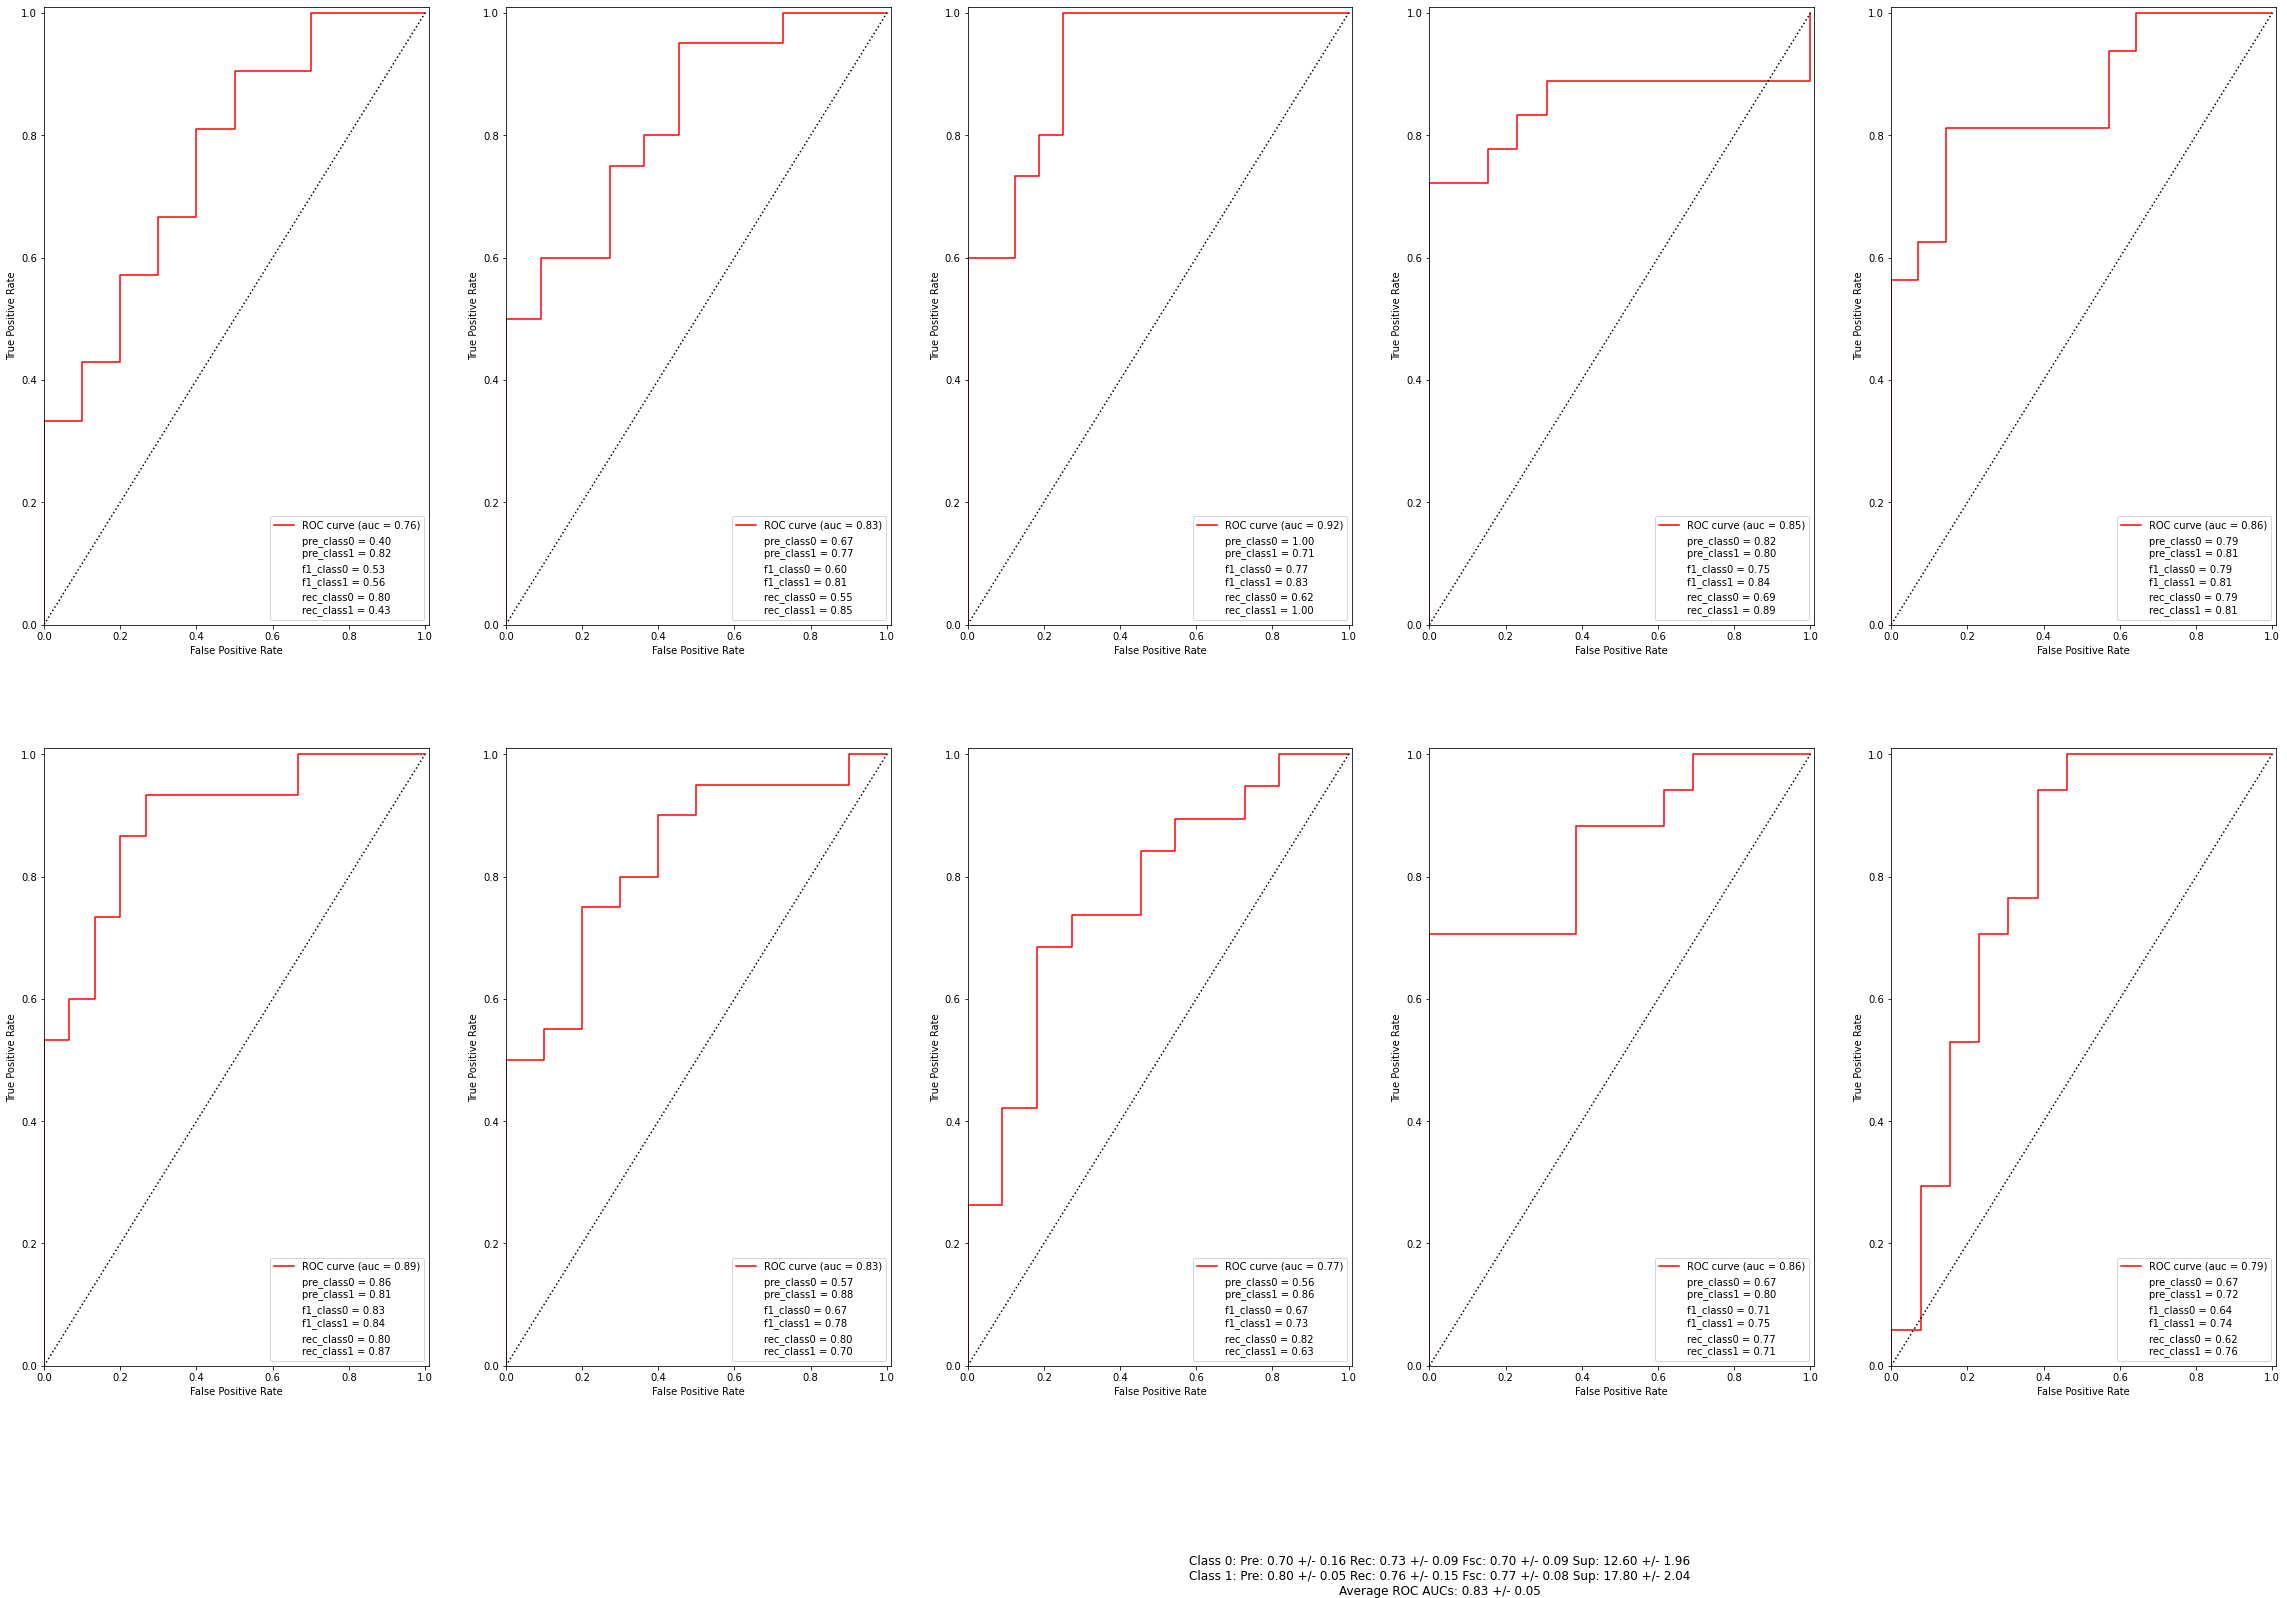


-----
Begin AdaBoost
-----

Directory AdaBoost already exists will be overwritten
----- AdaBoost: Fold 0 -----
[18, 19, 26, 34, 48, 57, 72, 84, 93, 100, 106, 114, 116, 138, 142, 163, 171, 178, 179, 201, 211, 213, 220, 224, 244, 252, 264, 272, 286, 298, 303]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  20  21  22  23  24  25  27  28  29  30  31  32  33  35  36  37  38  39
  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78
  79  80  81  82  83  85  86  87  88  89  90  91  92  94  95  96  97  98
  99 101 102 103 104 105 107 108 109 110 111 112 113 115 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 139
 140 141 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 164 165 166 167 168 169 170 172 173 174 175 176 177 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198

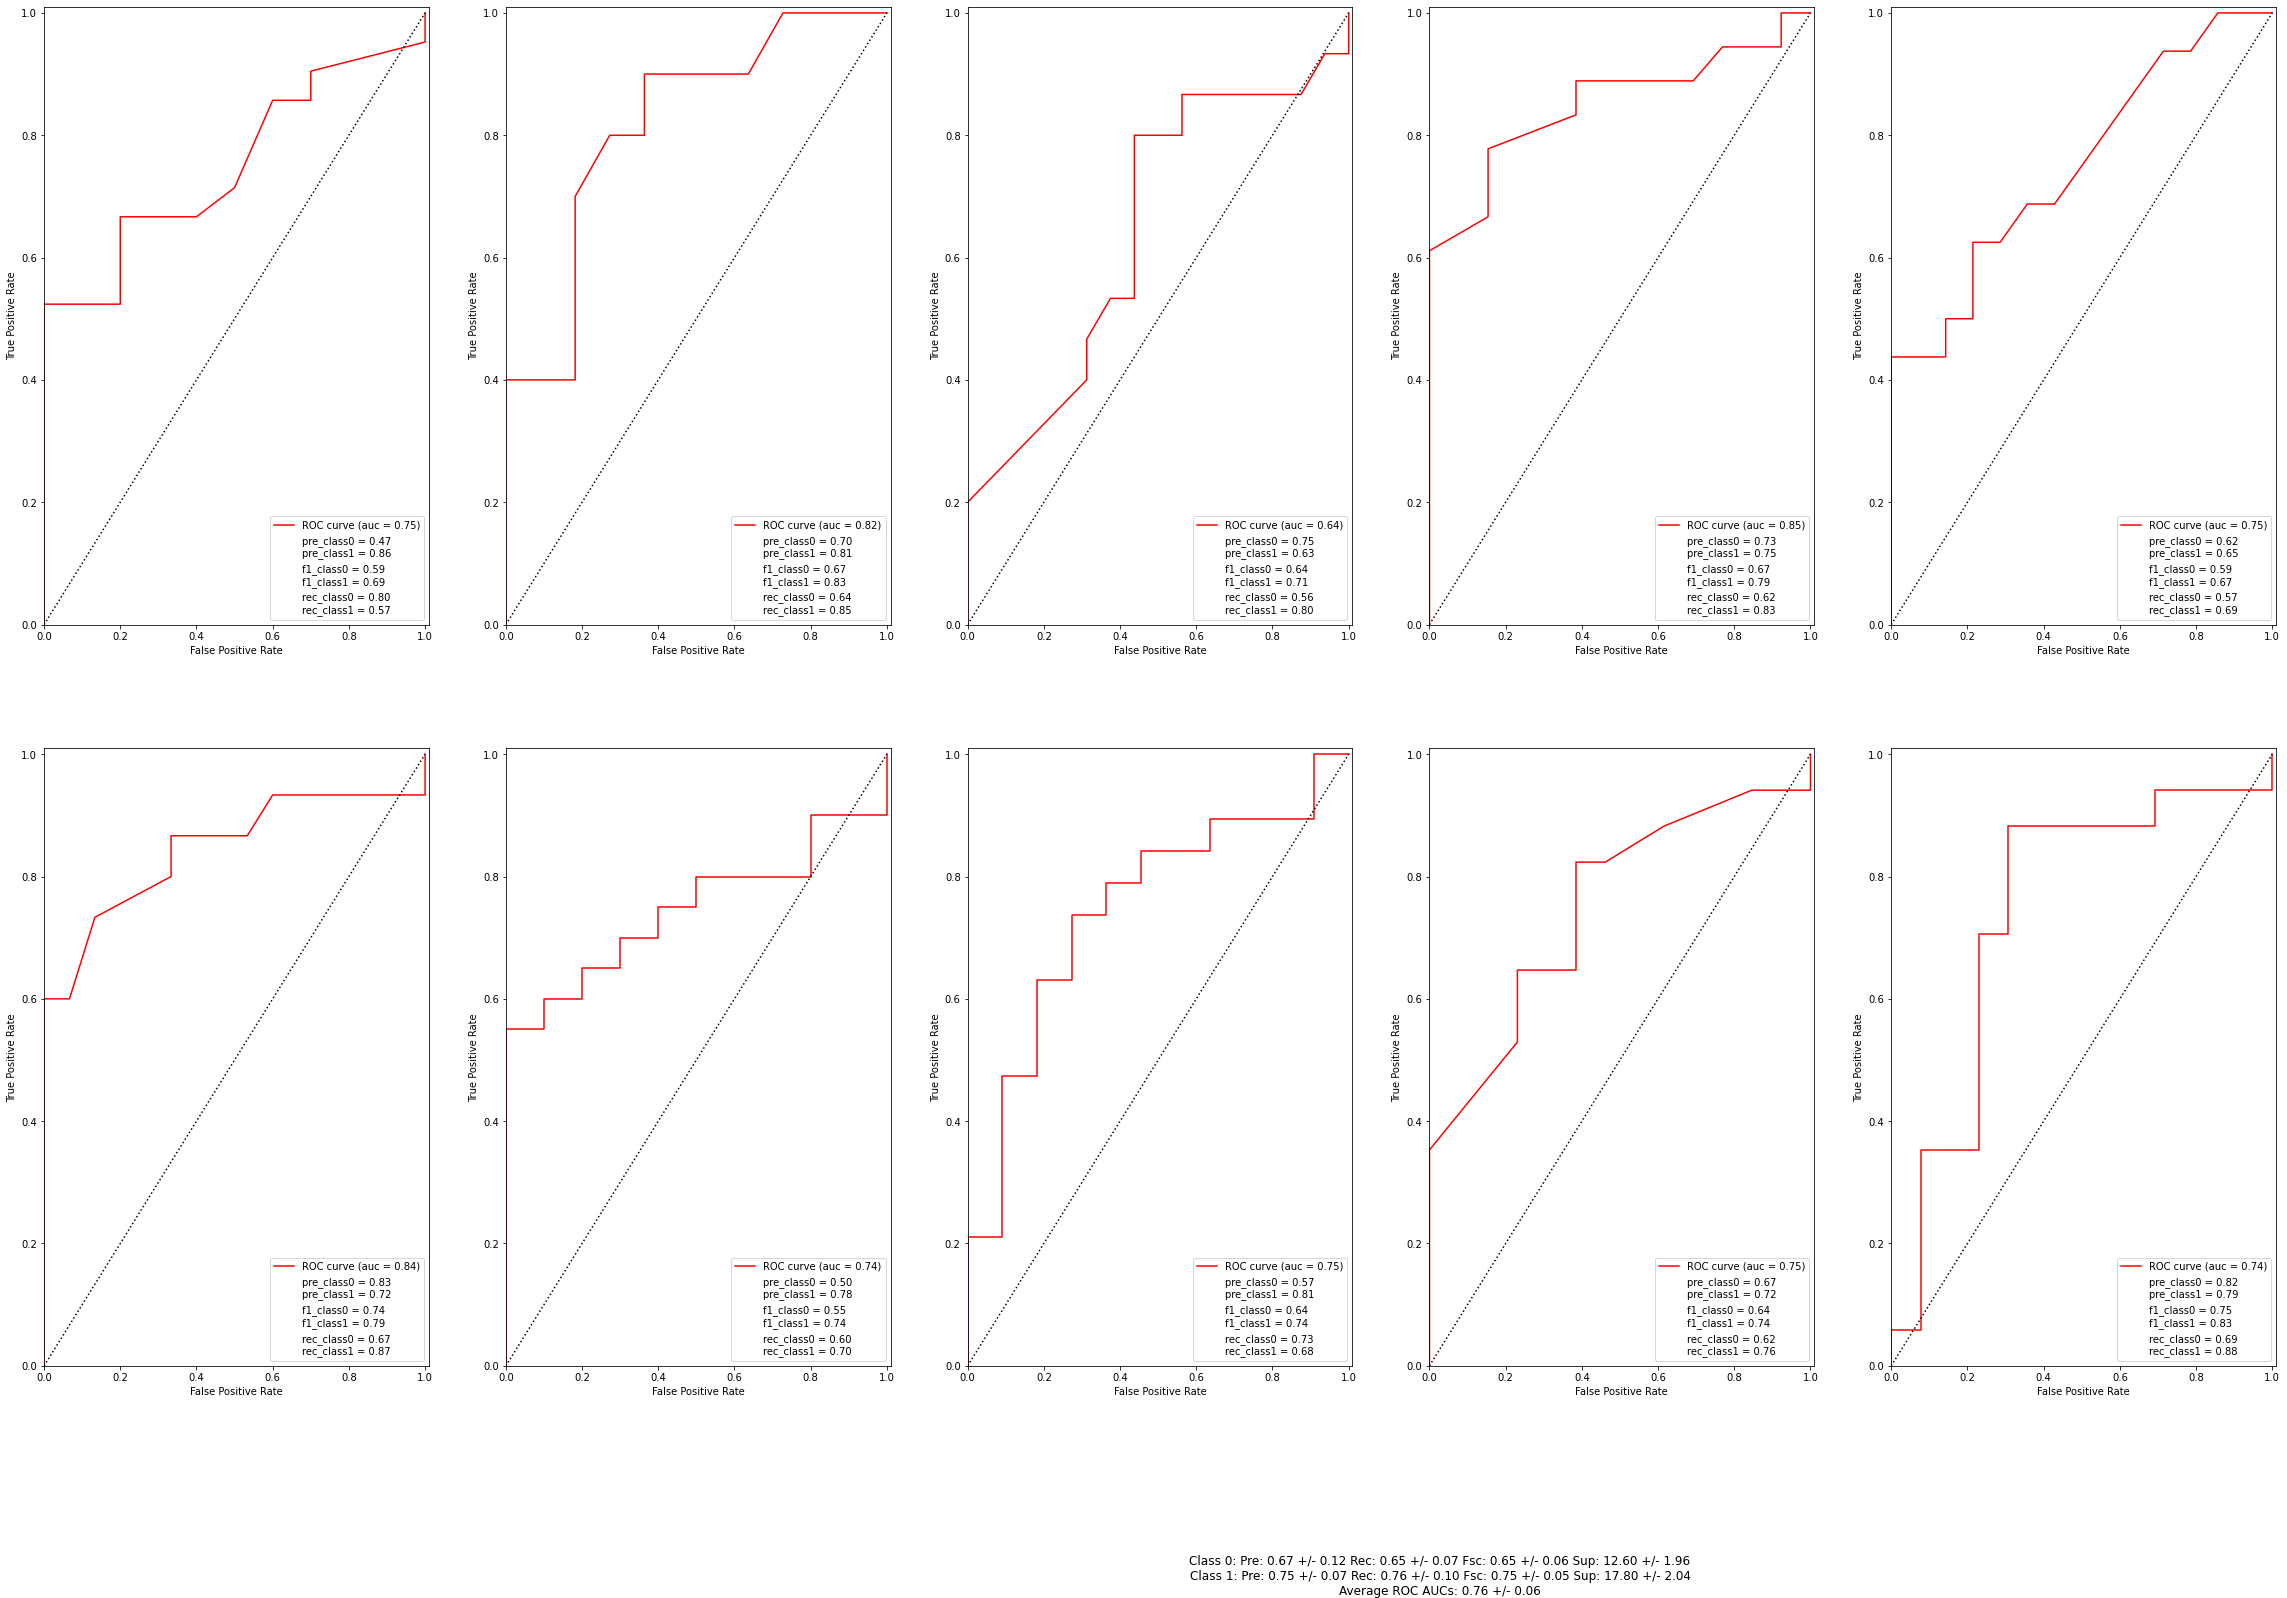


-----
Begin Logistic Regression
-----

Directory Logistic_Regression already exists will be overwritten
----- Logistic_Regression: Fold 0 -----
[18, 19, 26, 34, 48, 57, 72, 84, 93, 100, 106, 114, 116, 138, 142, 163, 171, 178, 179, 201, 211, 213, 220, 224, 244, 252, 264, 272, 286, 298, 303]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  20  21  22  23  24  25  27  28  29  30  31  32  33  35  36  37  38  39
  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78
  79  80  81  82  83  85  86  87  88  89  90  91  92  94  95  96  97  98
  99 101 102 103 104 105 107 108 109 110 111 112 113 115 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 139
 140 141 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 164 165 166 167 168 169 170 172 173 174 175 176 177 180
 181 182 183 184 185 186 187 188 189 19

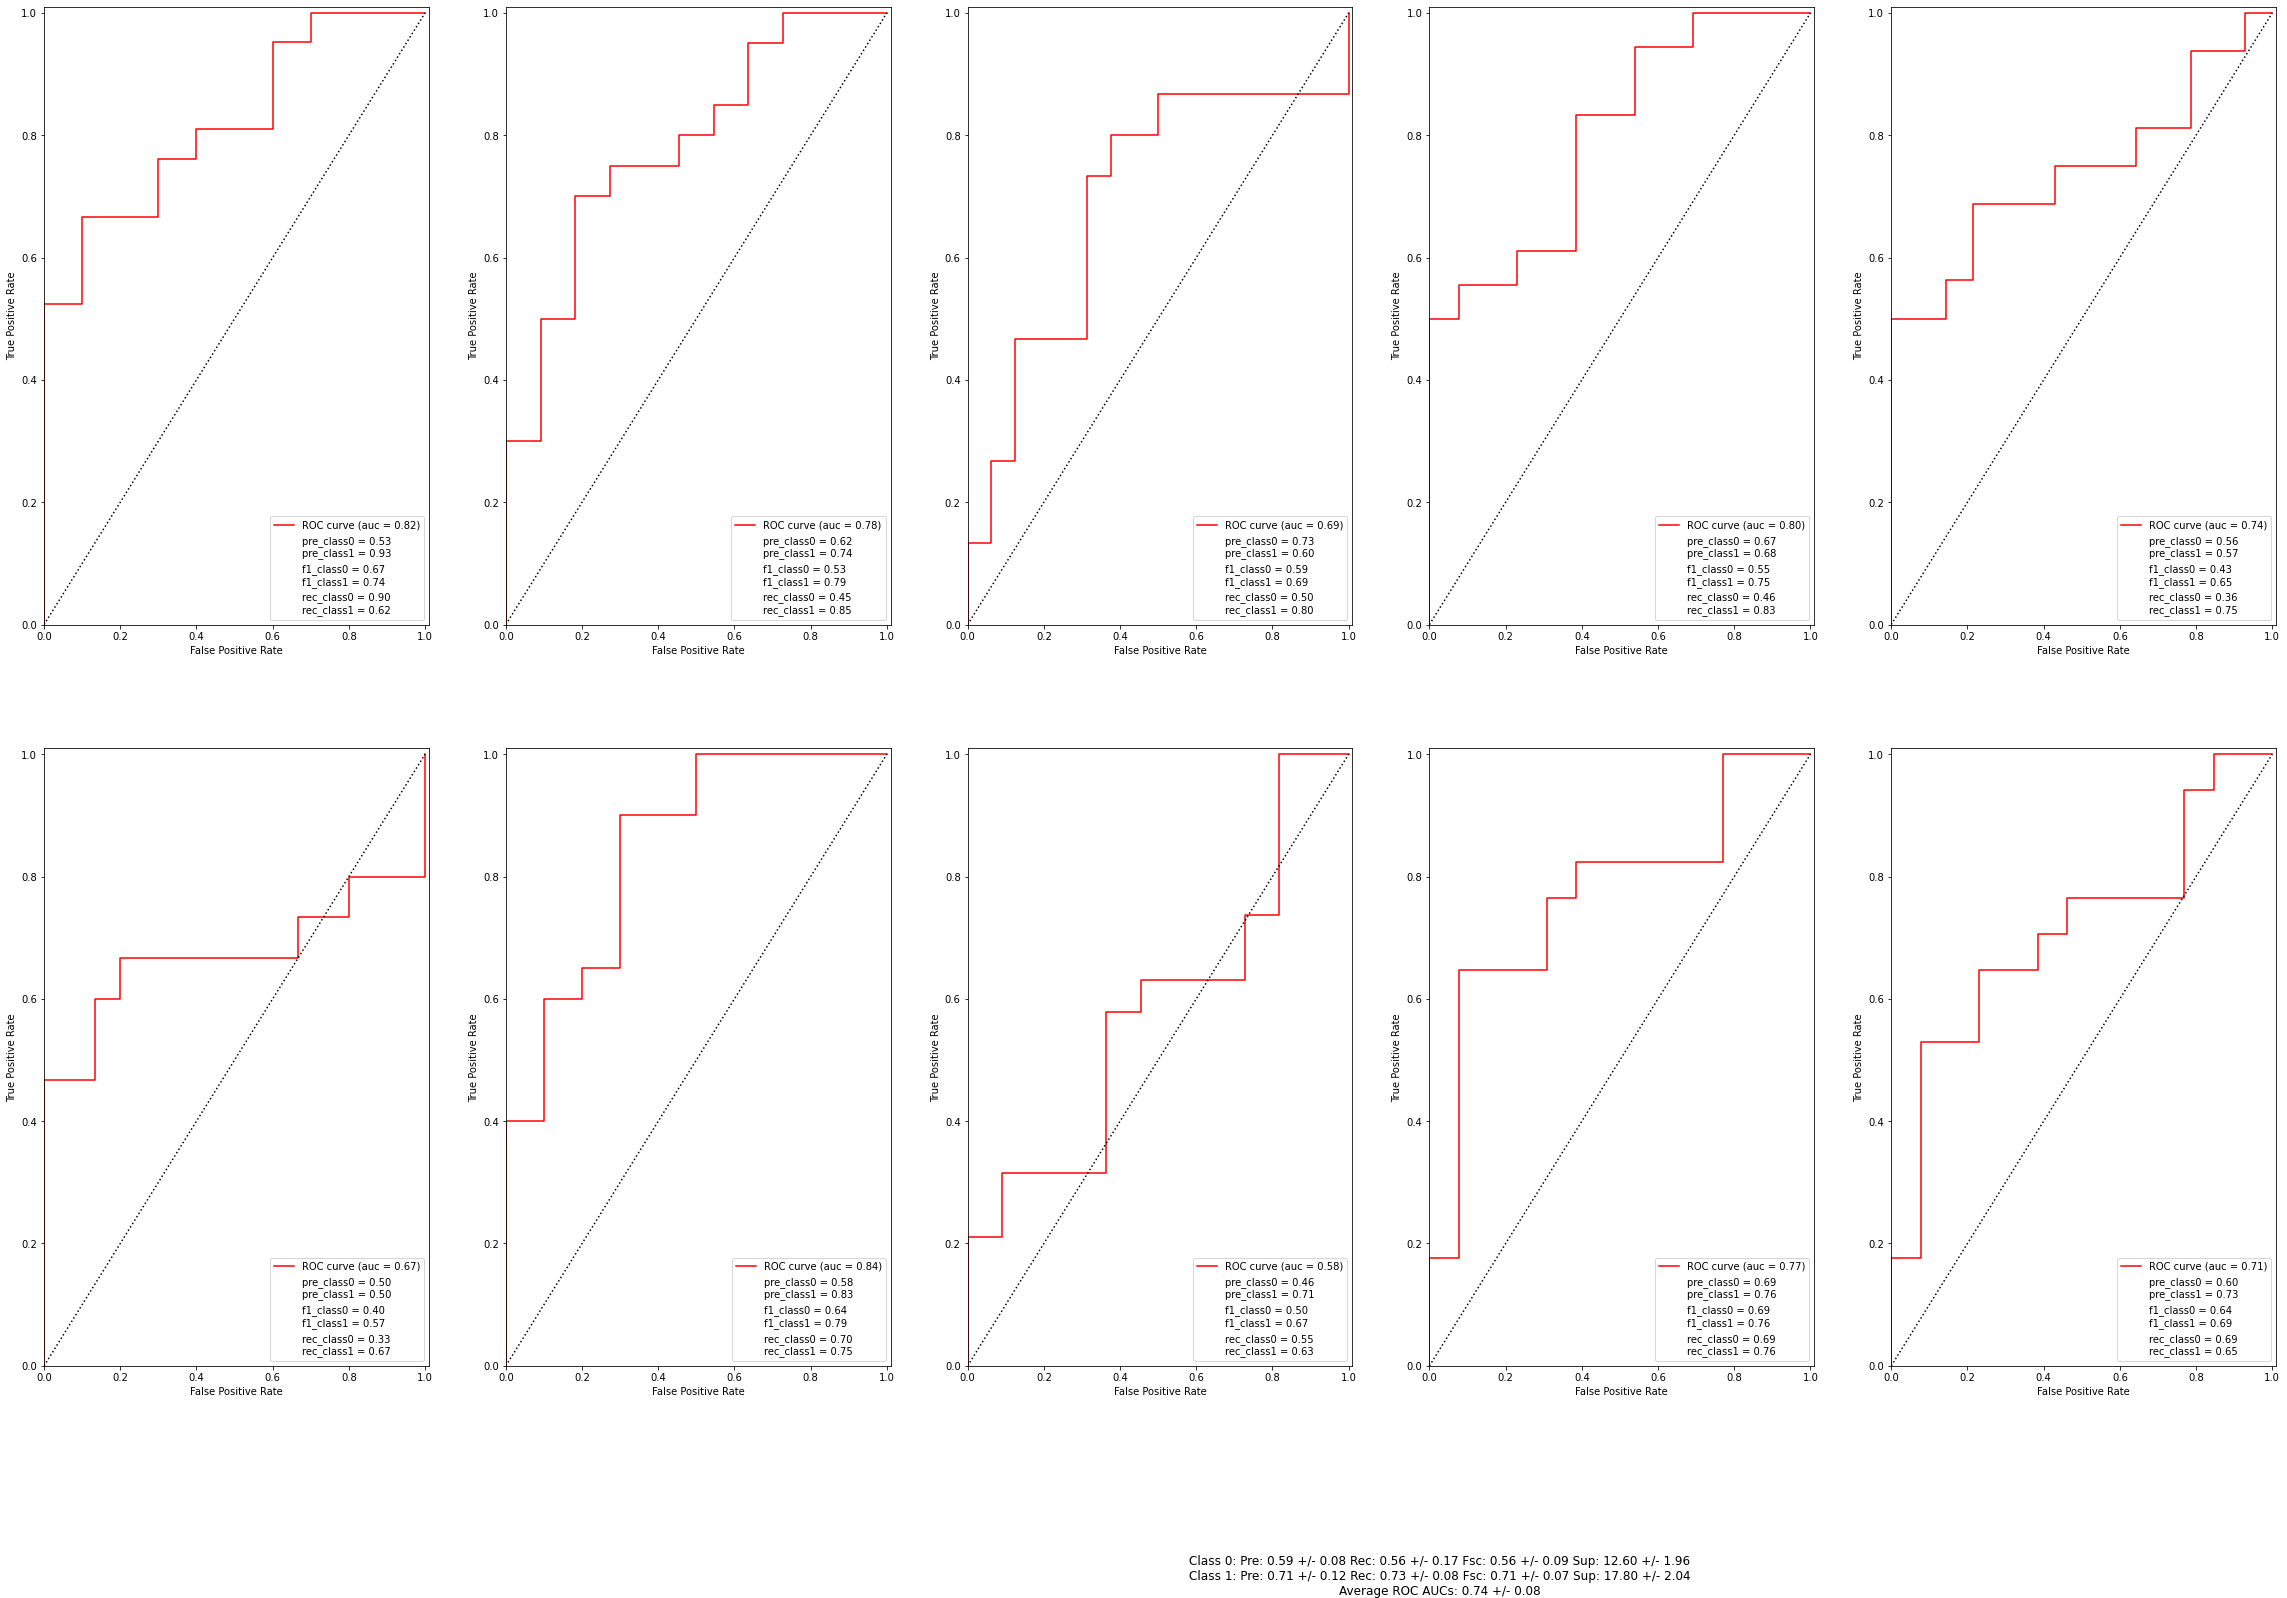

In [63]:
cwf.kfold_test_classifiers_with_optimization(features_df, class_targets_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=True, cv=5, n_repeats=10, smiles=None, names=None,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

In [65]:
directory_names = cwf.directory_names(kfold_clf_names)

In [66]:
directory_names

['Nearest_Neighbors',
 'Gaussian_Process',
 'Decision_Tree',
 'ExtraTreesClassifier',
 'AdaBoost',
 'Logistic_Regression']

## Analyses the output over all folds and predictions therefore for all moleucles
The next cell reads in the predictions from each fold (n_repeats max_folds should = n_repeats).


Nearest_Neighbors
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_nearest_neighbors_morderd.png
['ddg_nearest_neighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 80, 'fp': 46, 'fn': 39, 'tp': 139}
[[ 80  46]
 [ 39 139]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Gaussian_Process
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_gaussian_process_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 88, 'fp': 38, 'fn': 39, 'tp': 139}
[[ 88  38]
 [ 39 139]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Decision_Tree
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_decision_tree_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 79, 'fp': 47, 'fn': 61, 'tp': 117}
[[ 79  47]
 [ 61 117]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_extratreesclassifier_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 91, 'fp': 35, 'fn': 44, 'tp': 134}
[[ 91  35]
 [ 44 134]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_adaboost_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 81, 'fp': 45, 'fn': 43, 'tp': 135}
[[ 81  45]
 [ 43 135]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Logistic_Regression
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_logistic_regression_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png', 'ddg_logistic_regression_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 69, 'fp': 57, 'fn': 48, 'tp': 130}
[[ 69  57]
 [ 48 130]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearest neighbors      &  0.720395 &     0.780899 &     0.634921 &  0.419702 &   0.751351 &  0.704137 \\
gaussian process       &  0.746711 &     0.780899 &     0.698413 &  0.478768 &   0.785311 &  0.738505 \\
decision tree          &  0.644737 &     0.657303 &     0.626984 &  0.280975 &   0.713415 &  0.641965 \\
extra trees classifier &  0.740132 &     0.752809 &     0.722222 &  0.470985 &   0.792899 &  0.737357 \\
adaboost               &  0.710526 &     0.758427 &     0.642857 &  0.402254 &   0.750000 &  0.698255 \\
logistic regression    &  0.654605 &     0.730337 &     0.547619 &  0.281422 &   0.695187 &  0.632413 \\
\bottomrule
\end{tabular}



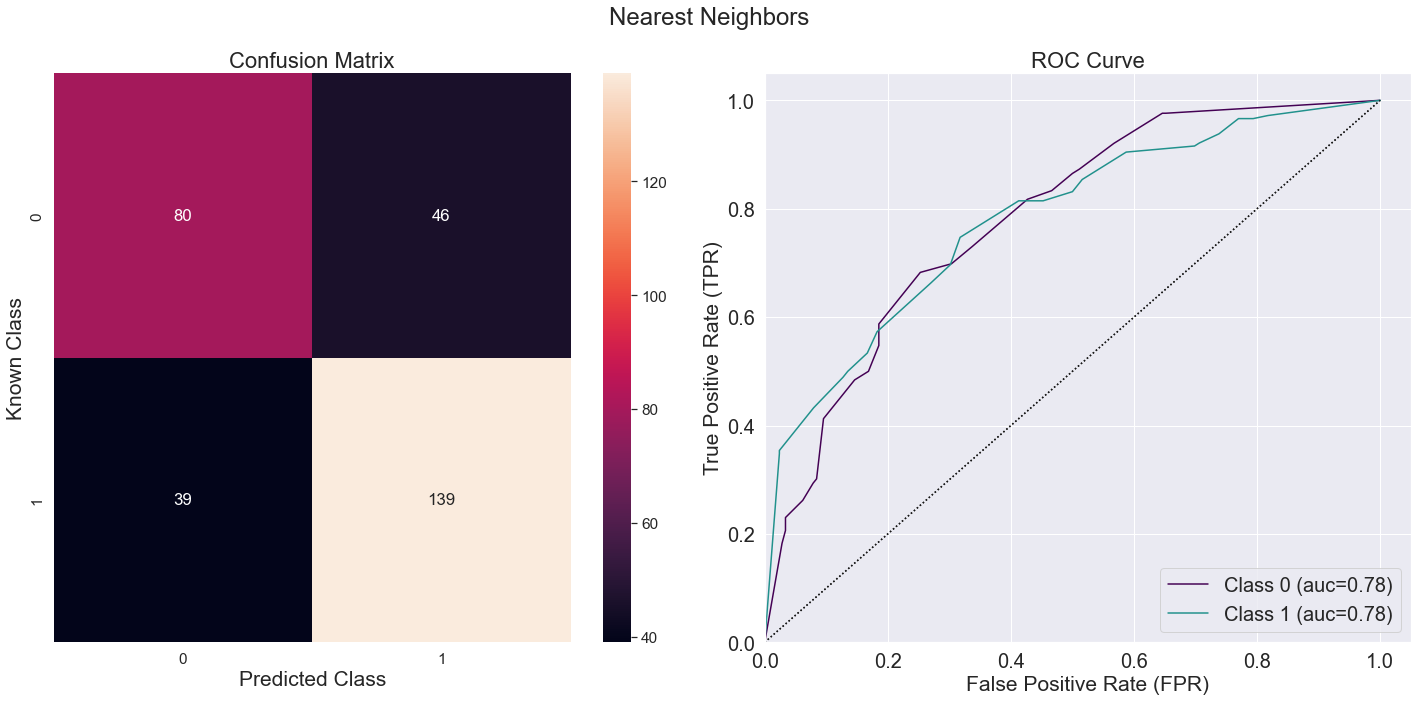

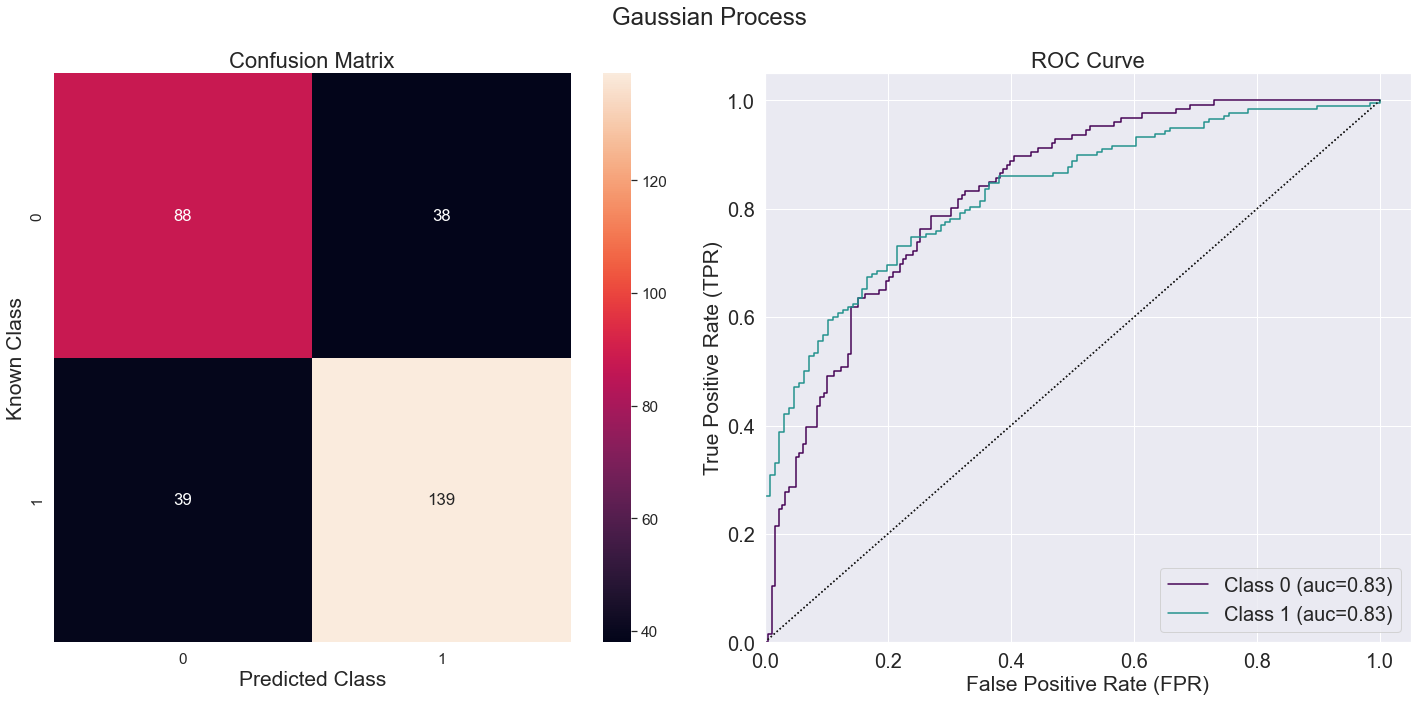

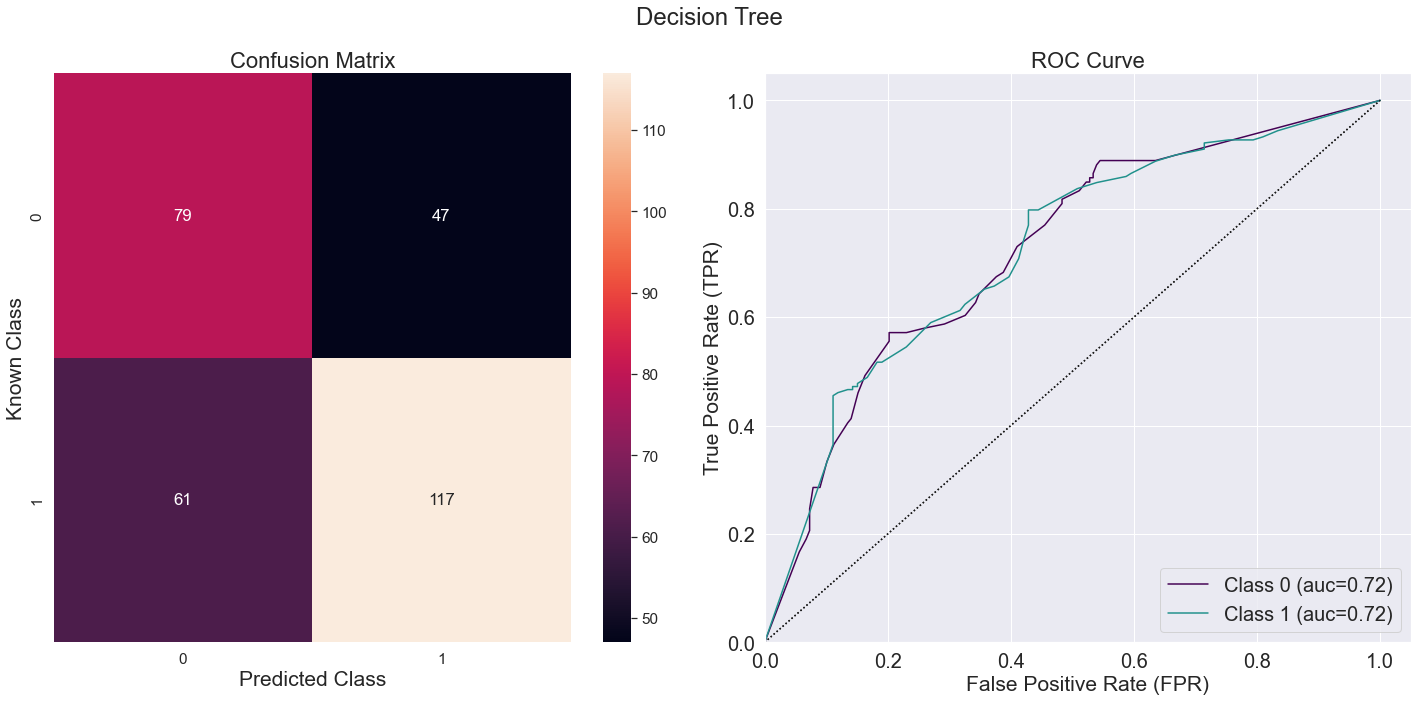

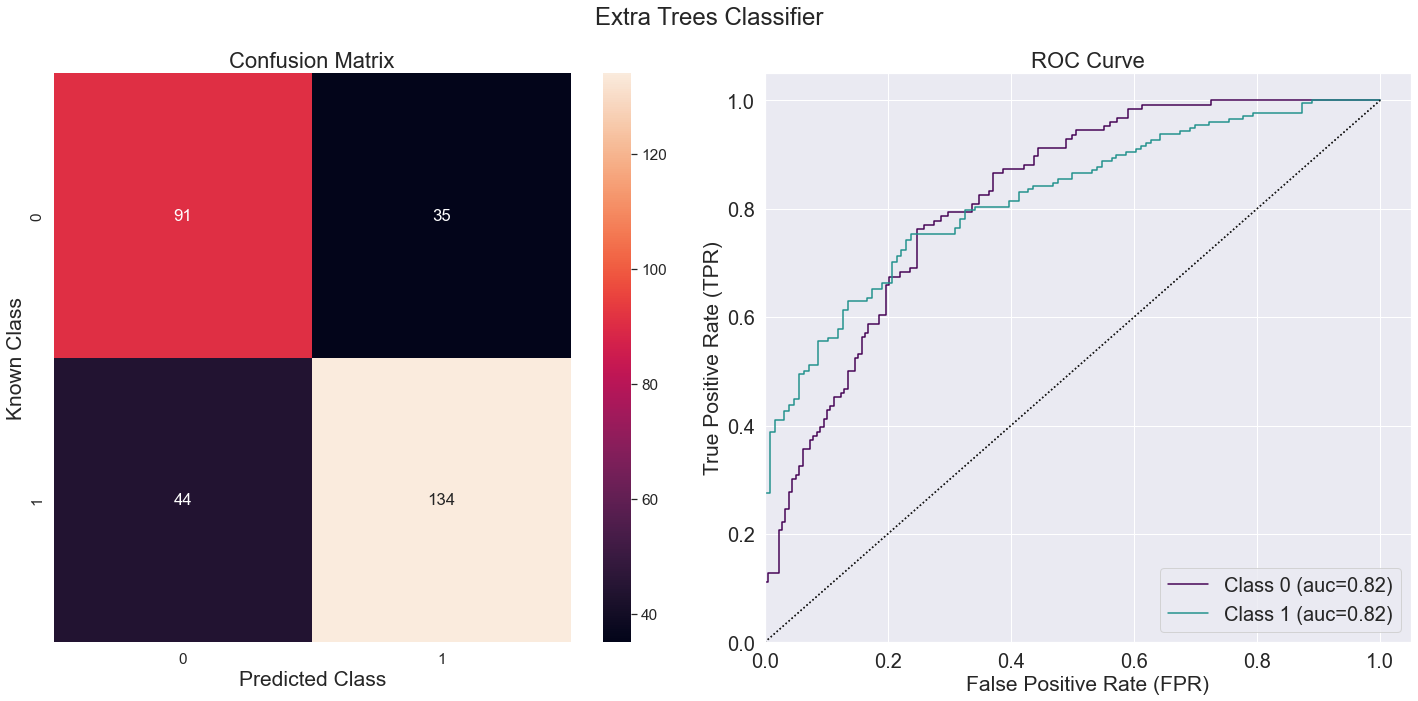

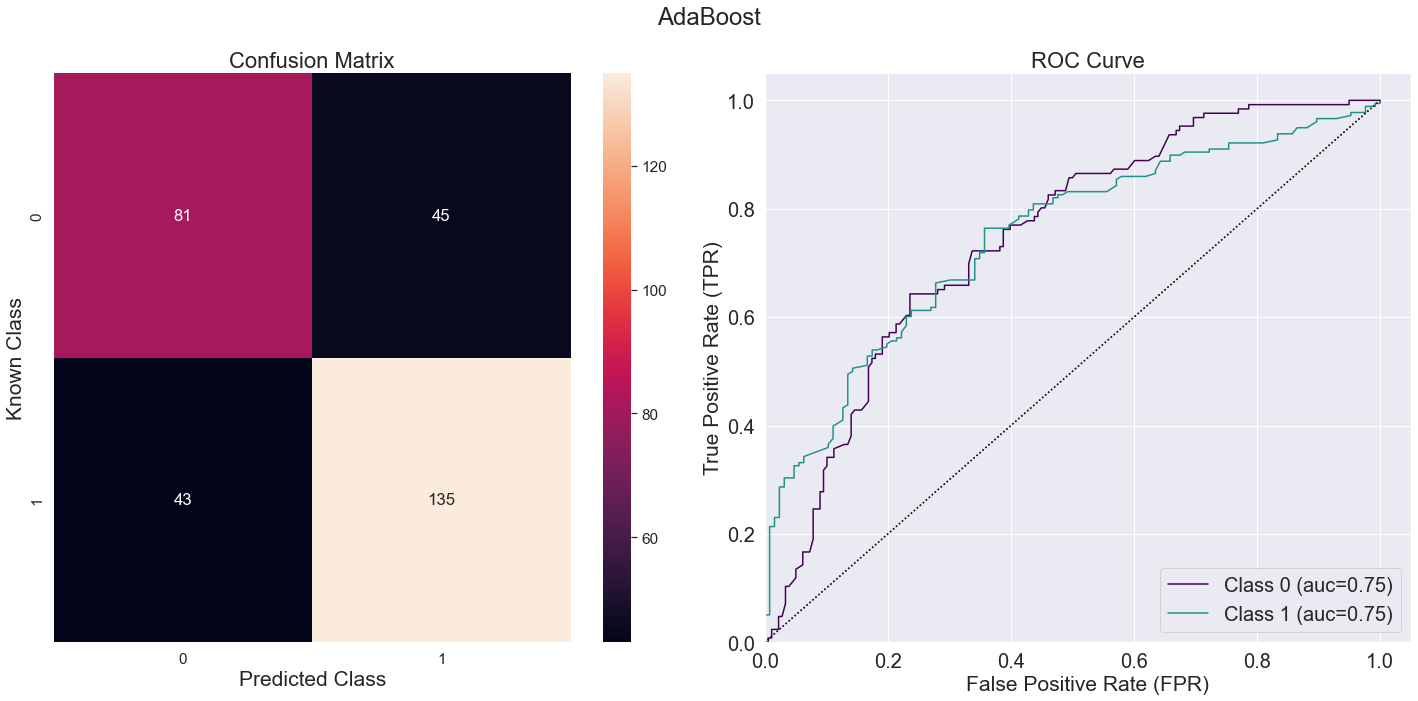

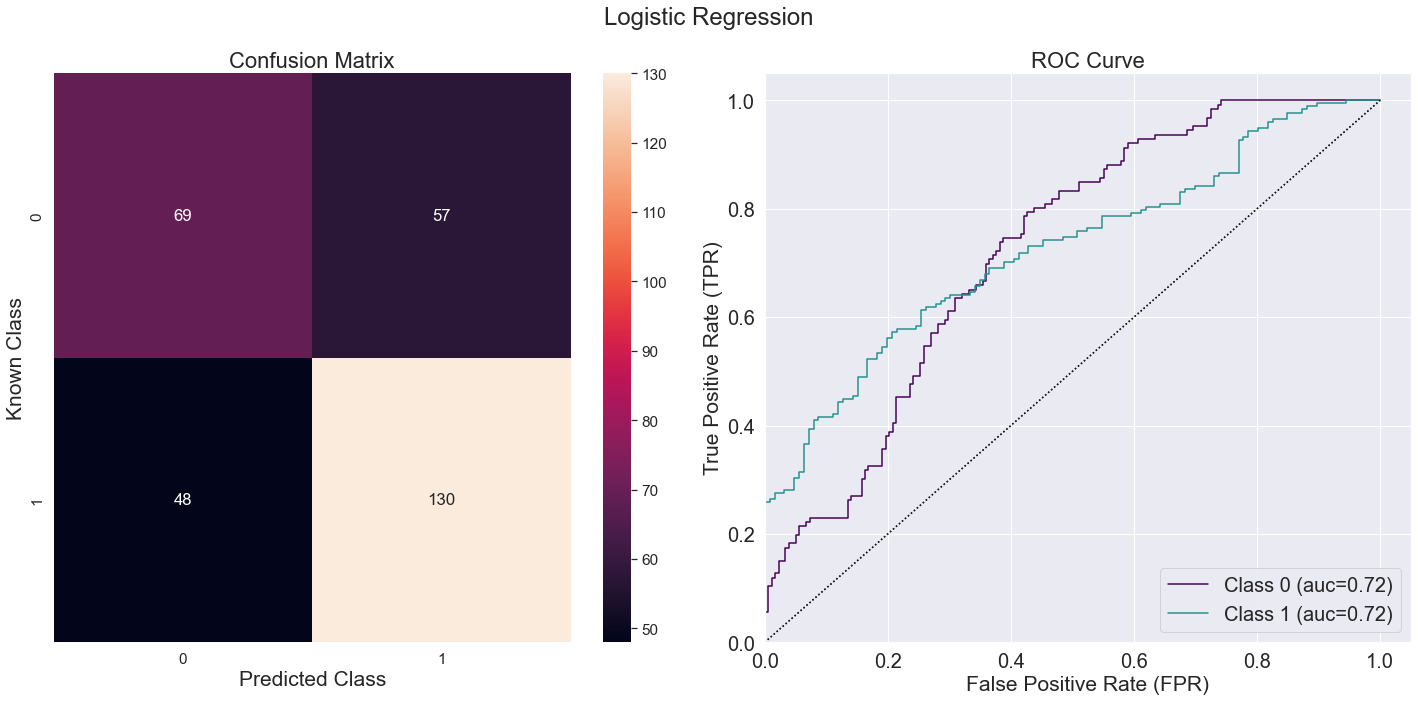

In [69]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=10)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [70]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600


# Machine Learning
## Now first we split dataset into training set and test set

In [17]:
data = pd.read_csv("../dataset_initial_look/df_all_substructure_onehot.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [18]:
data['logec50'] = data['logec50'].fillna('N')

In [19]:
len(data['year'].unique())

11

In [20]:
# sort by year
data = data.sort_values(by=['year'])

In [21]:
data['year'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [22]:
# number of compounds per year as list
data.groupby('year').size().tolist()

[16, 27, 33, 41, 18, 66, 22, 7, 8, 22, 44]

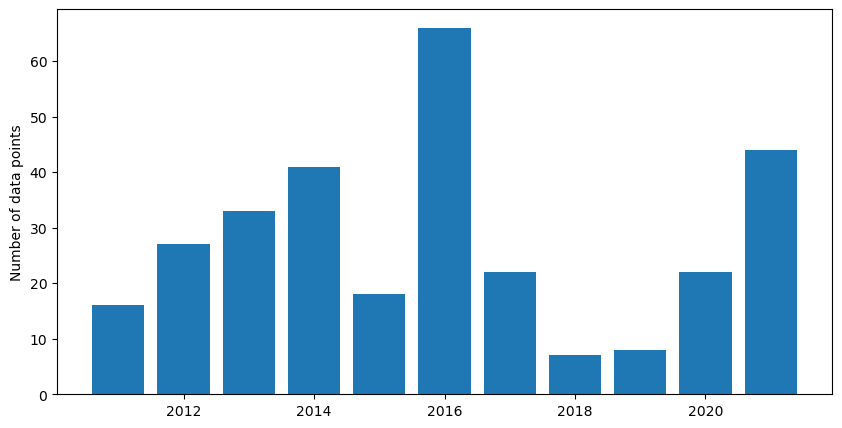

In [23]:
# plot the number of data points per year
plt.figure(figsize=(10, 5))
plt.bar(data['year'].unique(), data.groupby('year').size().tolist())
plt.ylabel('Number of data points')
plt.show()

In [24]:
substructure_name_list = ['thiourea',
                     'urea', 
                     'squaramide', 
                     'indole', 
                     'tambjamine', 
                     'carbazole', 
                     'acridinone', 
                     'perenosin',
                     'bisbzimpy', 
                     'isophthalamides_dipicolineamides']

In [26]:
# plot the number of data points per substructure per year
plt.figure(figsize=(10, 5))
for substructure_name in substructure_name_list:
    plt.plot(data['year'].unique(), data.groupby('year').sum()[substructure_name], label=substructure_name)
plt.xlabel('Year')
plt.ylabel('Number of data points')

# put legend on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_41086/4214015250.py", line 4, in <module>
    plt.plot(data['year'].unique(), data.groupby('year').sum()[substructure_name], label=substructure_name)
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 2263, in sum
    result = self._agg_general(
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 1422, in _agg_general
    result = self._cython_agg_general(
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 1507, in _cython_agg_general
    new_mgr = data.grouped_reduce(array_func)
  File "/Users/allybo/opt/anaconda3/e

<Figure size 1000x500 with 0 Axes>

In [27]:
# for each year, count number of data poitns per substructure
data.groupby('year').sum()[substructure_name_list]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_41086/2271700777.py", line 2, in <module>
    data.groupby('year').sum()[substructure_name_list]
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 2263, in sum
    result = self._agg_general(
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 1422, in _agg_general
    result = self._cython_agg_general(
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 1507, in _cython_agg_general
    new_mgr = data.grouped_reduce(array_func)
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/in

In [28]:
# plot the number of data points per substructure per year as bar chart
plt.figure(figsize=(10, 5))
bottom = np.zeros(len(data['year'].unique()))
for substructure_name in substructure_name_list:
    plt.bar(data['year'].unique(), data.groupby('year').sum()[substructure_name], label=substructure_name, bottom=bottom)
    bottom = bottom + data.groupby('year').sum()[substructure_name]
plt.xlabel('Year')
plt.ylabel('Number of data points')
# put legend on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_41086/3351459176.py", line 5, in <module>
    plt.bar(data['year'].unique(), data.groupby('year').sum()[substructure_name], label=substructure_name, bottom=bottom)
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 2263, in sum
    result = self._agg_general(
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 1422, in _agg_general
    result = self._cython_agg_general(
  File "/Users/allybo/opt/anaconda3/envs/pythia/lib/python3.9/site-packages/pandas/core/groupby/groupby.py", line 1507, in _cython_agg_general
    new_mgr = data.grouped_reduce(array_func)
  File "/Users/allybo/o

<Figure size 1000x500 with 0 Axes>

## Train-test split

In [29]:
test_dataid = []

# split by year
# keep 2021 as test set
for year in data['year'].unique():
    if year == 2021:
        test_dataid.append(data[data['year'] == year].index.tolist())

# flatten the list
test_dataid = [item for sublist in test_dataid for item in sublist]


In [30]:
data[data['year'] == 2021].index

Index([ 93,  91,  92,  90,  89, 125, 126, 127,  94,  83,  96,  97,  98, 128,
        99, 100, 101, 102, 103,  95, 129, 140, 131,  84,  85,  86,  87, 105,
        88, 144, 143, 142, 141,  82, 139, 138, 137, 136, 135, 134, 133, 132,
       130, 104],
      dtype='int64')

In [31]:
len(test_dataid)

44

In [32]:
# Test = last of each paper
#test_dataid = []

#for pid in data['paperid'].unique():
    #test_dataid.append(data[data['paperid'] == pid].index.values[0])
    #test_dataid.append(data[data['paperid'] == pid].index.values[-1])

In [33]:
test_data = pd.DataFrame()
test_data = data.iloc[test_dataid]

In [34]:
train_data = data.drop(index=test_dataid, axis=0, inplace = False)

In [35]:
len(train_data)

260

In [36]:
substratesmiles_train = train_data["smiles"]
log.info("Transporter SMILES: {}".format(substratesmiles_train.head()))

target_train = train_data["logec50"]
log.info("logEC50: {}".format(target_train.head()))

Transporter SMILES: 241    S=C(NC1=C(NC=C2)C2=CC=C1)NCCC(C)C
236                   O=C(NCCCC)NCCC(C)C
237                   S=C(NCCCC)NCCC(C)C
238            O=C(NC1=CC=CC=C1)NCCC(C)C
239            S=C(NC1=CC=CC=C1)NCCC(C)C
Name: smiles, dtype: object
logEC50: 241   -1.537602
236           N
237   -0.962574
238           N
239    0.483872
Name: logec50, dtype: object


In [37]:
substratesmiles_test = test_data["smiles"]
log.info("Transporter SMILES: {}".format(substratesmiles_test.head()))

target_test = test_data["logec50"]
log.info("logEC50: {}".format(target_test.head()))

Transporter SMILES: 124      CC(C(CCCCC)=C/1)=NC1=C/C2=C(OC)C=C(N2)C3=CC=CN3
123    O=C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)NC2=C(NC(...
222                    S=C(NCCCCCC)NC(C1=CC=C(OC)C=C1)=O
121    O=C(NC1=CC=C([N+]([O-])=O)C=C1)NC2=C(NC(NC3=CC...
288    O=C(NC1=CC=C(C#N)C=C1)NCC2=CC=CC(/N=N\C3=CC=CC...
Name: smiles, dtype: object
logEC50: 124    -3.19382
123    -2.79588
222   -0.552842
121   -2.318759
288   -0.420216
Name: logec50, dtype: object


# Handling the training set

## Generate features for the training set

In [38]:
help(AllChem.EmbedMolecule)

Help on built-in function EmbedMolecule in module rdkit.Chem.rdDistGeom:

EmbedMolecule(...)
    EmbedMolecule( (Mol)mol [, (int)maxAttempts=0 [, (int)randomSeed=-1 [, (bool)clearConfs=True [, (bool)useRandomCoords=False [, (float)boxSizeMult=2.0 [, (bool)randNegEig=True [, (int)numZeroFail=1 [, (dict)coordMap={} [, (float)forceTol=0.001 [, (bool)ignoreSmoothingFailures=False [, (bool)enforceChirality=True [, (bool)useExpTorsionAnglePrefs=True [, (bool)useBasicKnowledge=True [, (bool)printExpTorsionAngles=False [, (bool)useSmallRingTorsions=False [, (bool)useMacrocycleTorsions=False [, (int)ETversion=1]]]]]]]]]]]]]]]]]) -> int :
        Use distance geometry to obtain initial 
         coordinates for a molecule
        
         
         ARGUMENTS:
        
            - mol : the molecule of interest
            - maxAttempts : the maximum number of attempts to try embedding 
            - randomSeed : provide a seed for the random number generator 
                           so tha

In [39]:
import rdkit
rdkit.__version__

'2023.03.1'

In [40]:
submolecule_list_train = []

for smiles in substratesmiles_train:
    mol = Chem.rdmolfiles.MolFromSmiles(smiles)
    mol_with_hs = Chem.rdmolops.AddHs(mol)

    # Setting the parameters to use ETKDGv3 to generate the initial coordinates.
    v3_params = AllChem.ETKDGv3()
    v3_params.enforceChirality = True
    v3_params.useRandomCoordinates = True

    # This adds one conformer to mol_with_hs
    AllChem.EmbedMolecule(mol_with_hs, v3_params)
    
    # add the molecule to the list
    submolecule_list_train.append(mol_with_hs)

[18:00:59] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[18:00:59] UFFTYPER: Unrecognized atom type: S_6+6 (25)
[18:00:59] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[18:00:59] UFFTYPER: Unrecognized atom type: S_6+6 (25)
[18:01:07] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[18:01:07] UFFTYPER: Unrecognized atom type: S_6+6 (24)


In [448]:
calc = Calculator(descriptors, ignore_3D=False)
subfeatures_df_train = calc.pandas(submolecule_list_train)

100%|██████████| 260/260 [01:21<00:00,  3.19it/s]


In [449]:
subfeatures_df_train['PNSA1']

0      150.679498
1      662.371864
2      113.378985
3      142.704637
4      174.853931
          ...    
255    522.267775
256    394.026733
257    530.803551
258     366.60399
259    540.277831
Name: PNSA1, Length: 260, dtype: object

In [457]:
# show rows where PNSA1 is not float
checkmissing = subfeatures_df_train[subfeatures_df_train['PNSA1'].apply(lambda x: isinstance(x, float) == False)]
ids_missing = checkmissing.index.tolist()

# get smiles of missing values
if len(ids_missing) > 0:
    smiles_missing = [substratesmiles_train[i] for i in ids_missing]
    # show ids and smiles of missing values
    for i, s in zip(ids_missing, smiles_missing):
        print(i, s)
else:
    print("No missing values")

6 S=C(NCCCCCC)NC1=CC=C(C(OC)=O)C=C1
14 S=C(NCCCCCC)NC1=CC=C(OC)C=C1
206 O=C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)NCC2=CC=CC(CNC(NC3=CC(C(F)(F)F)=CC(C(F)(F)F)=C3)=O)=C2
207 O=C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)NCC2=CC=CC(CNC(NC3=CC(C(F)(F)F)=CC(C(F)(F)F)=C3)=O)=N2
210 S=C(NCCCCCCN1)NCC2=CN(N=N2)C3=CC=CC(N4C=C(CNC1=S)N=N4)=N3
216 S=C(NCCCCCC)NC1=CC=CC=C1


In [430]:
# Drop columns with NaN values
subfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df_train.index)))

# Drop columns with std lower than threshold
threshold = 0.5
subfeatures_df_train.drop(subfeatures_df_train.std()[subfeatures_df_train.std() < threshold].index.values, axis=1)

# Drop columns with values containing the string
subfeatures_df_train.drop(subfeatures_df_train.columns[subfeatures_df_train.isin(['missing']).any()], axis=1)

subfeatures_df_train.columns = [ent.strip() for ent in subfeatures_df_train.columns]
subfeatures_df_train.head()

ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  Zagreb2  \
0  13.682318  11.938414      0      0  22.381359  ...    22     88.0     99.0   
1  37.636054  26.337275      0      1  58.523244  ...    69    246.0    273.0   
2   8.813451   8.413992      0      0  14.733860  ...    11     50.0     49.0   
3  10.934771   9.613927      0      0  18.048677  ...    15     66.0     69.0   
4  10.934771   9.613927      0      0  18.048677  ...    15     66.0     69.0   

    mZagreb1   mZagreb2  
0   6.055556   4.055556  
1  19.298611  10.500000  
2   5.972222   3.250000  
3   5.583333   3.500000  
4   5.583333   3.500000  

[5 rows x 1826 columns]

## Include experimental conditions

In [369]:
feats_to_add = ['cl_conc_(mm)', 'time_between_transporter_added_and_lysis_(s)']

train_data = train_data.reset_index(drop=True)

for f in feats_to_add:
    subfeatures_df_train[f] = train_data[f]

In [370]:
log.info(subfeatures_df_train)
subfeatures_types = "some_categorical" 

           ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  Zagreb2   mZagreb1  \
0    13.682318  11.938414      0      0  22.381359  ...     99.0   6.055556   
1    37.636054  26.337275      0      1  58.523244  ...    273.0  19.298611   
2     8.813451   8.413992      0      0  14.733860  ...     49.0   5.972222   
3    10.934771   9.613927      0      0  18.048677  ...     69.0   5.583333   
4    10.934771   9.613927      0      0  18.048677  ...     69.0   5.583333   
..         ...        ...    ...    ...        ...  ...      ...        ...   
255  31.959570  23.876253      0      0  49.866621  ...    259.0  13.958333   
256  27.145856  20.313864      0      0  44.050114  ...    216.0   9.833333   
257  32.040450  23.158207      0      0  49.848627  ...    257.0  13.958333   
258  25.553303  18.889569      0      0  42.260498  ...    201.0   8.111111   
259  33.552123  25.303827      0      0  51.656261  ...    274.0  15.680556   

      mZagreb2  cl_conc_(mm)  time_between_transpor

In [371]:
subfeatures_df_train_exp = subfeatures_df_train.copy()

In [372]:
sum(subfeatures_df_train_exp.isnull().any())

0

In [373]:
subfeatures_df_train_exp.to_csv("features_train.csv")

## Classify the training set

In [374]:
classes_train=[]
for index, value in target_train.items():
    if value == 'N' or value > 0:
        classes_train.append(0)
    else:
        classes_train.append(1)

In [375]:
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])
features_and_classes_df_train = subfeatures_df_train_exp.copy()
features_and_classes_df_train["classes"] = classes_train

In [376]:
class_targets_df_train["classes"].values

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0])

## Data scaling

In [377]:
features_df_train_scaled = cwf.feature_categorization(subfeatures_df_train_exp, feature_types = "some_categorical")

Numerical features:
['ABC', 'ABCGG', 'SpAbs_A', 'SpMax_A', 'SpDiam_A', 'SpAD_A', 'SpMAD_A', 'LogEE_A', 'VE1_A', 'VE2_A', 'VE3_A', 'VR1_A', 'VR2_A', 'VR3_A', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3are', 'ATS4are', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS8are', 'ATS0p', 'ATS1p', 'ATS2p', 'ATS3p', 'ATS4p', 'ATS5p', 'ATS6p', 'ATS7p

In [378]:
sum(features_df_train_scaled.isnull().any())

418

In [218]:
for value in features_df_train_scaled['PNSA1'].values:
    # if value is null value: PRINT VALUE
    if value == 'N':
        print(value)

In [223]:
subfeatures_df_train_exp[subfeatures_df_train_exp['PNSA1'].isnull()]['PNSA1']

Series([], Name: PNSA1, dtype: object)

In [222]:
# show rows where PNSA1 is null and only show PNSA1 column
features_df_train_scaled[features_df_train_scaled['PNSA1'].isnull()]['PNSA1']

230   NaN
247   NaN
248   NaN
249   NaN
Name: PNSA1, dtype: float64

In [220]:
for colume in features_df_train_scaled.columns:
    if features_df_train_scaled[colume].isnull().values.any():
        log.info("Column {} has null values".format(colume))
        log.info("Number of null values: {}".format(features_df_train_scaled[colume].isnull().sum()))

        # show the index of the null values
        log.info("Index of null values: {}".format(features_df_train_scaled[colume][features_df_train_scaled[colume].isnull()].index.values))

Column PNSA1 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PNSA2 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PNSA3 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PNSA4 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PNSA5 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PPSA1 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PPSA2 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PPSA3 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PPSA4 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column PPSA5 has null values
Number of null values: 4
Index of null values: [230 247 248 249]
Column DPSA1 has null values
Number of null values: 4
Index 

In [164]:
substructure_name_list = ['thiourea',
                     'urea', 
                     'squaramide', 
                     'indole', 
                     'tambjamine', 
                     'carbazole', 
                     'acridinone', 
                     'perenosin',
                     'bisbzimpy', 
                     'isophthalamides_dipicolineamides']

train_data = train_data.reset_index(drop=True)

for f in substructure_name_list:
    features_df_train_scaled[f] = train_data[f]

In [175]:
sum(features_df_train_scaled.isnull().any())

418

In [166]:
features_df_train = features_df_train_scaled.copy()

In [167]:
features_df_train.to_csv("features_train.csv")

In [168]:
feature_types = 'categorical'

## Synthetic sampling for the training

In [169]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_catagorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=catagorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "catagorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [170]:
log.info("Feature decriptions:\n{}".format(features_df_train.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Feature decriptions:
['ABC' 'ABCGG' 'SpAbs_A' ... 'perenosin' 'bisbzimpy'
 'isophthalamides_dipicolineamides']
Classes/Targets descriptions:
['classes']


In [173]:
sum(features_df_train.isnull().any())

418

In [176]:
for colume in features_df_train.columns:
    if features_df_train[colume].isnull().values.any():
        log.info("Column {} has null values".format(colume))
        log.info("Number of null values: {}".format(features_df_train[colume].isnull().sum()))


Column PNSA1 has null values
Number of null values: 4
Column PNSA2 has null values
Number of null values: 4
Column PNSA3 has null values
Number of null values: 4
Column PNSA4 has null values
Number of null values: 4
Column PNSA5 has null values
Number of null values: 4
Column PPSA1 has null values
Number of null values: 4
Column PPSA2 has null values
Number of null values: 4
Column PPSA3 has null values
Number of null values: 4
Column PPSA4 has null values
Number of null values: 4
Column PPSA5 has null values
Number of null values: 4
Column DPSA1 has null values
Number of null values: 4
Column DPSA2 has null values
Number of null values: 4
Column DPSA3 has null values
Number of null values: 4
Column DPSA4 has null values
Number of null values: 4
Column DPSA5 has null values
Number of null values: 4
Column FNSA1 has null values
Number of null values: 4
Column FNSA2 has null values
Number of null values: 4
Column FNSA3 has null values
Number of null values: 4
Column FNSA4 has null values

In [177]:
features_df_train.PNSA1

0      0.217651
1      0.291161
2      0.204716
3      0.198937
4      0.305112
         ...   
268    0.753276
269    0.249055
270    0.307634
271    0.576953
272    0.795184
Name: PNSA1, Length: 273, dtype: float64

In [178]:
features_smote_train, classes_smote_train = sm.fit_resample(features_df_train.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(features_df_train.index)
log.info("SMOTE has added {} sythetic features to balence the classes".format(n_sythetic_points))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [187]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[0.73720997 0.33340075 0.48247012 ... 0.         0.         0.        ]
 [0.54269612 0.38015331 0.33067729 ... 0.         0.         0.        ]
 [0.73516478 0.33248754 0.48247012 ... 0.         0.         0.        ]
 ...
 [0.         0.4875985  0.03198456 ... 0.         0.         0.        ]
 [0.23460688 0.52648496 0.37406894 ... 0.         0.         0.        ]
 [0.4319322  0.3033351  0.06414343 ... 0.         0.         0.        ]]
(318, 175)
Resampled y:
[1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0
 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1
 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0

In [188]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=features_df_train.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

MATS4i    GATS4i      JGI4  SddsN  ETA_dPsi_B  EState_VSA5  SMR_VSA9  \
0    0.737210  0.333401  0.482470    1.0    0.227146     0.352810  0.000000   
1    0.542696  0.380153  0.330677    1.0    0.000000     0.343072  0.000000   
2    0.735165  0.332488  0.482470    1.0    0.000000     0.264607  0.000000   
3    0.697671  0.344152  0.419967    1.0    0.000000     0.264607  0.263459   
4    0.459347  0.206954  0.495857    1.0    0.000000     0.254869  0.000000   
..        ...       ...       ...    ...         ...          ...       ...   
313  0.733153  0.324669  0.175299    1.0    0.000000     0.000000  0.000000   
314  0.481232  0.509681  0.105976    1.0    0.000000     0.000000  0.000000   
315  0.000000  0.487599  0.031985    1.0    0.000000     0.064563  0.000000   
316  0.234607  0.526485  0.374069    1.0    0.000000     0.000000  0.000000   
317  0.431932  0.303335  0.064143    1.0    0.000000     0.067310  0.000000   

       AATS3i    GATS4c    GATS6d  ...  urea  squaramide  indole  tambjamine  \
0    0.394095  0.515659  0.412544  ...   0.0         0.0     0.0         0.0   
1    0.449852  0.244818  0.276234  ...   0.0         0.0     0.0         0.0   
2    0.413717  0.519011  0.412544  ...   0.0         0.0     0.0         0.0   
3    0.385681  0.446559  0.388470  ...   0.0         0.0     0.0         0.0   
4    0.457734  0.203046  0.242039  ...   0.0         0.0     0.0         0.0   
..        ...       ...       ...  ...   ...         ...     ...         ...   
313  0.424445  0.458751  0.469237  ...   1.0         0.0     0.0         0.0   
314  0.207309  0.552362  0.389474  ...   1.0         0.0     1.0         0.0   
315  0.038370  0.077371  0.296423  ...   1.0         0.0     0.0         0.0   
316  0.109509  0.201900  0.270651  ...   1.0         0.0     0.0         0.0   
317  0.254780  0.289908  0.276234  ...   1.0         0.0     0.0         0.0   

     carbazole  acridinone  perenosin  bisbzimpy  \
0          0.0         0.0        0.0        0.0   
1          0.0         0.0        0.0        0.0   
2          0.0         0.0        0.0        0.0   
3          0.0         0.0        0.0        0.0   
4          0.0         0.0        0.0        0.0   
..         ...         ...        ...        ...   
313        0.0         0.0        0.0        0.0   
314        0.0         0.0        0.0        0.0   
315        0.0         0.0        0.0        0.0   
316        0.0         0.0        0.0        0.0   
317        0.0         0.0        0.0        0.0   

     isophthalamides_dipicolineamides  classes  
0                                 0.0        1  
1                                 0.0        1  
2                                 0.0        0  
3                                 0.0        1  
4                                 0.0        1  
..                                ...      ...  
313                               0.0        0  
314                               0.0        0  
315                               0.0        0  
316                               0.0        0  
317                               0.0        0  

[318 rows x 176 columns]

# Handling the Test set

## Classify the test set

In [189]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_test = [wf.get_mol_from_smiles(s) for s in substratesmiles_test]
subfeatures_df_test = calc.pandas(submolecule_list_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.14it/s]


In [190]:
subfeatures_df_test_categorized = wf.feature_categorization(subfeatures_df_test)

Numerical features:
['ABC', 'ABCGG', 'SpAbs_A', 'SpMax_A', 'SpDiam_A', 'SpAD_A', 'SpMAD_A', 'LogEE_A', 'VE1_A', 'VE2_A', 'VE3_A', 'VR1_A', 'VR2_A', 'VR3_A', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3are', 'ATS4are', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS8are', 'ATS0p', 'ATS1p', 'ATS2p', 'ATS3p', 'ATS4p', 'ATS5p', 'ATS6p', 'ATS7p

Catagorical features:
['nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nB', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'nBonds', 'nBondsO', 'nBondsS', 'nBondsD', 'nBondsT', 'nBondsA', 'nBondsM', 'nBondsKS', 'nBondsKD', 'C1SP1', 'C2SP1', 'C1SP2', 'C2SP2', 'C3SP2', 'C1SP3', 'C2SP3', 'C3SP3', 'C4SP3', 'NsLi', 'NssBe', 'NssssBe', 'NssBH', 'NsssB', 'NssssB', 'NsCH3', 'NdCH2', 'NssCH2', 'NtCH', 'NdsCH', 'NaaCH', 'NsssCH', 'NddC', 'NtsC', 'NdssC', 'NaasC', 'NaaaC', 'NssssC', 'NsNH3', 'NsNH2', 'NssNH2', 'NdNH', 'NssNH', 'NaaNH', 'NtN', 'NsssNH', 'NdsN', 'NaaN', 'NsssN', 'NddsN', 'NaasN', 'NssssN', 'NsOH', 'NdO', 'NssO', 'NaaO', 'NsF', 'NsSiH3', 'NssSiH2', 'NsssSiH', 'NssssSi', 'NsPH2', 'NssPH', 'NsssP', 'NdsssP', 'NsssssP', 'NsSH', 'NdS', 'NssS', 'NaaS', 'NdssS', 'NddssS', 'NsCl', 'NsGeH3', 'NssGeH2', 'NsssGeH', 'NssssGe', 'NsAsH2', 'NssAsH', 'NsssAs', 'NsssdAs', 'NsssssAs', 'NsSeH', 'NdSe', 'NssSe', 'NaaSe', 'Nds

Transformer index: 1
Tranformer name: catagorical
Transformer: OneHotEncoder(handle_unknown='ignore')
Original feature names: ['nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nB', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'nBonds', 'nBondsO', 'nBondsS', 'nBondsD', 'nBondsT', 'nBondsA', 'nBondsM', 'nBondsKS', 'nBondsKD', 'C1SP1', 'C2SP1', 'C1SP2', 'C2SP2', 'C3SP2', 'C1SP3', 'C2SP3', 'C3SP3', 'C4SP3', 'NsLi', 'NssBe', 'NssssBe', 'NssBH', 'NsssB', 'NssssB', 'NsCH3', 'NdCH2', 'NssCH2', 'NtCH', 'NdsCH', 'NaaCH', 'NsssCH', 'NddC', 'NtsC', 'NdssC', 'NaasC', 'NaaaC', 'NssssC', 'NsNH3', 'NsNH2', 'NssNH2', 'NdNH', 'NssNH', 'NaaNH', 'NtN', 'NsssNH', 'NdsN', 'NaaN', 'NsssN', 'NddsN', 'NaasN', 'NssssN', 'NsOH', 'NdO', 'NssO', 'NaaO', 'NsF', 'NsSiH3', 'NssSiH2', 'NsssSiH', 'NssssSi', 'NsPH2', 'NssPH', 'NsssP', 'NdsssP', 'NsssssP', 'NsSH', 'NdS', 'NssS', 'NaaS', 'NdssS', 'NddssS', 'NsCl', 'NsGeH3', 'NssGeH2', 'NsssGeH',

         ABC     ABCGG   SpAbs_A   SpMax_A  SpDiam_A    SpAD_A   SpMAD_A  \
0   0.028919  0.006002  0.059079  0.228150  0.228217  0.059079  0.651461   
1   0.232892  0.188762  0.301548  0.596717  0.356783  0.301548  0.963490   
2   0.044941  0.014586  0.070525  0.265630  0.265708  0.070525  0.829652   
3   0.258807  0.298380  0.207241  0.653910  0.654101  0.207241  0.000000   
4   0.174074  0.196702  0.157246  0.642224  0.636189  0.157246  0.440412   
..       ...       ...       ...       ...       ...       ...       ...   
26  1.000000  1.000000  1.000000  0.800288  0.800522  1.000000  0.378652   
27  0.361818  0.291642  0.426235  0.938138  0.938412  0.426235  0.992430   
28  0.383878  0.275259  0.461568  0.323551  0.323646  0.461568  0.949233   
29  0.226138  0.219596  0.296596  0.000000  0.000000  0.296596  0.527017   
30  0.337730  0.380084  0.299138  0.836208  0.836453  0.299138  0.207091   

     LogEE_A     VE1_A     VE2_A  ...  WPol_53  WPol_55  WPol_58  WPol_64  \
0   0.0717

Catagorical features start on column name nAcid_0 and end on WPol_117


In [191]:
test_data = test_data.reset_index(drop=True)
for f in feats_to_add:
    subfeatures_df_test_categorized[f] = test_data[f]
    
for f in substructure_name_list:
    subfeatures_df_test_categorized[f] = test_data[f]

In [192]:
testfeats_df_sub = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(target_train)

# Add RDKit descriptors
for ent in features_df_train.columns:
    if ent in subfeatures_df_test_categorized.columns:
        testfeats_df_sub[ent] = subfeatures_df_test_categorized[ent].values 
        testcontinous_features.append(ent)
    else:
        testfeats_df_sub[ent] = 0.0

/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/821436726.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  testfeats_df_sub[ent] = 0.0
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/821436726.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  testfeats_df_sub[ent] = subfeatures_df_test_categorized[ent].values
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/821436726.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/821436726.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  testfeats_df_sub[ent] = 0.0
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/821436726.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  testfeats_df_sub[ent] = subfeatures_df_test_categorized[ent].values
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/821436726.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

In [193]:
features_df_test = testfeats_df_sub

In [194]:
features_df_test

MATS4i    GATS4i      JGI4  SddsN  ETA_dPsi_B  EState_VSA5  SMR_VSA9  \
0   0.420411  0.527450  0.371981    1.0         0.0     0.815948  0.000000   
1   0.391249  0.541634  0.267009    1.0         0.0     1.000000  0.000000   
2   0.456748  0.464717  0.415020    1.0         0.0     0.907974  0.000000   
3   0.028617  0.652967  0.896480    1.0         0.0     0.152405  0.000000   
4   0.155498  0.609940  0.715347    1.0         0.0     0.162484  0.000000   
..       ...       ...       ...    ...         ...          ...       ...   
26  0.218466  0.505204  0.819603    1.0         0.0     0.070228  0.000000   
27  0.470310  0.533520  0.735091    1.0         0.0     0.070228  0.000000   
28  0.350063  0.649983  0.650966    1.0         0.0     0.000000  0.526918   
29  0.242478  0.763262  0.000000    1.0         0.0     0.552157  0.000000   
30  0.494991  0.370188  1.000000    1.0         0.0     0.318952  0.000000   

      AATS3i    GATS4c    GATS6d  ...  thiourea  urea  squaramide  indole  \
0   0.419030  0.266335  0.631121  ...         1     0           0       0   
1   0.402262  0.667512  0.553596  ...         0     0           0       0   
2   0.401971  0.374832  0.750299  ...         1     0           0       0   
3   0.479114  0.011503  0.114576  ...         0     1           0       0   
4   0.296700  0.158567  0.201241  ...         0     1           0       0   
..       ...       ...       ...  ...       ...   ...         ...     ...   
26  0.468662  0.000000  0.000000  ...         0     0           1       0   
27  0.334274  0.370317  0.678623  ...         0     0           1       0   
28  0.201487  0.454573  0.336278  ...         1     0           0       0   
29  0.555394  0.355418  0.785624  ...         1     0           0       0   
30  0.000000  0.071988  1.000000  ...         0     0           1       0   

    tambjamine  carbazole  acridinone  perenosin  bisbzimpy  \
0            0          0           0          0          0   
1            1          0           0          0          0   
2            0          0           0          0          0   
3            0          0           0          0          0   
4            0          0           0          0          0   
..         ...        ...         ...        ...        ...   
26           0          0           0          0          0   
27           0          0           0          0          0   
28           0          0           0          0          0   
29           0          0           0          0          0   
30           0          0           0          0          0   

    isophthalamides_dipicolineamides  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  
..                               ...  
26                                 0  
27                                 0  
28                                 0  
29                                 0  
30                                 0  

[31 rows x 175 columns]

## Classify the test set

In [195]:
classes_test=[]
for index, value in target_test.items():
    if value == 'N' or value > 0:
        classes_test.append(0)
    else:
        classes_test.append(1)

# Define Xtrain, Xtest, Ytrain, Ytest

In [196]:
Xtrain = features_df_train
Xtest = features_df_test
Ytrain = class_targets_df_train
Ytest = classes_test

# Time for ML

In [197]:
kfold_clf_names = [
    "Nearest Neighbors", 
    "Gaussian Process",
    "Decision Tree", 
    "ExtraTreesClassifier", 
    "AdaBoost",
    "Logistic Regression"]

kfold_classifiers = [
     KNeighborsClassifier(),
     GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
     DecisionTreeClassifier(random_state=random_seed),
     ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
     AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
     "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
     "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
     "Decision Tree": {"max_depth": [2, 3, 4, 5, 7, 10]},
     "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
     "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [198]:
def minmaxscale(df):
    """
    scale a pandas dataframe using min max scaling
    :param df: pandas dataframe - data frame to be returned scaled
    """
    
    df_tmp = df.copy()
    normalized_df = (df_tmp-df_tmp.min())/(df_tmp.max()-df_tmp.min())
    return normalized_df

In [199]:
def grid_search_classifier_parameters(clf, Xtrain, ytrain, clf_options, clf_names, iteration, no_train_output, cv=5, name=None, scoring=("roc_auc", "precision", "recall")):
    """
    Grid search calssifer hyperparams and find the best report metrics if requested
    """
    log = logging.getLogger(__name__)
    
    # Grid search model optimizer
    parameters = clf_options[clf_names[iteration]]
    log.debug("\tname: {} parameters: {}".format(name, parameters))
    
    optparam_search = GridSearchCV(clf, parameters, cv=cv, error_score=np.nan, scoring=scoring, refit=scoring[0], return_train_score=True)
    log.debug("\tCV xtrain: {}".format(Xtrain))
    
    optparam_search.fit(Xtrain, ytrain.values.ravel())
    opt_parameters = optparam_search.best_params_
    
    if no_train_output is False:
        reported_metrics = pd.DataFrame(data=optparam_search.cv_results_)
        reported_metrics.to_csv("{}/{}_grid_search_metrics.csv".format(name,name))
        log.info("\tBest parameters; {}".format(opt_parameters))
        for mean, std, params in zip(optparam_search.cv_results_["mean_test_{}".format(scoring[0])], 
                                     optparam_search.cv_results_["std_test_{}".format(scoring[0])], 
                                     optparam_search.cv_results_['params']):
            log.info("\t{:.4f} (+/-{:.4f}) for {}".format(mean, std, params))
    else:
        pass
    
    return opt_parameters

In [5]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support
def kfold_test_imbalenced_classifiers_with_optimization(df, test_df, classes, testclasses, classifiers, clf_options, scale=True, cv=5, n_repeats=20, clf_names=None, 
                                                        class_labels=(0,1), no_train_output=False, smiles=None, names=None,
                                                        random_seed=107901, overwrite=False):
    """
    function to run classification test over classifiers using imbalenced resampling
    inspired from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    :param df: dataframe - data frame of features and identifers (smiles and/or names)
    :param classes: iterable - list of classes/labels
    :param classifiers: list - list of classifier methods
    :param plot: true/false - plot the results or not
    """
    
    log = logging.getLogger(__name__)
    
    log.info("Features: {}".format(df.columns))
    
    log_df = pd.DataFrame()
    labelpredictions = pd.DataFrame()
    
    predicted,list_opt_param=[],[]
    list_report, list_roc_auc, list_opt_param, list_score, list_c_matrix=[],[],[],[],[]
    iteration = 0
    pd.set_option('display.max_columns', 20)
    data = df.copy()
    data.reset_index(inplace=True)
       
    if clf_names is None:
        clf_names = [i for i in range(0, len(classifiers))]
    
    if scale is True:
        data = minmaxscale(data)
        log.info("Scaled data:\n{}".format(data))
    else:
        log.info("Using unscaled features")
    
    for name, classf in zip(clf_names, classifiers):
        log.info("\n-----\nBegin {}\n-----\n".format(name))
        
        kf_iteration = 0
        if not n_repeats % 2:
            figure = plt.figure(figsize=(2 * 20.0, 5.0 * int(n_repeats/2.0)))
            plt_rows = int(n_repeats/2.0)
        else:
            figure = plt.figure(figsize=(2 * 20.0, 5.0 * int(n_repeats/2.0)+1))
            plt_rows = nt(n_repeats/2.0)+1
        scores = []
        confusion_matrices = []
        roc_aucs = []
        score_list = []
        tmp = []
        name = "{}".format("_".join(name.split()))
        
        # Make directory for each classifier
        if not os.path.isdir(name):
            os.makedirs(name, exist_ok = True)
        elif overwrite is False and os.path.isdir(name) is True:
            log.warning("Directory already exists and overwrite is False will stop before overwriting.".format(name))
            return None
        else:
            log.info("Directory {} already exists will be overwritten".format(name))
        
            # Train
        Xtrain = df
        log.debug("Train X\n{}".format(Xtrain))
        df.to_csv('Xtrain.csv')
        ytrain = classes
        log.debug("Train Y\n{}".format(ytrain))
            
            # Test
        Xtest = test_df
        log.debug("Test X\n{}".format(Xtest))
        test_df.to_csv('Xtest.csv')
        ytest = testclasses
        log.debug("Test Y\n{}".format(ytest))
        
            # Grid search model optimizer
        opt_param = grid_search_classifier_parameters(classf, Xtrain, ytrain, clf_options, clf_names, iteration, no_train_output, cv=cv, name=name)
                 
        list_opt_param.append(opt_param)
            
            # Fit final model using optimized parameters
        clf = classf
        clf.set_params(**opt_param)
        log.info("\n\t----- Predicting using: {} -----".format(name))
        log.debug("\tXtrain: {}\n\tXtest: {}\n\tytrain: {}\n\tytest: {}".format(Xtrain, Xtest, ytrain, ytest))
        clf.fit(Xtrain, ytrain)
            
            # Evaluate the model
            ## evaluate the model on multiple metric score as list for averaging
        predicted_clf = clf.predict(Xtest)
        sc = precision_recall_fscore_support(ytest, predicted_clf, average=None)
        sc_df = pd.DataFrame(data=np.array(sc).T, columns=["precision", "recall", "f1score", "support"])
        sc_df.to_csv(os.path.join(name, "fold_{}_score.csv".format(kf_iteration)))
        score_list.append(sc)
            
            ## evaluate the principle score metric only (incase different to those above although this is unlikely)
        clf_score = clf.score(Xtest, ytest)
        scores.append(clf_score)
            
            ## Get the confusion matrices 
        c_matrix = confusion_matrix(ytest, predicted_clf, labels=class_labels)
        confusion_matrices.append(c_matrix)
            
            ## Calculate the roc area under the curve
        probs = clf.predict_proba(Xtest)
        fpr, tpr, thresholds = roc_curve(ytest, probs[:,1], pos_label=1)
        roc_auc = auc(fpr, tpr)
            
        list_roc_auc.append(roc_auc)
            
        roc_aucs.append(roc_auc)
        log.info("\tROC analysis area under the curve: {}".format(roc_auc))
            
            # output metrics for consideration
        log.info("\tConfusion matrix ({}):\n{}\n".format(name, c_matrix))
            
        list_c_matrix.append(c_matrix)
        log.info("\n\tscore ({}): {}".format(name, clf_score))   

        list_score.append(clf_score)
        
        log.info("\tImbalence reports:")
        log.info("\tImbalence classification report:\n{}".format(classification_report_imbalanced(ytest, predicted_clf)))
        output_dict = classification_report_imbalanced(ytest, predicted_clf, output_dict=True)
            
            ## Plot the roc curves
        ax = plt.subplot(2, plt_rows, kf_iteration+1)
        ax.plot(fpr, tpr, color="red",
                     lw=1.5, label="ROC curve (auc = {:.2f})".format(roc_auc))
            
                # ugliest legend i ve made in my life - maybe one under the other?
            
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "pre_class0 = {:.2f}\n".format(output_dict[0]['pre'])+"pre_class1 = {:.2f}".format(output_dict[1]['pre']))
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "f1_class0 = {:.2f}\n".format(output_dict[0]['f1'])+ "f1_class1 = {:.2f}".format(output_dict[1]['f1']))
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "rec_class0 = {:.2f}\n".format(output_dict[0]['rec'])+ "rec_class1 = {:.2f}".format(output_dict[1]['rec']))

        ax.plot([0, 1], [0, 1], "k:")
        ax.set_xlim(xmin=0.0, xmax=1.01)
        ax.set_ylim(ymin=0.0, ymax=1.01)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")
            
                   
        list_report.append(classification_report_imbalanced(ytest, predicted_clf))
            
        sensitvity, specificity, support = sensitivity_specificity_support(ytest, predicted_clf)
        log.debug("\t{} {} {}".format(sensitvity, specificity, support))
        log.info("\t -----Index | Predicted | Label\n\t------------------")

        log.info("\t{}\n-----\n".format("\n\t".join(["  {}   |   {}   |   {}".format(i, p, k) for i,(p, k) in enumerate(zip(predicted_clf, ytest))])))
    
        

        pred = [list(range(len(testclasses))),list(ytest),list(predicted_clf), list(probs[:,0]), list(probs[:,1])]
            
        pred = pd.DataFrame(pred)
        pred.T.to_csv("{}/{}.csv".format(name, kf_iteration))
        kf_iteration = kf_iteration + 1
        
        
#         if any(x not in tmp for x in [y for y in range(len(classes.index))]):
#              log.info("WARNING there appears to be left over indexes which have not been used for testing: {}".format())
#         else:
#             log.info("All points have been used in a test case over all fold as they should have been")
        
        # Plot and assess classifier over all folds
        
        # NOTE - rows are scores columns are classes
        average_scores = np.mean(score_list, axis=0)
        std_scores = np.std(score_list, axis=0)
        average_roc_auc = np.mean(roc_aucs, axis=0)
        std_roc_auc = np.std(roc_aucs, axis=0)
        
        log.info("{} {} {} {}".format(average_scores, std_scores, average_roc_auc, std_roc_auc))

        # precision_recall_fscore_support
        score_str1 = "Class 0: Pre: {:.2f} +/- {:.2f} Rec: {:.2f} +/- {:.2f} Fsc: {:.2f} +/- {:.2f} Sup: {:.2f} +/- {:.2f}".format(average_scores[0][0], 
                                                                                                                                   std_scores[0][0], 
                                                                                                                                   average_scores[1][0], 
                                                                                                                                   std_scores[1][0], 
                                                                                                                                   average_scores[2][0], 
                                                                                                                                   std_scores[2][0], 
                                                                                                                                   average_scores[3][0], 
                                                                                                                                   std_scores[3][0])
        score_str2 = "Class 1: Pre: {:.2f} +/- {:.2f} Rec: {:.2f} +/- {:.2f} Fsc: {:.2f} +/- {:.2f} Sup: {:.2f} +/- {:.2f}".format(average_scores[0][1], 
                                                                                                                                   std_scores[0][1], 
                                                                                                                                   average_scores[1][1], 
                                                                                                                                   std_scores[1][1], 
                                                                                                                                   average_scores[2][1], 
                                                                                                                                   std_scores[2][1], 
                                                                                                                                   average_scores[3][1], 
                                                                                                                                   std_scores[3][1])
        score_str3 ="Average ROC AUCs: {:.2f} +/- {:.2f}".format(average_roc_auc, std_roc_auc)
        score_text = "{}\n{}\n{}".format(score_str1, score_str2, score_str3)
        plt.annotate(score_text, xy=(0.5, 0), xytext=(0, 0), xycoords="figure fraction", textcoords='offset points', size=12, ha='center', va='bottom')
        figure.tight_layout()
        plt.savefig("{0}/{0}_roc_curves.png".format(name))
        plt.show()

        iteration = iteration + 1
    log_df["opt_param"] = pd.Series(list_opt_param)
    log_df["roc_auc"] = pd.Series(list_roc_auc)

    log_df["report"] = pd.Series(list_report)
    log_df["score"] = pd.Series(list_score)

    log_df["c_matrix"] = pd.Series(list_c_matrix)
    
    log_df.to_csv("logs2.csv")
        

Features: Index(['MATS4i', 'GATS4i', 'JGI4', 'SddsN', 'ETA_dPsi_B', 'EState_VSA5',
       'SMR_VSA9', 'AATS3i', 'GATS4c', 'GATS6d',
       ...
       'thiourea', 'urea', 'squaramide', 'indole', 'tambjamine', 'carbazole',
       'acridinone', 'perenosin', 'bisbzimpy',
       'isophthalamides_dipicolineamides'],
      dtype='object', length=175)
Scaled data:
        index    MATS4i    GATS4i      JGI4  SddsN  ETA_dPsi_B  EState_VSA5  \
0    0.000000  0.737210  0.333401  0.482470    1.0    0.227146     0.352810   
1    0.003676  0.542696  0.380153  0.330677    1.0    0.000000     0.343072   
2    0.007353  0.735165  0.332488  0.482470    1.0    0.000000     0.264607   
3    0.011029  0.697671  0.344152  0.419967    1.0    0.000000     0.264607   
4    0.014706  0.459347  0.206954  0.495857    1.0    0.000000     0.254869   
..        ...       ...       ...       ...    ...         ...          ...   
268  0.985294  0.421583  0.371185  1.000000    1.0    0.000000     0.000000   
269  0.98

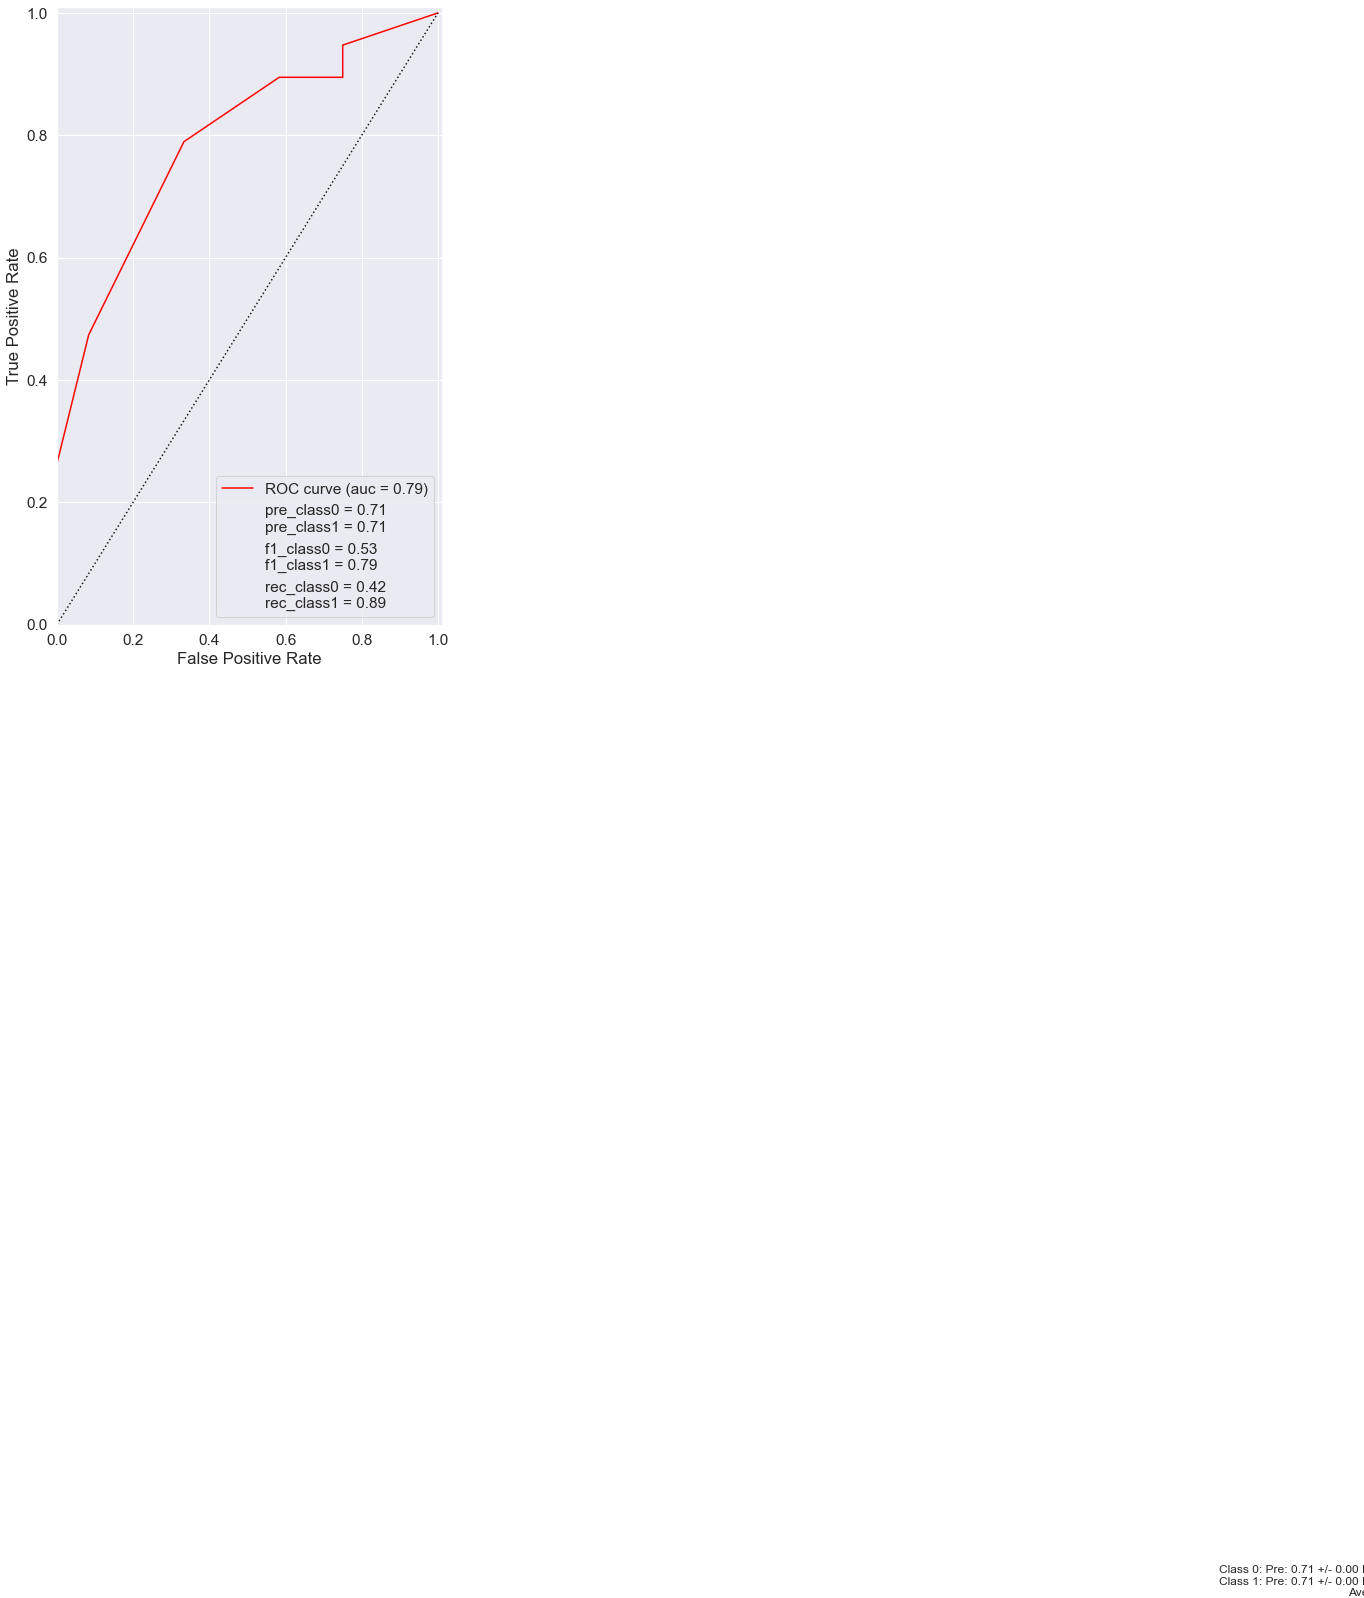


-----
Begin Gaussian Process
-----

Directory Gaussian_Process already exists will be overwritten
/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower 

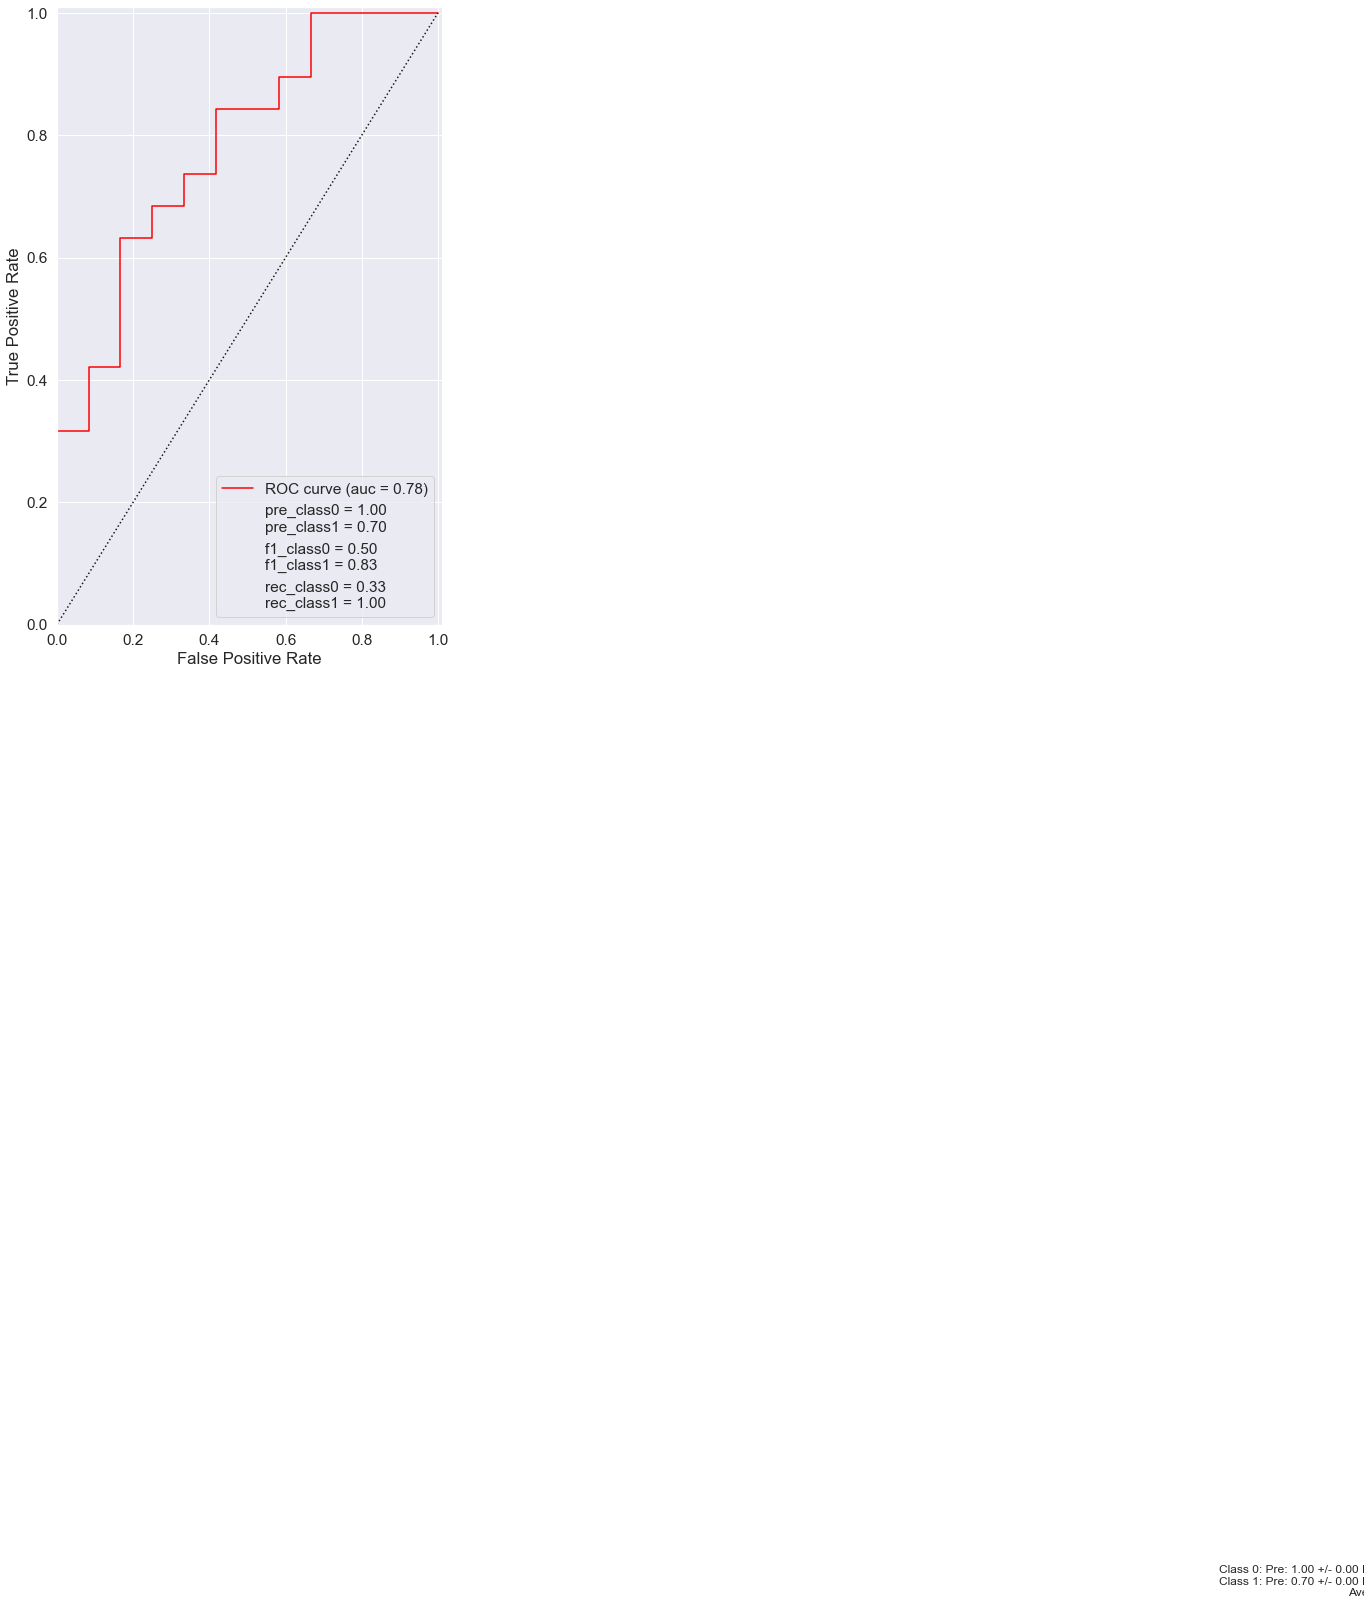


-----
Begin Decision Tree
-----

Directory Decision_Tree already exists will be overwritten
	Best parameters; {'max_depth': 3}
	0.5797 (+/-0.2052) for {'max_depth': 2}
	0.6568 (+/-0.1672) for {'max_depth': 3}
	0.5932 (+/-0.1278) for {'max_depth': 4}
	0.6449 (+/-0.1316) for {'max_depth': 5}
	0.6236 (+/-0.1273) for {'max_depth': 7}
	0.6352 (+/-0.1312) for {'max_depth': 10}

	----- Predicting using: Decision_Tree -----
	ROC analysis area under the curve: 0.6578947368421053
	Confusion matrix (Decision_Tree):
[[ 6  6]
 [ 6 13]]


	score (Decision_Tree): 0.6129032258064516
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.50      0.68      0.50      0.58      0.34        12
          1       0.68      0.68      0.50      0.68      0.58      0.35        19

avg / total       0.61      0.61      0.57      0.61      0.58      0.34        31

	 -----Index | Predicted | Label
	--

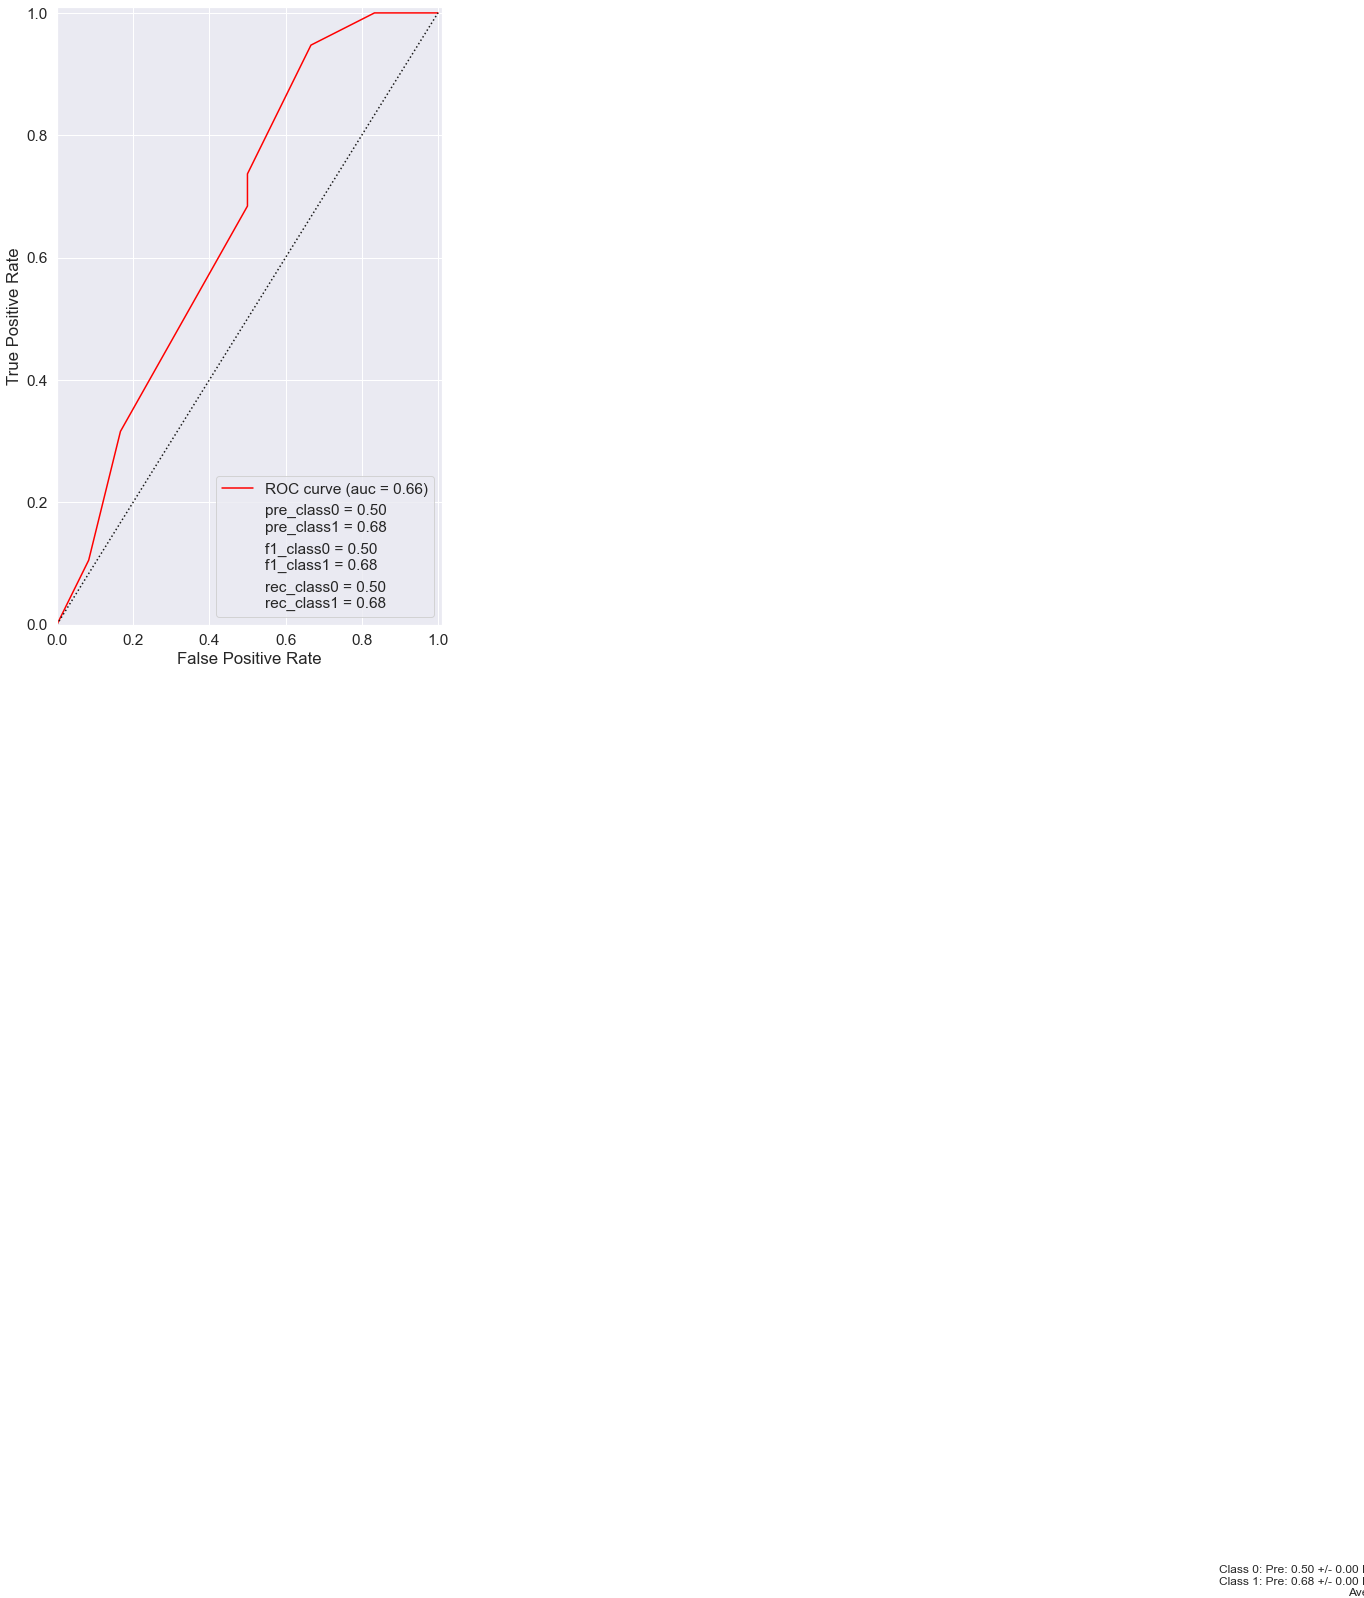


-----
Begin ExtraTreesClassifier
-----

Directory ExtraTreesClassifier already exists will be overwritten
	Best parameters; {'max_depth': 10, 'n_estimators': 20}
	0.6669 (+/-0.1758) for {'max_depth': 2, 'n_estimators': 10}
	0.7042 (+/-0.1896) for {'max_depth': 2, 'n_estimators': 20}
	0.6857 (+/-0.2005) for {'max_depth': 2, 'n_estimators': 50}
	0.7081 (+/-0.1933) for {'max_depth': 2, 'n_estimators': 100}
	0.6848 (+/-0.1556) for {'max_depth': 3, 'n_estimators': 10}
	0.7322 (+/-0.1617) for {'max_depth': 3, 'n_estimators': 20}
	0.7166 (+/-0.1782) for {'max_depth': 3, 'n_estimators': 50}
	0.7282 (+/-0.1814) for {'max_depth': 3, 'n_estimators': 100}
	0.6593 (+/-0.2014) for {'max_depth': 4, 'n_estimators': 10}
	0.7358 (+/-0.1798) for {'max_depth': 4, 'n_estimators': 20}
	0.7482 (+/-0.1714) for {'max_depth': 4, 'n_estimators': 50}
	0.7501 (+/-0.1772) for {'max_depth': 4, 'n_estimators': 100}
	0.7027 (+/-0.1892) for {'max_depth': 5, 'n_estimators': 10}
	0.7437 (+/-0.1827) for {'max_depth': 5, 

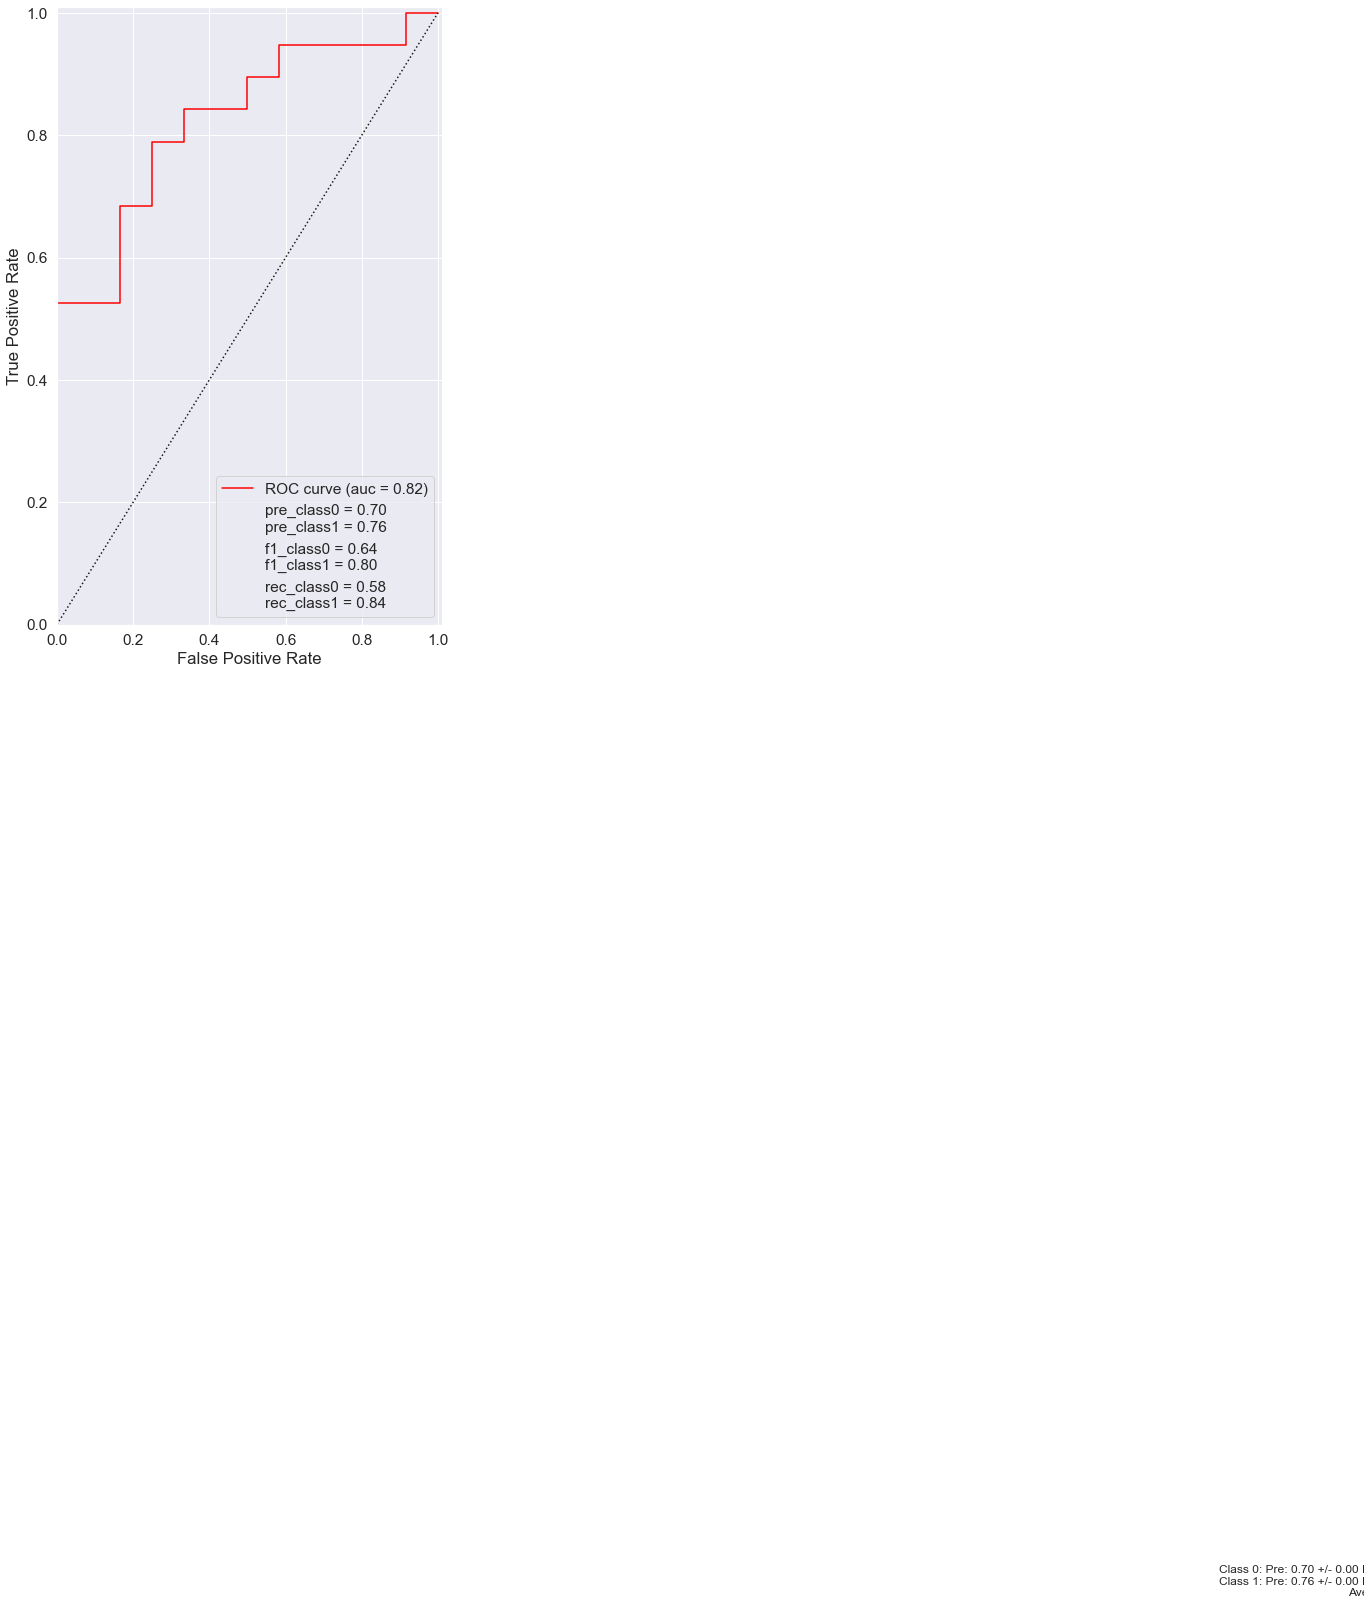


-----
Begin AdaBoost
-----

Directory AdaBoost already exists will be overwritten
	Best parameters; {'n_estimators': 20}
	0.7455 (+/-0.1520) for {'n_estimators': 10}
	0.7560 (+/-0.1501) for {'n_estimators': 20}
	0.7445 (+/-0.1571) for {'n_estimators': 50}
	0.7523 (+/-0.1362) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
	ROC analysis area under the curve: 0.7192982456140351
	Confusion matrix (AdaBoost):
[[ 5  7]
 [ 1 18]]


	score (AdaBoost): 0.7419354838709677
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.42      0.95      0.56      0.63      0.37      

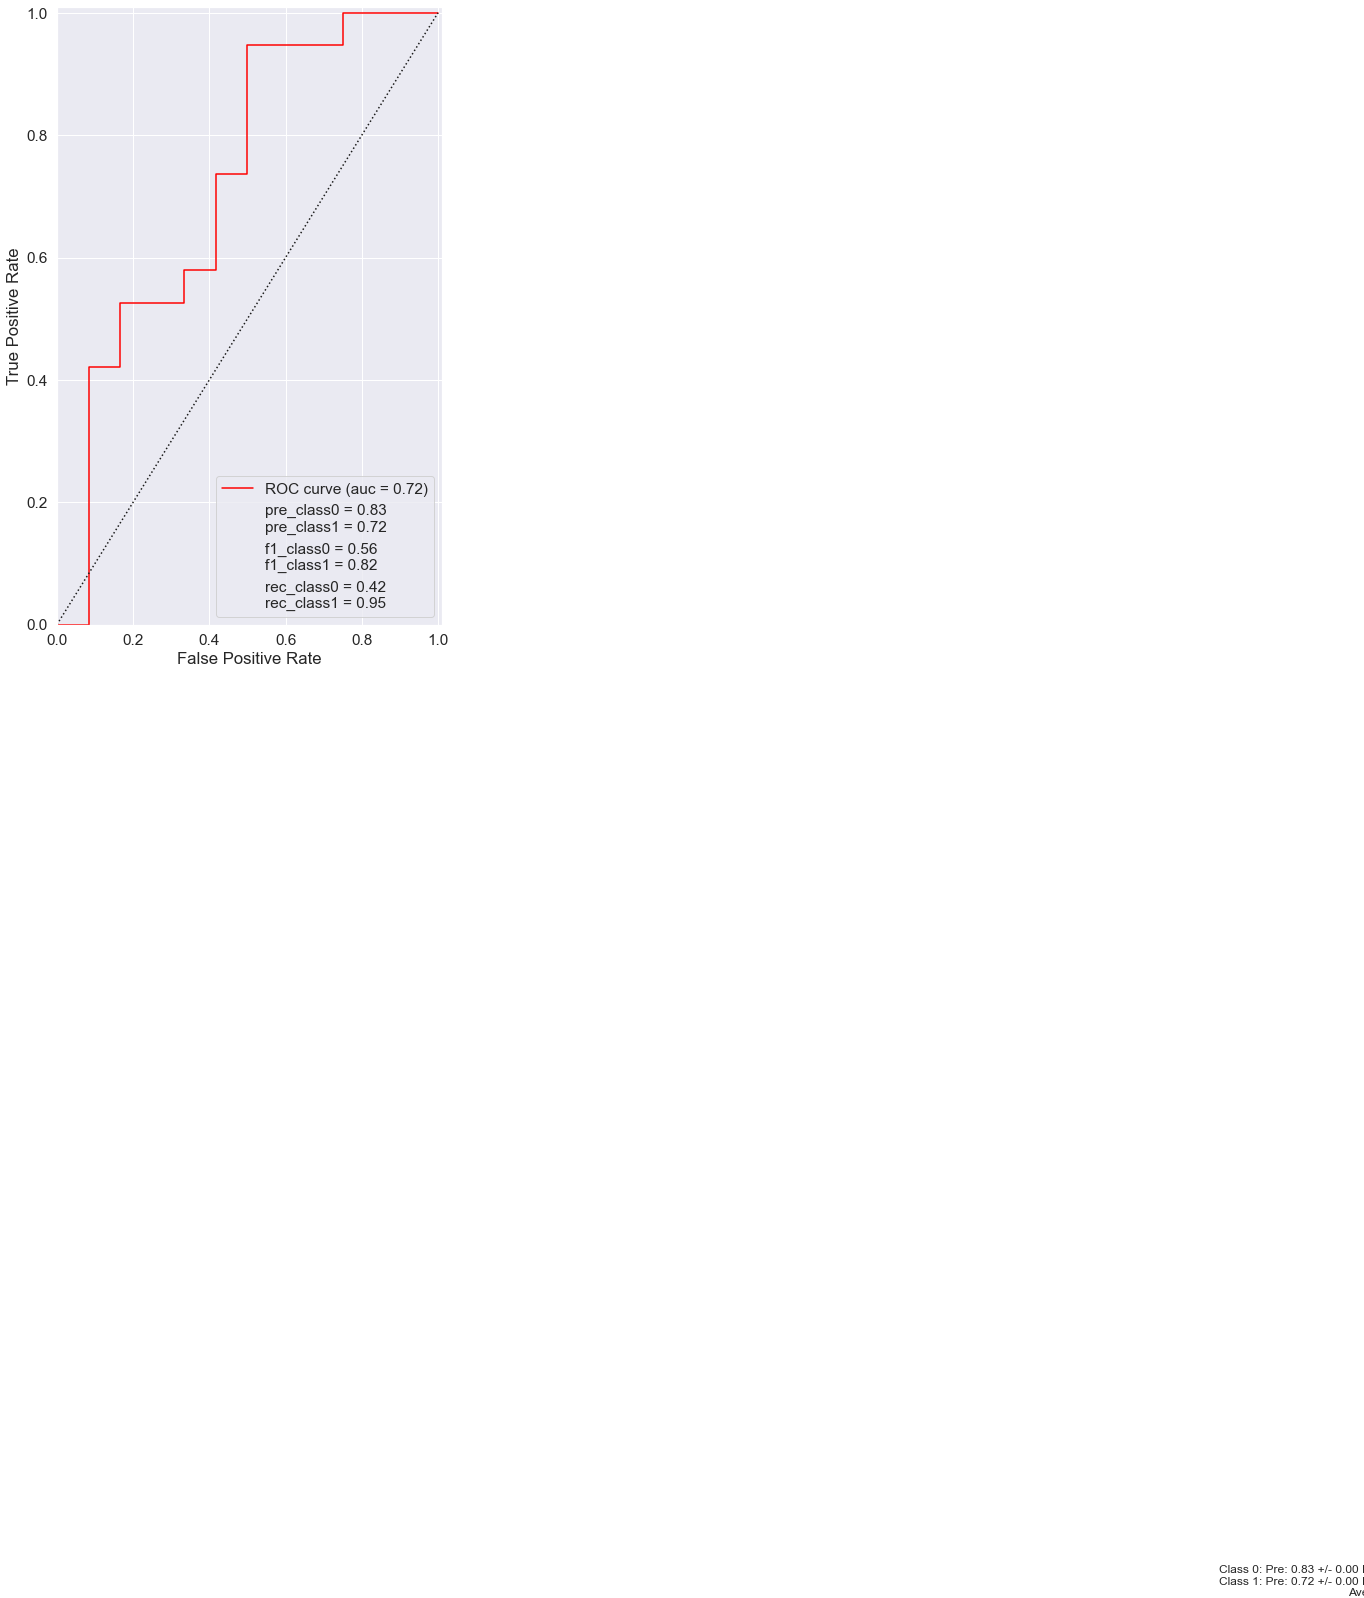


-----
Begin Logistic Regression
-----

Directory Logistic_Regression already exists will be overwritten
	Best parameters; {'C': 1.25, 'penalty': 'l2'}
	0.7231 (+/-0.1716) for {'C': 0.05, 'penalty': 'l2'}
	0.7291 (+/-0.1710) for {'C': 0.1, 'penalty': 'l2'}
	0.7331 (+/-0.1695) for {'C': 0.25, 'penalty': 'l2'}
	0.7314 (+/-0.1692) for {'C': 0.5, 'penalty': 'l2'}
	0.7371 (+/-0.1646) for {'C': 1.0, 'penalty': 'l2'}
	0.7388 (+/-0.1623) for {'C': 1.25, 'penalty': 'l2'}

	----- Predicting using: Logistic_Regression -----
/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
	ROC analysis area under the curve: 0.7543859649122806
	Confusion matrix (Logistic_Regression):
[[ 4  8]
 [ 2 17]]


	score (Logistic_Regression): 0.6774193548387096
	Imbalence reports:

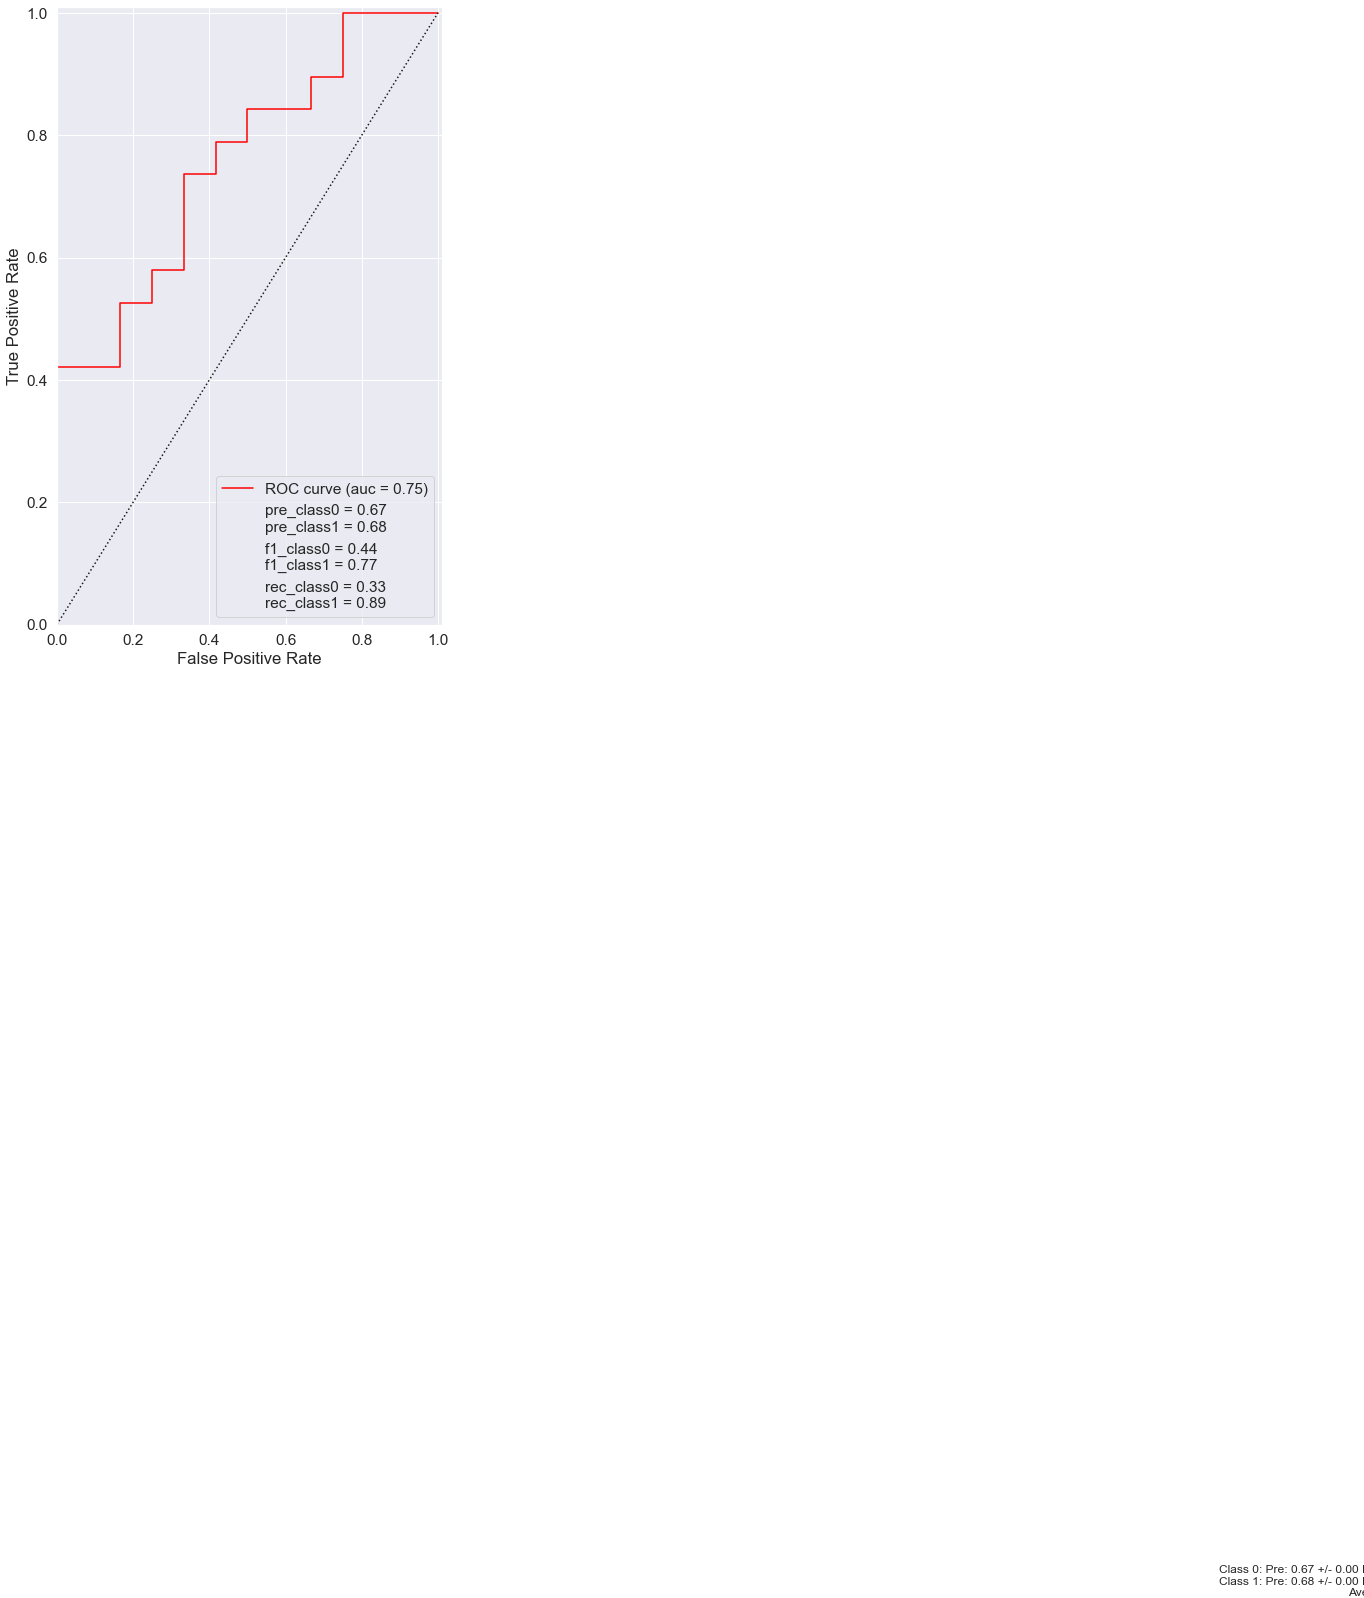

In [201]:
kfold_test_imbalenced_classifiers_with_optimization(Xtrain,Xtest, Ytrain , Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, cv=5, n_repeats=10,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

In [202]:
directory_names = wf.directory_names_from_classfier_names(kfold_clf_names)


Nearest_Neighbors
-------------

Reading 0.csv
Saving plot to fig_nearest_neighbors_morgan.png
['fig_nearest_neighbors_morgan.png']
Attempting to calculate confusion based metrics
{'tn': 5, 'fp': 7, 'fn': 2, 'tp': 17}
[[ 5  7]
 [ 2 17]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Gaussian_Process
-------------

Reading 0.csv
Saving plot to fig_gaussian_process_morgan.png
['fig_nearest_neighbors_morgan.png', 'fig_gaussian_process_morgan.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 8, 'fn': 0, 'tp': 19}
[[ 4  8]
 [ 0 19]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/552888183.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

Decision_Tree
-------------

Reading 0.csv
Saving plot to fig_decision_tree_morgan.png
['fig_nearest_neighbors_morgan.png', 'fig_gaussian_process_morgan.png', 'fig_decision_tree_morgan.png']
Attempting to calculate confusion based metrics
{'tn': 6, 'fp': 6, 'fn': 6, 'tp': 13}
[[ 6  6]
 [ 6 13]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/552888183.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

ExtraTreesClassifier
-------------

Reading 0.csv
Saving plot to fig_extratreesclassifier_morgan.png
['fig_nearest_neighbors_morgan.png', 'fig_gaussian_process_morgan.png', 'fig_decision_tree_morgan.png', 'fig_extratreesclassifier_morgan.png']
Attempting to calculate confusion based metrics
{'tn': 7, 'fp': 5, 'fn': 3, 'tp': 16}
[[ 7  5]
 [ 3 16]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/552888183.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

AdaBoost
-------------

Reading 0.csv
Saving plot to fig_adaboost_morgan.png
['fig_nearest_neighbors_morgan.png', 'fig_gaussian_process_morgan.png', 'fig_decision_tree_morgan.png', 'fig_extratreesclassifier_morgan.png', 'fig_adaboost_morgan.png']
Attempting to calculate confusion based metrics
{'tn': 5, 'fp': 7, 'fn': 1, 'tp': 18}
[[ 5  7]
 [ 1 18]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/552888183.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

Logistic_Regression
-------------

Reading 0.csv
Saving plot to fig_logistic_regression_morgan.png
['fig_nearest_neighbors_morgan.png', 'fig_gaussian_process_morgan.png', 'fig_decision_tree_morgan.png', 'fig_extratreesclassifier_morgan.png', 'fig_adaboost_morgan.png', 'fig_logistic_regression_morgan.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 8, 'fn': 2, 'tp': 17}
[[ 4  8]
 [ 2 17]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/552888183.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/552888183.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_16151/552888183.py:42: FutureWarning: In 

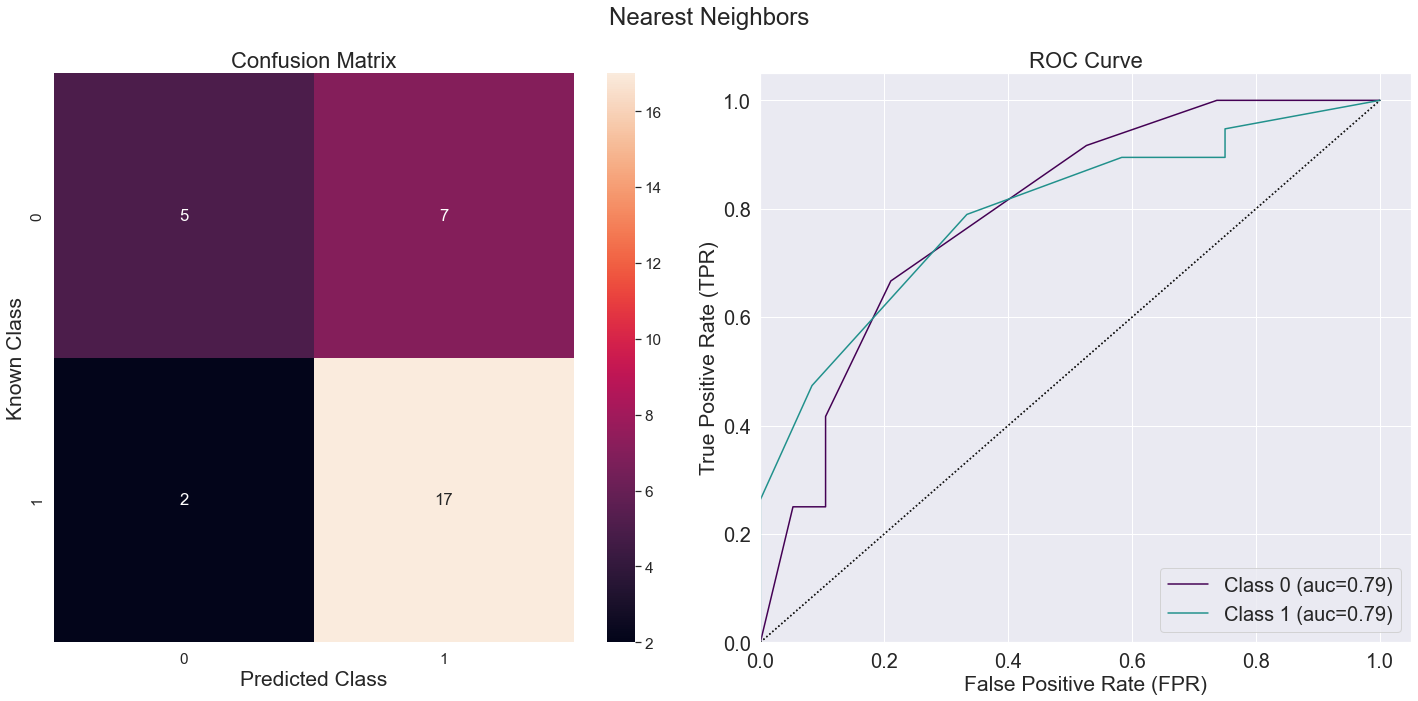

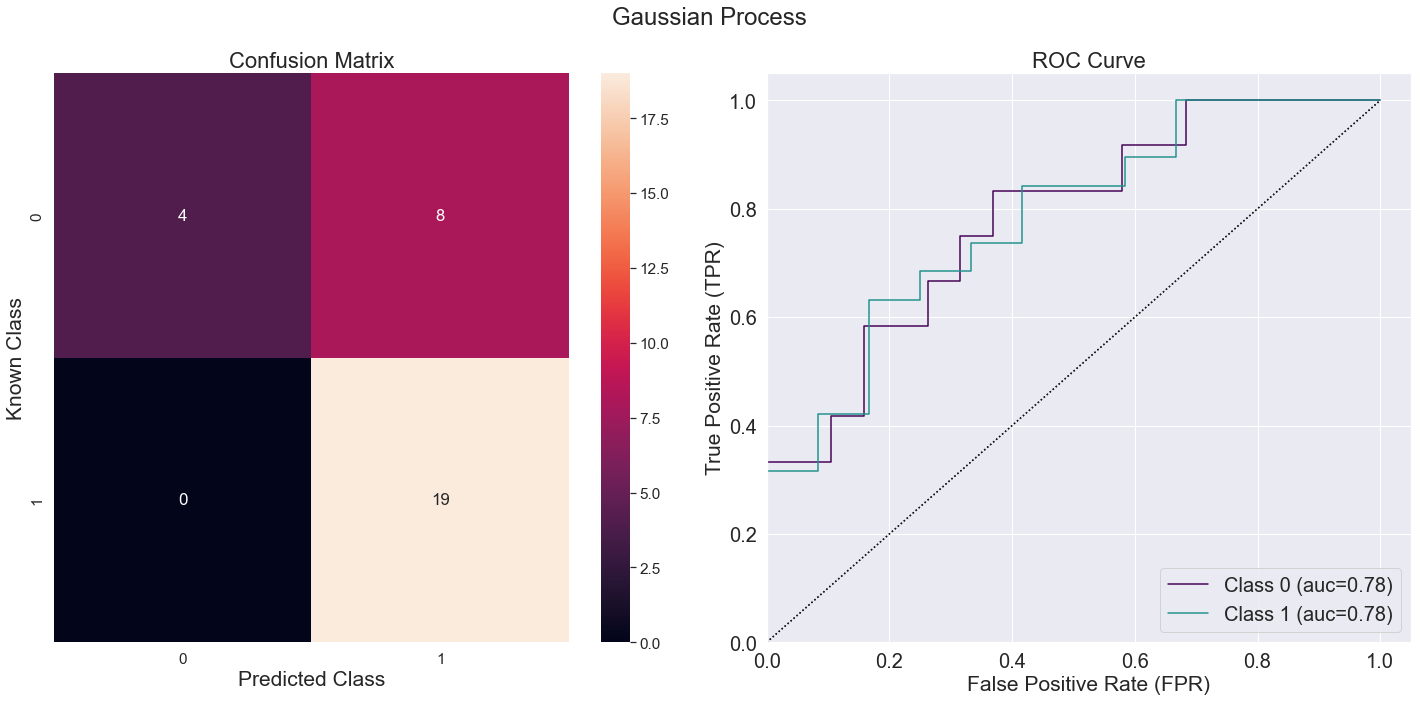

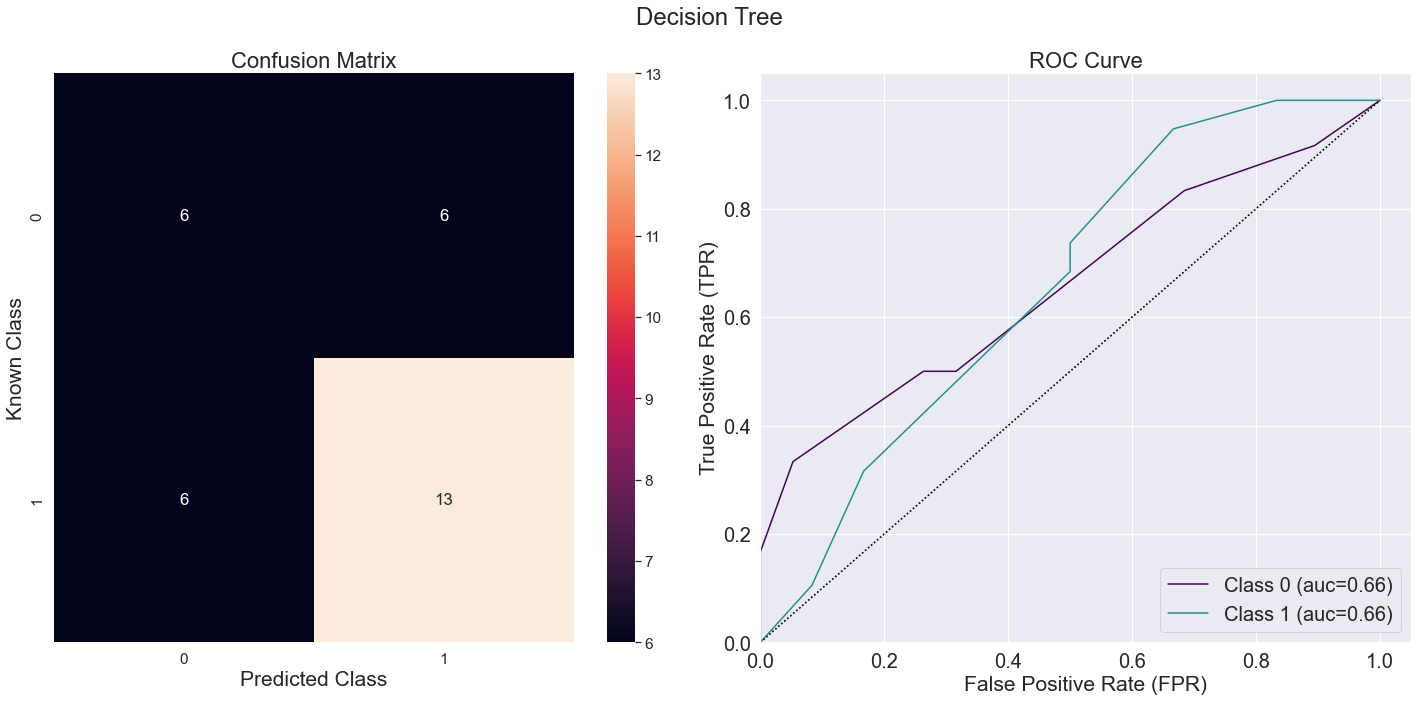

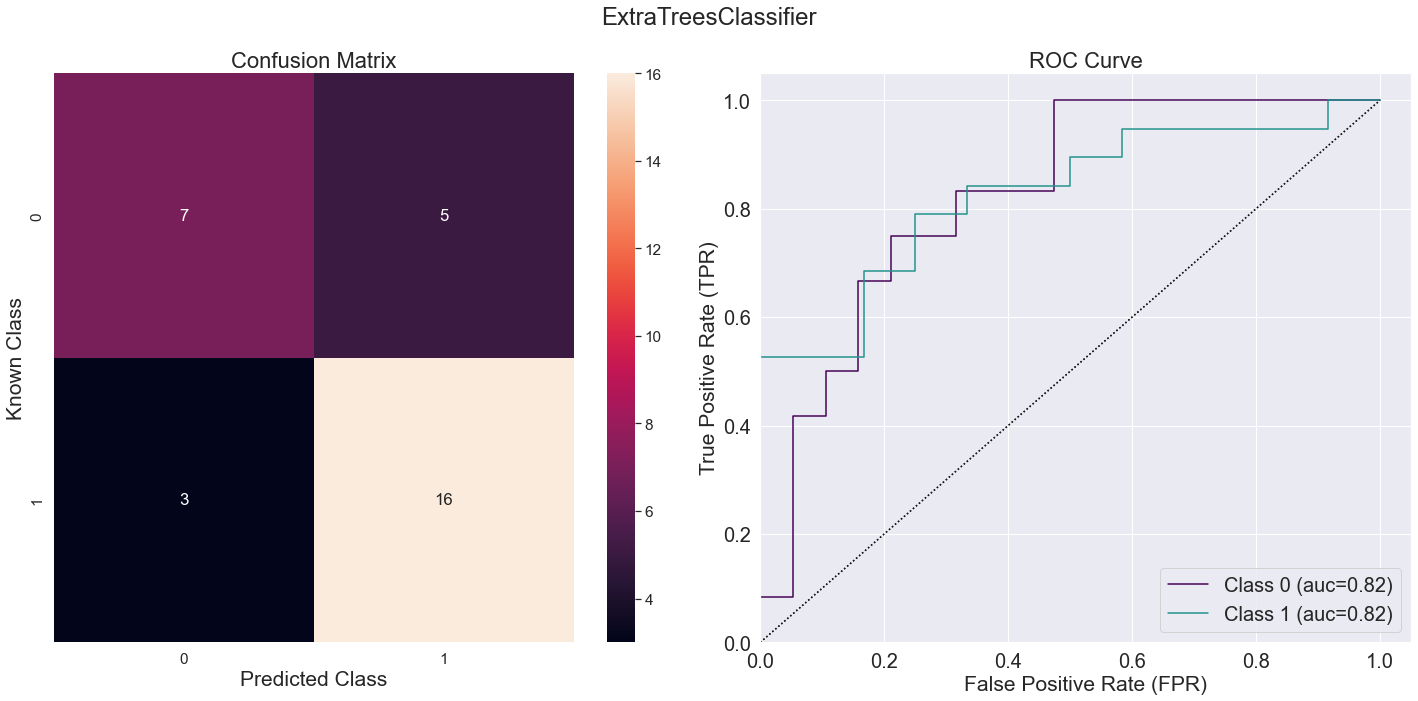

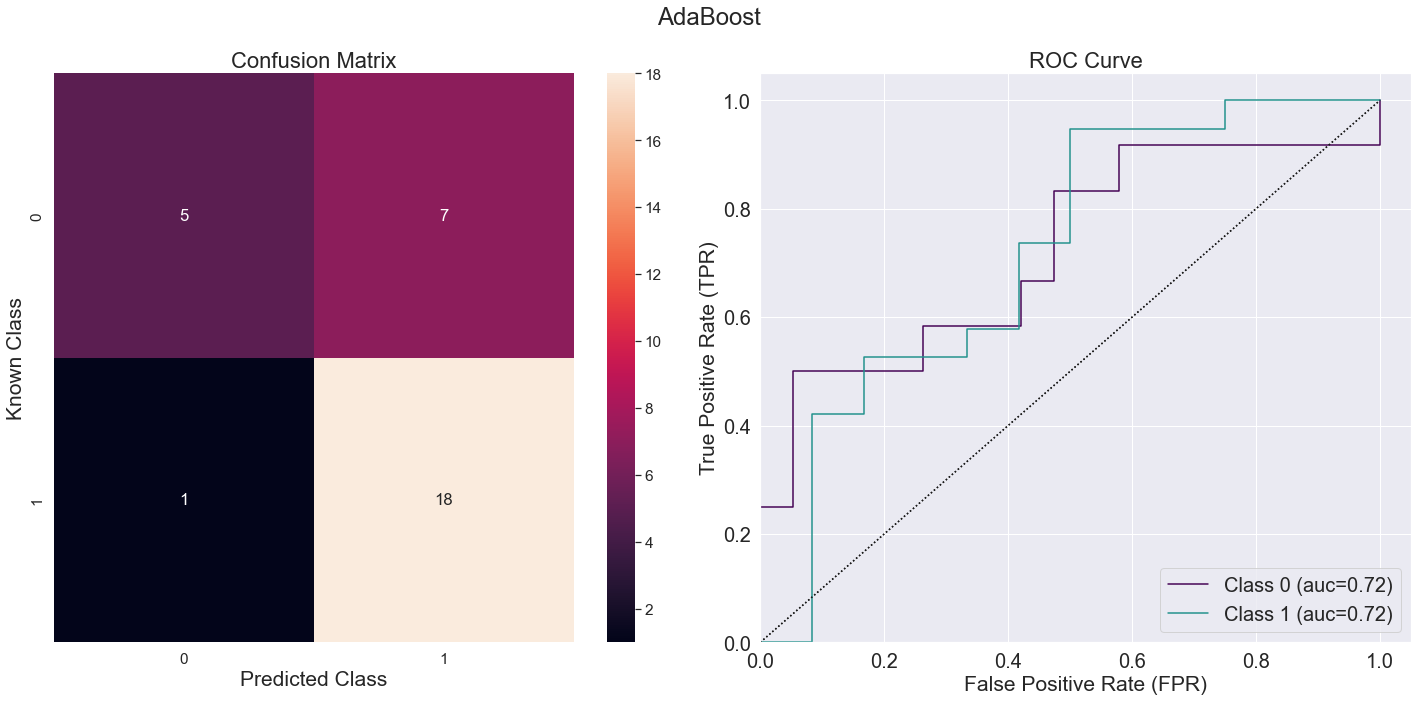

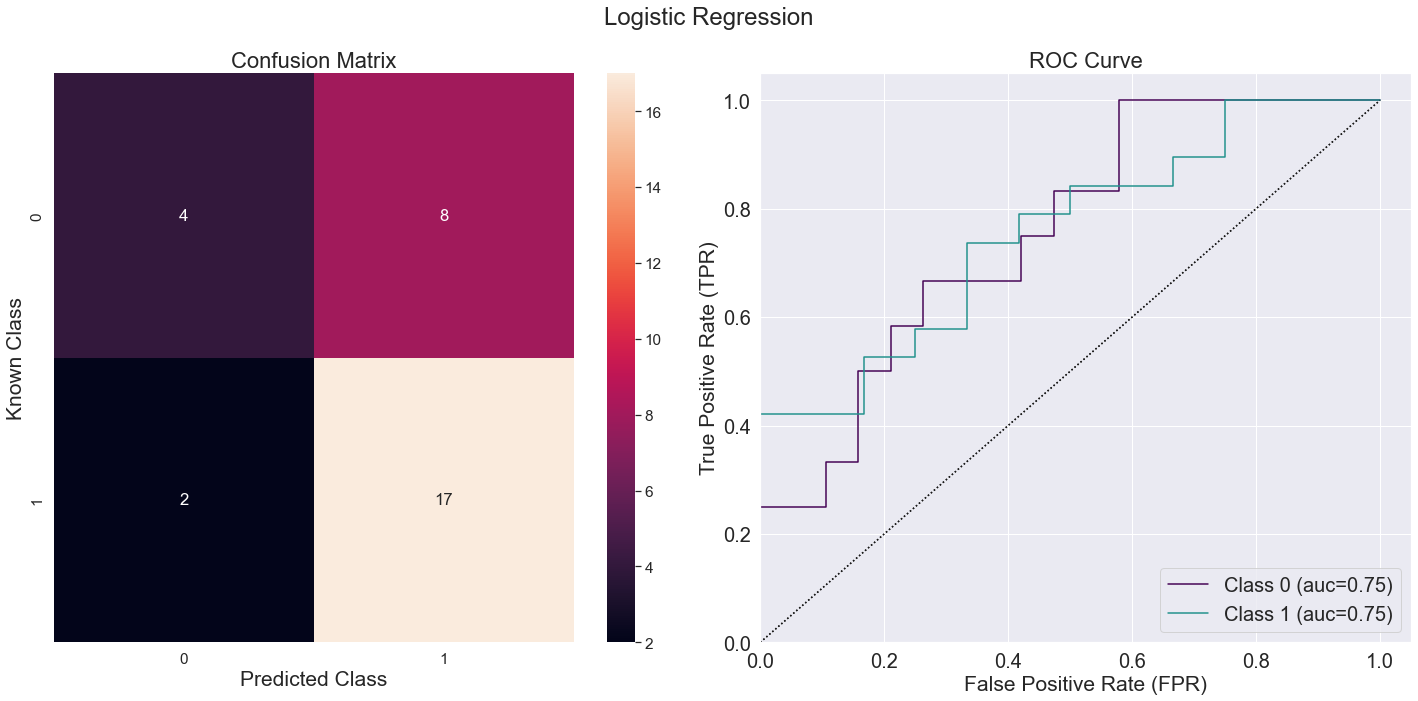

In [203]:
files_plt = []

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=1)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "fig_{}_morgan.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [204]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_morgan.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600
